In [2]:
# import CSS stylesheet
from IPython.display import HTML, display
display(HTML(f"<style>{open('../style.css').read()}</style>"))

<a id="summary"></a>

<p class="summary">Summary</p>

<ol class="sub">
    <li class="sub"><a href="#resume-the-data">Resume the data</a></li>
    <li class="sub"><a href="#packages">Packages</a>
    <li class="sub"><a href="#global-variables-and-functions">Global variables and functions</a></li>
    <li class="sub"><a href="#load-data">Load data</a>
        <ol class="sub">
            <li class="sub"><a href="#environmental-data-and-grid-occurrences">Environmental data and grid occurrences</a></li>
            <li class="sub"><a href="#filtered-species-jorge">Filtered Species (Jorge) (the section below use the correct list of species to filter the original data)</a></li>
            <li class="sub"><a href="#filtering-original-occurrences">Filtering original occurrences using final revised species list **(must run!)**</a></li>
        </ol>
        </li>
    <li class="sub"><a href="#selecting-the-pairs">Selecting the pairs of sister species</a>
        <ol class="sub">
            <li class="sub"><a href="#all-species">All species</a></li>
            <li class="sub"><a href="#common-species">Common species in Europe and North America</a></li>
        </ol>
    </li>
    <li class="sub"><a href="#environmental-features">Environmental features within overlap</a></li>
    <li class="sub"><a href="#richness-maps">Richness maps</a></li>
    <li class="sub"><a href="#comparisons-between">Comparisons between 50 km², 100 km², and 200 km² for features distributions in overlapping areas</a>
        <ol class="sub">
            <li class="sub"><a href="#checking-pairs">Checking pairs of species in all scales</a>
                <ol class="sub">
                    <li class="sub"><a href="#checking-pairs-europe">Europe</a></li>
                    <li class="sub"><a href="#checking-pairs-north-america">North America</a></li>
                    <li class="sub"><a href="#checking-pairs-europe-common">Europe (common)</a></li>
                    <li class="sub"><a href="#checking-pairs-north-america-common">North America (common)</a></li>
                </ol>
            </li>
        </ol>
    </li>
    <li class="sub"><a href="#number-of-pairs">Number of pairs considering sympatry intervals</a></li>
    <li class="sub"><a href="#spearman-coefficient">Spearman coefficient with shuffling pairs (areas correlation between sister species)</a></li>
    <li class="sub"><a href="#comparison-of-the-environmental">Comparison of the environmental distributions between sister species</a></li>
    <li class="sub"><a href="#correlation-between-sympatry">Correlation between sympatry of pairs and their phylogenitic distance</a>
        <ol class="sub">
            <li class="sub"><a href="#patristic-distance-sympatry">Patristic distance $\times$ sympatry</a></li>
            <li class="sub"><a href="#patristic-distance-area">Patristic distance $\times$ area_diff</a></li>
            <li class="sub"><a href="#patristic-distance-grids">Patristic distance $\times$ grids_diff</a></li>
            <li class="sub"><a href="#correlation-of-all-variables">Correlation of all variables</a></li>
            <li class="sub"><a href="#correlation-between-sympatry-in-different-scales">Correlation between sympatry in different scales</a></li>
        </ol>
    </li>
    <li class="sub"><a href="#correlation-between-environmental-variables">Correlation between environmental variables of pairs and their phylogenetic distance</a></li>
</ol>

# Resume the data
<a id="resume-the-data"></a>
<a href="#summary">Summary</a>

Resuming the data:
- Europe
    - species: 134
    - genus: 53
    - pairs: 347
    - overlapping:
        - 50 $km^2$: 328
        - 100 $km^2$: 328
        - 200 $km^2$: 332 (+1.22%)*
    
- North America
    - species: 192
    - genus: 54
    - pairs: 730
    - overlapping:
        - 50 $km^2$: 545
        - 100 $km^2$: 547 (+0.37%)*
        - 200 $km^2$: 552 (+1.28%)*

- Common
    - species: 38
    - genus: 18
    - pairs: 63
    - overlapping
        - Europe
            - 50 $km^2$: 62
            - 100 $km^2$: 62
            - 200 $km^2$: 62
        - North America
            - 50 $km^2$: 60
            - 100 $km^2$: 60
            - 200 $km^2$: 60
            
**\* comparison against the 50 $km^2$ pairs.**

# Packages
<a id="packages"></a>
<a href="#summary">Summary</a>

In [123]:
import pandas as pd
import numpy as np
import geopandas as gpd
from shapely.geometry import Polygon

import matplotlib as mpl
import matplotlib.pyplot as plt
from mpl_toolkits.basemap import Basemap

from itertools import combinations
import string
import palettable

from pyhvr import *
loadstd()

# Global variables and functions
<a id="global-variables-and-functions"></a>
<a href="#summary">Summary</a>

In [119]:
rcparams = {'font.family': 'sans-serif',
               'font.sans-serif': ['Helvetica'],
               'axes.labelsize': 28,
               'axes.titlesize': 28,
               'legend.fontsize': 20,
               'ytick.right': 'off',
               'xtick.top': 'off',
               'ytick.left': 'on',
               'xtick.bottom': 'on',
               'xtick.labelsize': '25',
               'ytick.labelsize': '25',
               'axes.linewidth': 2.5,
               'xtick.major.width': 1.8,
               'xtick.minor.width': 1.8,
               'xtick.major.size': 14,
               'xtick.minor.size': 7,
               'xtick.major.pad': 10,
               'xtick.minor.pad': 10,
               'ytick.major.width': 1.8,
               'ytick.minor.width': 1.8,
               'ytick.major.size': 14,
               'ytick.minor.size': 7,
               'ytick.major.pad': 10,
               'ytick.minor.pad': 10,
               'axes.labelpad': 15,
               'axes.titlepad': 15,
               'axes.spines.right': False,
               'axes.spines.top': False
              }
mpl.rcParams.update(rcparams)

In [4]:
# GeoPandas world polygons
world = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))
europe = world[(world['continent'] == 'Europe') & (world['name'] != 'Russia')]
north_america = world[world['continent'] == 'North America']

# NAD83 projection
nad83_proj_dict = {'datum': 'NAD83',
 'lat_0': 40,
 'lat_1': 20,
 'lat_2': 60,
 'lon_0': -96,
 'no_defs': True,
 'proj': 'lcc',
 'units': 'm',
 'x_0': 0,
 'y_0': 0}

# WGS84 projection
wgs84_proj_dict = {'init': 'epsg:4326'}

# Eckert IV projection - equal-area
weck4_proj_dict = "+proj=eck4 +lon_0=0 +x_0=0 +y_0=0 +datum=WGS84 +units=m +no_defs"

This is the **Cylindrical Equal-Area Projection** which was used to create the final maps for Europe and North America presenting the area occupied by the species.

In [122]:
Basemap(projection='cea').proj4string

'+proj=cea +R=6370997.0 +units=m +lat_ts=0.0 +lon_0=0.0 +x_0=20015077.371242613 +y_0=6370997.0 '

In [5]:
# Cylindrical Equal-Area projection
cea_proj_dict = "+proj=cea +R=6370997.0 +units=m +lat_ts=0.0 +lon_0=0.0 +x_0=20015077.371242613 +y_0=6370997.0"

In [6]:
# reading files with commun species in Europe and North America
common_sp_na_eu = pd.read_table('../results/common_sp_na_eu.dat', names=['species'])
common_sp_na_eu['genus'] = common_sp_na_eu['species'].apply(lambda s: s.split()[0])

# crating a pd.DataFrame with the common pairs in Europe and North America
common_pairs = pd.DataFrame([pair for pair in combinations(common_sp_na_eu['species'], 2)], columns=['sp1', 'sp2'])

features = ['mean_temp', 'mean_prec', 'mean_vtemp', 'alkalinity', 'water', 'lgm']

In [7]:
def axis_aesthetics(fig, rm_list=['right', 'top'], pad=20):
    """
    Change the axis aesthetics of the axes.
    The axis names that should be given for the configurations are:
    ``left``, ``right``, ``bottom``, and ``top``.

    Input
    -----
    fig - matplotlib.figure.Figure: figure instance to locate the axes.
    rm_list - list: list with the axis to remove.
    pad - float: number of points to deslocate the axis within the ``pad_list``.

    width and height names were chosen according to the padding configuration from the ``tight_layout``
    method from matplotlib.

    Output
    ------
    None
    """
    
    # create a list of axis to apply the padding
    pad_list = ['left', 'right', 'top', 'bottom']
    # select just those that are not on the rm_list
    [pad_list.remove(value) for value in rm_list]
    
    # loop through the axes in the figure
    for ax in fig.get_axes():
	    # loop through the axis
	    for loc, spine in ax.spines.items():
	        # check the axis to remove from the plot
	        if loc in rm_list:
	            spine.set_color('none') # don't draw spine
	        
	        # check the axis to apply the padding
	        elif loc in pad_list:
	            spine.set_position(('outward', pad)) # outward by 20 points
	            # check the axis to put ticks on height/vertical
	            if loc in ['right', 'left']:
	                ax.yaxis.set_ticks_position(loc)
	            #check the axis to put ticks on width/horizontal
	            elif loc in ['bottom', 'top']:
	                ax.xaxis.set_ticks_position(loc)

	        
	        # check if any axis name is mispelled.
	        else:
	            raise ValueError('unknown spine location: %s'%loc)

def place_axes_label(fig, x=-0.1, y=1.05, fs=40, str_type='lower case'):
	"""
	Put labels on the axes.

	Input
	-----
	fig - matplotlib.figure.Figure: figure instance to locate the axes
	and draw the labels.
	x - float: ``x`` position for the label.
	y - float: ``y`` position for the label.
	fs - float: font size of the label
	str_type - str: type of label to use. 
				``lower case`` uses string.ascii_lowercase characters
				``upper case`` uses string.ascii_uppercase characters
				``numeric`` uses numeric characters

	``x`` and ``y`` should be a position according to the axes fraction.

	"""

	axes = fig.get_axes()

	if str_type == 'lower case':
		labels = string.ascii_lowercase
	elif str_type == 'upper case':
		labels = string.ascii_uppercase
	elif str_type == 'numeric':
		labels = [str(n) for n in range(1, len(axes)+1)]
	else:
		raise ValueError("Unknown value for ``str_type``: {}.".format(str_type))

	for i, ax in enumerate(axes):
		ax.annotate(labels[i],
			xy=(x, y),
			xycoords='axes fraction',
			fontsize=fs,
			weight='bold'
			)

In [8]:
def stdfigsize(scale=1, nx=1, ny=1, ratio=1.3):
    """
    Returns a tuple to be used as figure size.

    Parameters
    ----------
    returns (7*ratio*scale*nx, 7.*scale*ny)
    By default: ratio=1.3
    If ratio<0 them ratio = golden ratio
    ----------
    Returns (7*ratio*scale*nx, 7.*scale*ny).
    
    ********
    This functions belongs to the `pyhvr` package.
    """
    if ratio < 0:
        ratio = 1.61803398875
    return((7*ratio*scale*nx, 7.*scale*ny))


# Load Data
<a id="load-data"></a>
<a href="#summary">Summary</a>

## Environmental data and grid occurrences
<a id="environmental-data-and-grid-occurrences"></a>
<a href="#summary">Summary</a>

bio1 - mean temperature

bio12 - mean precepitation

bio7 - mean variation temperature

In [10]:
europe_bio1_5050       = pd.read_excel('../data/Sister_sp_envs/EU_50km_envs.xlsx', sheet_name='bio1')
europe_bio12_5050      = pd.read_excel('../data/Sister_sp_envs/EU_50km_envs.xlsx', sheet_name='bio12')
europe_bio7_5050       = pd.read_excel('../data/Sister_sp_envs/EU_50km_envs.xlsx', sheet_name='bio7')
europe_alkalinity_5050 = pd.read_excel('../data/Sister_sp_envs/EU_50km_envs.xlsx', sheet_name='alkalinity')
# europe_water_5050      = pd.read_excel('../data/Sister_sp_envs/EU_50km_envs.xlsx', sheet_name='water')
europe_lgm_5050        = pd.read_excel('../data/Sister_sp_envs/EU_50km_envs.xlsx', sheet_name='LGM')

europe_bio1_100100       = pd.read_excel('../data/Sister_sp_envs/EU_100km_envs.xlsx', sheet_name='bio1')
europe_bio12_100100      = pd.read_excel('../data/Sister_sp_envs/EU_100km_envs.xlsx', sheet_name='bio12')
europe_bio7_100100       = pd.read_excel('../data/Sister_sp_envs/EU_100km_envs.xlsx', sheet_name='bio7')
europe_alkalinity_100100 = pd.read_excel('../data/Sister_sp_envs/EU_100km_envs.xlsx', sheet_name='Alkalinity')
# europe_water_100100      = pd.read_excel('../data/Sister_sp_envs/EU_100km_envs.xlsx', sheet_name='water')
europe_lgm_100100        = pd.read_excel('../data/Sister_sp_envs/EU_100km_envs.xlsx', sheet_name='LGM')

europe_bio1_200200       = pd.read_excel('../data/Sister_sp_envs/EU_200km_envs.xlsx', sheet_name='bio1')
europe_bio12_200200      = pd.read_excel('../data/Sister_sp_envs/EU_200km_envs.xlsx', sheet_name='bio12')
europe_bio7_200200       = pd.read_excel('../data/Sister_sp_envs/EU_200km_envs.xlsx', sheet_name='bio7')
europe_alkalinity_200200 = pd.read_excel('../data/Sister_sp_envs/EU_200km_envs.xlsx', sheet_name='alkalinity')
# europe_water_200200      = pd.read_excel('../data/Sister_sp_envs/EU_200km_envs.xlsx', sheet_name='water')
europe_lgm_200200        = pd.read_excel('../data/Sister_sp_envs/EU_200km_envs.xlsx', sheet_name='LGM')

europe_water_5050_weck4   = pd.read_excel('../results/Water_eu_na_combined.xlsx', sheet_name='EU50km')
europe_water_100100_weck4 = pd.read_excel('../results/Water_eu_na_combined.xlsx', sheet_name='EU100km')
europe_water_200200_weck4 = pd.read_excel('../results/Water_eu_na_combined.xlsx', sheet_name='EU200km')

north_america_bio1_5050       = pd.read_excel('../data/Sister_sp_envs/NA_50km_envs.xlsx', sheet_name='na_bio1')
north_america_bio12_5050      = pd.read_excel('../data/Sister_sp_envs/NA_50km_envs.xlsx', sheet_name='na_bio12')
# north_america_bio7_5050       = pd.read_excel('../data/Sister_sp_envs/NA_50km_envs.xlsx', sheet_name='na_bio7')
north_america_bio7_5050       = pd.read_excel('../data/Sister_sp_envs/na_bio7_new.xlsx', sheet_name='na_50km_bio7_new') # new 18.01.19
# north_america_bio7_5050       = pd.read_excel('../data/Sister_sp_envs/NA_50km_bio7.xlsx', sheet_name='na_50km_bio7')
north_america_alkalinity_5050 = pd.read_excel('../data/Sister_sp_envs/NA_50km_envs.xlsx', sheet_name='Alkalinity')
# north_america_water_5050      = pd.read_excel('../data/Sister_sp_envs/NA_50km_envs.xlsx', sheet_name='water')
north_america_lgm_5050        = pd.read_excel('../data/Sister_sp_envs/NA_50km_envs.xlsx', sheet_name='LGM')

north_america_bio1_100100       = pd.read_excel('../data/Sister_sp_envs/NA_100km_envs.xlsx', sheet_name='bio1')
north_america_bio12_100100      = pd.read_excel('../data/Sister_sp_envs/NA_100km_envs.xlsx', sheet_name='bio12')
north_america_bio7_100100       = pd.read_excel('../data/Sister_sp_envs/na_bio7_new.xlsx', sheet_name='na_100km_bio7_new') # new 18.01.19
# north_america_bio7_100100       = pd.read_excel('../data/Sister_sp_envs/NA_100km_envs.xlsx', sheet_name='bio7')
north_america_alkalinity_100100 = pd.read_excel('../data/Sister_sp_envs/NA_100km_envs.xlsx', sheet_name='Alkalinity')
# north_america_water_100100      = pd.read_excel('../data/Sister_sp_envs/NA_100km_envs.xlsx', sheet_name='water')
north_america_lgm_100100        = pd.read_excel('../data/Sister_sp_envs/NA_100km_envs.xlsx', sheet_name='LGM')

north_america_bio1_200200       = pd.read_excel('../data/Sister_sp_envs/NA_200km_envs.xlsx', sheet_name='bio1')
north_america_bio12_200200      = pd.read_excel('../data/Sister_sp_envs/NA_200km_envs.xlsx', sheet_name='bio12')
north_america_bio7_200200       = pd.read_excel('../data/Sister_sp_envs/na_bio7_new.xlsx', sheet_name='na_200km_bio7_new') # new 18.01.19
# north_america_bio7_200200       = pd.read_excel('../data/Sister_sp_envs/NA_200km_envs.xlsx', sheet_name='bio7')
north_america_alkalinity_200200 = pd.read_excel('../data/Sister_sp_envs/NA_200km_envs.xlsx', sheet_name='alkalinity')
# north_america_water_200200      = pd.read_excel('../data/Sister_sp_envs/NA_200km_envs.xlsx', sheet_name='water')
north_america_lgm_200200        = pd.read_excel('../data/Sister_sp_envs/NA_200km_envs.xlsx', sheet_name='LGM')


north_america_water_5050_weck4   = pd.read_excel('../results/Water_eu_na_combined.xlsx', sheet_name='NA50km')
north_america_water_100100_weck4 = pd.read_excel('../results/Water_eu_na_combined.xlsx', sheet_name='NA100km')
north_america_water_200200_weck4 = pd.read_excel('../results/Water_eu_na_combined.xlsx', sheet_name='NA200km')

In [11]:
europe_water_5050_weck4.columns   = ['GRID_CODE', 'water%']
europe_water_100100_weck4.columns = ['GRID_CODE', 'water%']
europe_water_200200_weck4.columns = ['GRID_CODE', 'water%']

north_america_water_5050_weck4.columns   = ['GRID_CODE', 'water%']
north_america_water_100100_weck4.columns = ['GRID_CODE', 'water%']
north_america_water_200200_weck4.columns = ['GRID_CODE', 'water%']

In [12]:
occurrences_within_5050_grid_europe   = gpd.read_file('../results/europe/adj_matrix_5050/occurrences_within_5050_grid_europe.shp')
occurrences_within_100100_grid_europe = gpd.read_file('../results/europe/adj_matrix_100100/occurrences_within_100100_grid_europe.shp')
occurrences_within_200200_grid_europe = gpd.read_file('../results/europe/adj_matrix_200200/occurrences_within_200200_grid_europe.shp')

occurrences_within_5050_grid_north_america   = gpd.read_file('../results/north_america/adj_matrix_5050/occurrences_within_5050_grid_north_america.shp')
occurrences_within_100100_grid_north_america = gpd.read_file('../results/north_america/adj_matrix_100100/occurrences_within_100100_grid_north_america.shp')
occurrences_within_200200_grid_north_america = gpd.read_file('../results/north_america/adj_matrix_200200/occurrences_within_200200_grid_north_america.shp')

In [13]:
occurrences_within_5050_grid_europe['mean_temp']  = occurrences_within_5050_grid_europe['grid_code'].map(europe_bio1_5050.set_index('GRID_CODE').to_dict()['MEAN'])/10
occurrences_within_5050_grid_europe['mean_prec']  = occurrences_within_5050_grid_europe['grid_code'].map(europe_bio12_5050.set_index('GRID_CODE').to_dict()['MEAN'])
occurrences_within_5050_grid_europe['mean_vtemp'] = occurrences_within_5050_grid_europe['grid_code'].map(europe_bio7_5050.set_index('GRID_CODE').to_dict()['MEAN'])/10
occurrences_within_5050_grid_europe['alkalinity'] = occurrences_within_5050_grid_europe['grid_code'].map(europe_alkalinity_5050.set_index('GRID_CODE').to_dict()['MEAN'])
# occurrences_within_5050_grid_europe['water'] = occurrences_within_5050_grid_europe['grid_code'].map(europe_water_5050.set_index('GRID_CODE').to_dict()['water%'])
occurrences_within_5050_grid_europe['lgm'] = occurrences_within_5050_grid_europe['grid_code'].map(europe_lgm_5050.set_index('grid_code').to_dict()['Join_Count'])
occurrences_within_5050_grid_europe['lgm'] = occurrences_within_5050_grid_europe['grid_code'].map(occurrences_within_5050_grid_europe[occurrences_within_5050_grid_europe['lgm'] == 0]['lgm'].to_dict()).fillna(1)

occurrences_within_100100_grid_europe['mean_temp']  = occurrences_within_100100_grid_europe['grid_code'].map(europe_bio1_100100.set_index('GRID_CODE').to_dict()['MEAN'])/10
occurrences_within_100100_grid_europe['mean_prec']  = occurrences_within_100100_grid_europe['grid_code'].map(europe_bio12_100100.set_index('GRID_CODE').to_dict()['MEAN'])
occurrences_within_100100_grid_europe['mean_vtemp'] = occurrences_within_100100_grid_europe['grid_code'].map(europe_bio7_100100.set_index('GRID_CODE').to_dict()['MEAN'])/10
occurrences_within_100100_grid_europe['alkalinity'] = occurrences_within_100100_grid_europe['grid_code'].map(europe_alkalinity_100100.set_index('GRID_CODE').to_dict()['MEAN'])
# occurrences_within_100100_grid_europe['water'] = occurrences_within_100100_grid_europe['grid_code'].map(europe_water_100100.set_index('GRID_CODE').to_dict()['water%'])
occurrences_within_100100_grid_europe['lgm'] = occurrences_within_100100_grid_europe['grid_code'].map(europe_lgm_100100.set_index('grid_code').to_dict()['Join_Count'])
occurrences_within_100100_grid_europe['lgm'] = occurrences_within_100100_grid_europe['grid_code'].map(occurrences_within_100100_grid_europe[occurrences_within_100100_grid_europe['lgm'] == 0]['lgm'].to_dict()).fillna(1)

occurrences_within_200200_grid_europe['mean_temp']  = occurrences_within_200200_grid_europe['grid_code'].map(europe_bio1_200200.set_index('GRID_CODE').to_dict()['MEAN'])/10
occurrences_within_200200_grid_europe['mean_prec']  = occurrences_within_200200_grid_europe['grid_code'].map(europe_bio12_200200.set_index('GRID_CODE').to_dict()['MEAN'])
occurrences_within_200200_grid_europe['mean_vtemp'] = occurrences_within_200200_grid_europe['grid_code'].map(europe_bio7_200200.set_index('GRID_CODE').to_dict()['MEAN'])/10
occurrences_within_200200_grid_europe['alkalinity'] = occurrences_within_200200_grid_europe['grid_code'].map(europe_alkalinity_200200.set_index('GRID_CODE').to_dict()['MEAN'])
# occurrences_within_200200_grid_europe['water'] = occurrences_within_200200_grid_europe['grid_code'].map(europe_water_200200.set_index('GRID_CODE').to_dict()['water%'])
occurrences_within_200200_grid_europe['lgm'] = occurrences_within_200200_grid_europe['grid_code'].map(europe_lgm_200200.set_index('grid_code').to_dict()['Join_Count'])
occurrences_within_200200_grid_europe['lgm'] = occurrences_within_200200_grid_europe['grid_code'].map(occurrences_within_200200_grid_europe[occurrences_within_200200_grid_europe['lgm'] == 0]['lgm'].to_dict()).fillna(1)

occurrences_within_5050_grid_north_america['mean_temp']  = occurrences_within_5050_grid_north_america['grid_code'].map(north_america_bio1_5050.set_index('GRID_CODE').to_dict()['MEAN'])/10
occurrences_within_5050_grid_north_america['mean_prec']  = occurrences_within_5050_grid_north_america['grid_code'].map(north_america_bio12_5050.set_index('GRID_CODE').to_dict()['MEAN'])
occurrences_within_5050_grid_north_america['mean_vtemp'] = occurrences_within_5050_grid_north_america['grid_code'].map(north_america_bio7_5050.set_index('GRID_CODE').to_dict()['MEAN'])/10
occurrences_within_5050_grid_north_america['alkalinity'] = occurrences_within_5050_grid_north_america['grid_code'].map(north_america_alkalinity_5050.set_index('GRID_CODE').to_dict()['MEAN'])
# occurrences_within_5050_grid_north_america['water'] = occurrences_within_5050_grid_north_america['grid_code'].map(north_america_water_5050.set_index('GRID_CODE').to_dict()['water%'])
occurrences_within_5050_grid_north_america['lgm'] = occurrences_within_5050_grid_north_america['grid_code'].map(north_america_lgm_5050.set_index('grid_code').to_dict()['Join_Count'])
occurrences_within_5050_grid_north_america['lgm'] = occurrences_within_5050_grid_north_america['grid_code'].map(occurrences_within_5050_grid_north_america[occurrences_within_5050_grid_north_america['lgm'] == 0]['lgm'].to_dict()).fillna(1)

occurrences_within_100100_grid_north_america['mean_temp']  = occurrences_within_100100_grid_north_america['grid_code'].map(north_america_bio1_100100.set_index('GRID_CODE').to_dict()['MEAN'])/10
occurrences_within_100100_grid_north_america['mean_prec']  = occurrences_within_100100_grid_north_america['grid_code'].map(north_america_bio12_100100.set_index('GRID_CODE').to_dict()['MEAN'])
occurrences_within_100100_grid_north_america['mean_vtemp'] = occurrences_within_100100_grid_north_america['grid_code'].map(north_america_bio7_100100.set_index('GRID_CODE').to_dict()['MEAN'])/10
occurrences_within_100100_grid_north_america['alkalinity'] = occurrences_within_100100_grid_north_america['grid_code'].map(north_america_alkalinity_100100.set_index('GRID_CODE').to_dict()['MEAN'])
# occurrences_within_100100_grid_north_america['water'] = occurrences_within_100100_grid_north_america['grid_code'].map(north_america_water_100100.set_index('GRID_CODE').to_dict()['water%'])
occurrences_within_100100_grid_north_america['lgm'] = occurrences_within_100100_grid_north_america['grid_code'].map(north_america_lgm_100100.set_index('grid_code').to_dict()['Join_Count'])
occurrences_within_100100_grid_north_america['lgm'] = occurrences_within_100100_grid_north_america['grid_code'].map(occurrences_within_100100_grid_north_america[occurrences_within_100100_grid_north_america['lgm'] == 0]['lgm'].to_dict()).fillna(1)

occurrences_within_200200_grid_north_america['mean_temp']  = occurrences_within_200200_grid_north_america['grid_code'].map(north_america_bio1_200200.set_index('GRID_CODE').to_dict()['MEAN'])/10
occurrences_within_200200_grid_north_america['mean_prec']  = occurrences_within_200200_grid_north_america['grid_code'].map(north_america_bio12_200200.set_index('GRID_CODE').to_dict()['MEAN'])
occurrences_within_200200_grid_north_america['mean_vtemp'] = occurrences_within_200200_grid_north_america['grid_code'].map(north_america_bio7_200200.set_index('GRID_CODE').to_dict()['MEAN'])/10
occurrences_within_200200_grid_north_america['alkalinity'] = occurrences_within_200200_grid_north_america['grid_code'].map(north_america_alkalinity_200200.set_index('GRID_CODE').to_dict()['MEAN'])
# occurrences_within_200200_grid_north_america['water'] = occurrences_within_200200_grid_north_america['grid_code'].map(north_america_water_200200.set_index('GRID_CODE').to_dict()['water%'])
occurrences_within_200200_grid_north_america['lgm'] = occurrences_within_200200_grid_north_america['grid_code'].map(north_america_lgm_200200.set_index('grid_code').to_dict()['Join_Count'])
occurrences_within_200200_grid_north_america['lgm'] = occurrences_within_200200_grid_north_america['grid_code'].map(occurrences_within_200200_grid_north_america[occurrences_within_200200_grid_north_america['lgm'] == 0]['lgm'].to_dict()).fillna(1)

Here we load the grids remade for the water % count.

In [14]:
occurrences_within_5050_grid_europe_weck4   = gpd.read_file('../results/europe/adj_matrix_5050_border_weck4/occurrences_within_5050_grid_europe_border_weck4.shp')
occurrences_within_100100_grid_europe_weck4 = gpd.read_file('../results/europe/adj_matrix_100100_border_weck4/occurrences_within_100100_grid_europe_border_weck4.shp')
occurrences_within_200200_grid_europe_weck4 = gpd.read_file('../results/europe/adj_matrix_200200_border_weck4/occurrences_within_200200_grid_europe_border_weck4.shp')

occurrences_within_5050_grid_north_america_weck4   = gpd.read_file('../results/north_america/adj_matrix_5050_border_weck4/occurrences_within_5050_grid_north_america_border_weck4.shp')
occurrences_within_100100_grid_north_america_weck4 = gpd.read_file('../results/north_america/adj_matrix_100100_border_weck4/occurrences_within_100100_grid_north_america_border_weck4.shp')
occurrences_within_200200_grid_north_america_weck4 = gpd.read_file('../results/north_america/adj_matrix_200200_border_weck4/occurrences_within_200200_grid_north_america_border_weck4.shp')

In [15]:
occurrences_within_5050_grid_europe_weck4['water']   = occurrences_within_5050_grid_europe_weck4['grid_code'].map(europe_water_5050_weck4.set_index('GRID_CODE').to_dict()['water%'])
occurrences_within_100100_grid_europe_weck4['water'] = occurrences_within_100100_grid_europe_weck4['grid_code'].map(europe_water_100100_weck4.set_index('GRID_CODE').to_dict()['water%'])
occurrences_within_200200_grid_europe_weck4['water'] = occurrences_within_200200_grid_europe_weck4['grid_code'].map(europe_water_200200_weck4.set_index('GRID_CODE').to_dict()['water%'])

occurrences_within_5050_grid_north_america_weck4['water']   = occurrences_within_5050_grid_north_america_weck4['grid_code'].map(north_america_water_5050_weck4.set_index('GRID_CODE').to_dict()['water%'])
occurrences_within_100100_grid_north_america_weck4['water'] = occurrences_within_100100_grid_north_america_weck4['grid_code'].map(north_america_water_100100_weck4.set_index('GRID_CODE').to_dict()['water%'])
occurrences_within_200200_grid_north_america_weck4['water'] = occurrences_within_200200_grid_north_america_weck4['grid_code'].map(north_america_water_200200_weck4.set_index('GRID_CODE').to_dict()['water%'])

In [16]:
features_list   = ['Total', 'grid_code', 'geometry', 'mean_temp', 'mean_prec', 'mean_vtemp', 'alkalinity', 'lgm']
features_list_2 = ['Total', 'grid_code', 'geometry', 'water']

In [17]:
europe_code_sp_dict = pd.read_table('../results/europe/adj_matrix_5050/europe_code_sp.dat')
north_america_code_sp_dict = pd.read_table('../results/north_america/adj_matrix_5050/north_america_code_sp.dat')

europe_code_sp_dict_weck4 = pd.read_table('../results/europe/adj_matrix_5050_border_weck4/europe_code_sp.dat')
north_america_code_sp_dict_weck4 = pd.read_table('../results/north_america/adj_matrix_5050_border_weck4/north_america_code_sp.dat')

In [18]:
europe_code_sp_dict['genus'] = europe_code_sp_dict['specie'].apply(lambda s: s.split()[0])
north_america_code_sp_dict['genus'] = north_america_code_sp_dict['specie'].apply(lambda s: s.split()[0])

europe_code_sp_dict_weck4['genus'] = europe_code_sp_dict_weck4['specie'].apply(lambda s: s.split()[0])
north_america_code_sp_dict_weck4['genus'] = north_america_code_sp_dict_weck4['specie'].apply(lambda s: s.split()[0])

# this fix the codes of species making the original and the weck4 species codes equal.
north_america_code_sp_dict_weck4['codes_fixed'] = north_america_code_sp_dict_weck4['specie'].map(north_america_code_sp_dict.set_index('specie').to_dict()['codes'])

In [19]:
[
    occurrences_within_5050_grid_europe_weck4.shape,
    occurrences_within_100100_grid_europe_weck4.shape,
    occurrences_within_200200_grid_europe_weck4.shape
]

[(1863, 161), (538, 161), (172, 161)]

In [20]:
[
    occurrences_within_5050_grid_north_america_weck4.shape,
    occurrences_within_100100_grid_north_america_weck4.shape,
    occurrences_within_200200_grid_north_america_weck4.shape
]

[(9339, 220), (2589, 220), (773, 220)]

## Filtered Species (Jorge) (the section below use the correct list of species to filter the original data)
<a id="filtered-species-jorge"></a>
<a href="#summary">Summary</a>

In [22]:
new_data_eu = pd.read_excel('new_data/Strict_spp_list_EU_NA_by_Jorge.xlsx', sheet_name='EU')
new_data_na = pd.read_excel('new_data/Strict_spp_list_EU_NA_by_Jorge.xlsx', sheet_name='NA')

First I have to select in the old data only the species that are found in the ``new_data`` sheet sent by Jorge.

In [23]:
jorge_species_eu = np.asarray(new_data_eu.columns[1:])
jorge_species_na = np.asarray(new_data_na.columns[1:])

In [24]:
jorge_species_eu.shape[0], jorge_species_na.shape[0]

(137, 194)

For Europe we have 157 species:

In [25]:
occurrences_within_5050_grid_europe.columns[
    occurrences_within_5050_grid_europe.columns.str.contains("^[0-9]")
]

Index(['0_Acorus c', '1_Aldrovan', '2_Alisma g', '3_Alisma l', '4_Alisma p',
       '5_Alisma w', '6_Apium in', '7_Azolla f', '8_Baldelli', '9_Berula e',
       ...
       '147_Utricu', '148_Utricu', '149_Utricu', '150_Utricu', '151_Veroni',
       '152_Veroni', '153_Veroni', '154_Zannic', '155_Elatin', '156_Elatin'],
      dtype='object', length=157)

The number/code and the name followed can be put together by the following dictionary.

In [26]:
europe_code_sp_dict.head()

codes                    specie       genus
0      0            Acorus calamus      Acorus
1      1     Aldrovanda vesiculosa  Aldrovanda
2      2          Alisma gramineum      Alisma
3      3        Alisma lanceolatum      Alisma
4      4  Alisma plantago-aquatica      Alisma

For North America we have 216 species:

In [27]:
occurrences_within_5050_grid_north_america.columns[
    occurrences_within_5050_grid_north_america.columns.str.contains("^[0-9]")
]

Index(['0_Alisma g', '1_Alisma l', '2_Alisma s', '3_Alisma t', '4_Azolla c',
       '5_Azolla f', '6_Azolla m', '7_Blyxa au', '8_Brasenia', '9_Butomus',
       ...
       '206_Typha', '207_Vallis', '208_Wolffi', '209_Wolffi', '210_Wolffi',
       '211_Wolffi', '212_Wolffi', '213_Wolffi', '214_Wolffi', '215_Zannic'],
      dtype='object', length=216)

The number/code and the name followed can be put together by the following dictionary:

In [28]:
north_america_code_sp_dict.head()

codes              specie   genus
0      0    Alisma gramineum  Alisma
1      1  Alisma lanceolatum  Alisma
2      2  Alisma subcordatum  Alisma
3      3     Alisma triviale  Alisma
4      4  Azolla caroliniana  Azolla

These are the species from the original data that intersects with the filtered data (Europe - 131, 83.44% of the original data):

In [29]:
np.intersect1d(europe_code_sp_dict['specie'], jorge_species_eu)

array(['Acorus calamus', 'Aldrovanda vesiculosa', 'Alisma gramineum',
       'Alisma lanceolatum', 'Alisma plantago-aquatica',
       'Alisma wahlenbergii', 'Azolla filiculoides',
       'Baldellia ranunculoides', 'Berula erecta', 'Butomus umbellatus',
       'Callitriche brutia', 'Callitriche cophocarpa',
       'Callitriche hamulata', 'Callitriche hermaphroditica',
       'Callitriche palustris', 'Callitriche stagnalis',
       'Callitriche truncata', 'Carex aquatilis', 'Carex limosa',
       'Carex rostrata', 'Carex vesicaria', 'Ceratophyllum demersum',
       'Ceratophyllum muricatum', 'Ceratophyllum platyacanthum',
       'Ceratophyllum submersum', 'Cladium mariscus', 'Crassula helmsii',
       'Egeria densa', 'Elatine alsinastrum', 'Elatine hexandra',
       'Elatine hydropiper', 'Elatine triandra', 'Eleocharis acicularis',
       'Eleocharis mamillata', 'Eleocharis multicaulis',
       'Eleocharis palustris', 'Eleocharis parvula',
       'Eleocharis uniglumis', 'Elodea canadensi

These are the species from the original data that intersects with the filtered data (North America - 168, 77.78% of the original data):

In [30]:
north_america_code_sp_dict[north_america_code_sp_dict['specie'].str.contains('Isoetes')]

codes                specie    genus
49     49    Isoetes acadiensis  Isoetes
50     50     Isoetes bolanderi  Isoetes
51     51   Isoetes caroliniana  Isoetes
52     52   Isoetes echinospora  Isoetes
53     53   Isoetes engelmannii  Isoetes
54     54      Isoetes flaccida  Isoetes
55     55      Isoetes howellii  Isoetes
56     56     Isoetes lacustris  Isoetes
57     57      Isoetes maritima  Isoetes
59     59   Isoetes melanospora  Isoetes
60     60  Isoetes occidentalis  Isoetes
61     61    Isoetes prototypus  Isoetes
62     62       Isoetes riparia  Isoetes

In [31]:
np.intersect1d(north_america_code_sp_dict['specie'], jorge_species_na)

array(['Alisma gramineum', 'Alisma lanceolatum', 'Alisma subcordatum',
       'Alisma triviale', 'Azolla caroliniana', 'Azolla filiculoides',
       'Blyxa aubertii', 'Brasenia schreberi', 'Butomus umbellatus',
       'Caltha natans', 'Canna flaccida', 'Ceratophyllum demersum',
       'Ceratophyllum echinatum', 'Crinum americanum',
       'Damasonium californicum', 'Echinodorus cordifolius',
       'Egeria densa', 'Eichhornia crassipes', 'Elodea bifoliata',
       'Elodea canadensis', 'Elodea nuttallii', 'Equisetum fluviatile',
       'Eriocaulon aquaticum', 'Eriocaulon cinereum',
       'Eriocaulon compressum', 'Eriocaulon decangulare',
       'Eriocaulon koernickianum', 'Eriocaulon lineare',
       'Eriocaulon nigrobracteatum', 'Eriocaulon ravenelii',
       'Eriocaulon texense', 'Heteranthera dubia', 'Heteranthera limosa',
       'Heteranthera multiflora', 'Heteranthera reniformis',
       'Heteranthera rotundifolia', 'Hydrilla verticillata',
       'Hydrocharis morsus-ranae', 'Hydr

In [32]:
np.intersect1d(north_america_code_sp_dict['specie'], europe_code_sp_dict['specie'])

array(['Alisma gramineum', 'Alisma lanceolatum', 'Azolla filiculoides',
       'Butomus umbellatus', 'Ceratophyllum demersum', 'Egeria densa',
       'Elodea canadensis', 'Equisetum fluviatile',
       'Hydrocharis morsus-ranae', 'Isoetes echinospora',
       'Isoetes lacustris', 'Lemna minor', 'Lemna trisulca',
       'Najas flexilis', 'Nymphaea lotus', 'Nymphaea tetragona',
       'Potamogeton alpinus', 'Potamogeton crispus',
       'Potamogeton friesii', 'Potamogeton gramineus',
       'Potamogeton natans', 'Potamogeton nodosus',
       'Potamogeton obtusifolius', 'Potamogeton perfoliatus',
       'Potamogeton praelongus', 'Potamogeton pusillus',
       'Ranunculus hederaceus', 'Sparganium angustifolium',
       'Sparganium emersum', 'Sparganium glomeratum',
       'Sparganium hyperboreum', 'Sparganium natans',
       'Spirodela polyrrhiza', 'Typha latifolia',
       'Zannichellia palustris'], dtype=object)

In [33]:
europe_sp = gpd.read_file('../results/europe/sp_polygon/sp_polygon_europe.shp')
north_america_sp = gpd.read_file('../results/north_america/sp_polygon/sp_polygon_north_america.shp')

The number of species in Europe is 157.

In [34]:
europe_sp.shape[0]

157

In [35]:
europe_sp.head()

specie abbreviati       genus  \
0            Acorus calamus       None      Acorus   
1     Aldrovanda vesiculosa       None  Aldrovanda   
2          Alisma gramineum   AlisGram      Alisma   
3        Alisma lanceolatum   AlisLanc      Alisma   
4  Alisma plantago-aquatica       None      Alisma   

                                            geometry  
0  MULTIPOLYGON (((4731286.624 4273781.342, 46887...  
1  MULTIPOLYGON (((5863981.225 3866643.594, 58228...  
2  MULTIPOLYGON (((6019790.841 4402193.165, 59771...  
3  MULTIPOLYGON (((5156305.190 4149829.027, 51145...  
4  MULTIPOLYGON (((4776224.774 3799236.288, 47358...

The number of species in North America is 216.

In [36]:
north_america_sp.shape[0]

216

In [37]:
north_america_sp.head()

specie  abbreviati   genus  \
0    Alisma gramineum    AlisGram  Alisma   
1  Alisma lanceolatum    AlisLanc  Alisma   
2  Alisma subcordatum    AlisSubc  Alisma   
3     Alisma triviale    AlisTriv  Alisma   
4  Azolla caroliniana  AzolCaro_g  Azolla   

                                            geometry  
0  MULTIPOLYGON (((1505233.659 504657.842, 150523...  
1  MULTIPOLYGON (((-1944766.341 654657.842, -1944...  
2  POLYGON ((1355233.659 -595342.158, 1355233.659...  
3  POLYGON ((1755233.659 504657.842, 1705233.659 ...  
4  POLYGON ((105233.659 -1145342.158, 105233.659 ...

## Filtering original occurrences using final revised species list **(must run!)**
<a id="filtering-original-occurrences"></a>
<a href="#summary">Summary</a>

The following variables are the ones that we are going to work with. These have as rows the grids considered within the continents and as columns the name of all species considered (originally) in the continent, the ``Total`` species that appeared within that grid, ``grid_code`` for reference, ``geometry`` of the grid, and the values of the environmental variables: ``mean_temp``, ``mean_perc``, ``mean_vtemp``, ``alkalinity``, and ``lgm``. To consider the ``water`` column, referring to the % of water within the ``grid``, we used the variables that end with ``weck4``, because we had to cut the edges of the continents to consider just the amount of fresh water.

In [38]:
occurrences_within_5050_grid_north_america.head(3)

0_Alisma g  1_Alisma l  2_Alisma s  3_Alisma t  4_Azolla c  5_Azolla f  \
0         0.0         0.0         0.0         0.0         0.0         0.0   
1         0.0         0.0         0.0         0.0         0.0         0.0   
2         0.0         0.0         0.0         0.0         0.0         0.0   

   6_Azolla m  7_Blyxa au  8_Brasenia  9_Butomus  ...  214_Wolffi  215_Zannic  \
0         0.0         0.0         0.0        0.0  ...         0.0         0.0   
1         0.0         0.0         0.0        0.0  ...         0.0         0.0   
2         0.0         0.0         0.0        0.0  ...         0.0         0.0   

   Total  grid_code                                           geometry  \
0    1.0          0  POLYGON ((-177.69784 52.88915, -177.23670 53.2...   
1    1.0          1  POLYGON ((-177.07831 52.61072, -176.61520 52.9...   
2    1.0          2  POLYGON ((-177.23670 53.26481, -176.76890 53.6...   

   mean_temp  mean_prec  mean_vtemp  alkalinity  lgm  
0        NaN        NaN         NaN         NaN  0.0  
1        NaN        NaN         NaN         NaN  0.0  
2        NaN        NaN         NaN         NaN  0.0  

[3 rows x 224 columns]

In [39]:
occurrences_within_5050_grid_north_america_weck4.head(3)

0_Alisma g  1_Alisma l  2_Alisma s  3_Alisma t  4_Azolla c  5_Azolla f  \
0         0.0         0.0         0.0         0.0         0.0         0.0   
1         0.0         0.0         0.0         0.0         0.0         0.0   
2         0.0         0.0         0.0         0.0         0.0         0.0   

   6_Azolla m  7_Blyxa au  8_Brasenia  9_Butomus  ...  210_Wolffi  211_Wolffi  \
0         0.0         0.0         0.0        0.0  ...         0.0         0.0   
1         0.0         0.0         0.0        0.0  ...         0.0         0.0   
2         0.0         0.0         0.0        0.0  ...         0.0         0.0   

   212_Wolffi  213_Wolffi  214_Wolffi  215_Zannic  Total  grid_code  \
0         0.0         0.0         0.0         0.0    6.0          0   
1         0.0         0.0         0.0         0.0    5.0          1   
2         0.0         0.0         0.0         0.0    1.0          2   

                                            geometry  water  
0  POLYGON ((-10329722.714 6425779.373, -10328502...  100.0  
1  POLYGON ((-10328502.303 6365709.717, -10328502...  100.0  
2  POLYGON ((-10333811.904 6325779.373, -10328502...  100.0  

[3 rows x 220 columns]

Here we load the list with the filtered and corrected list of species to be considered in the revision.

In [40]:
final_filtered_species = pd.read_excel('new_data/complete_species_list_CORRECTED.xlsx')

In [41]:
columns_to_use_eu = np.asarray(final_filtered_species['Europe_code_Original'].dropna()[~final_filtered_species['Europe_Filtered_CORRECT'].dropna().str.contains('^-')]).astype(int)
columns_to_use_na = np.asarray(final_filtered_species['North_America_code_Original'].dropna()[~final_filtered_species['North_America_Filtered_CORRECT'].dropna().str.contains('^-')]).astype(int)

Creating an array of the original columns for both continents.

In [42]:
original_columns_eu = np.concatenate((np.arange(157), np.asarray(['Total', 'grid_code', 'geometry', 'mean_temp', 'mean_prec', 'mean_vtemp', 'alkalinity', 'lgm'])))
original_columns_na = np.concatenate((np.arange(216), np.asarray(['Total', 'grid_code', 'geometry', 'mean_temp', 'mean_prec', 'mean_vtemp', 'alkalinity', 'lgm'])))

original_columns_eu_weck4 = np.concatenate((np.arange(157), np.asarray(['Total', 'grid_code', 'geometry', 'water'])))
original_columns_na_weck4 = np.concatenate((np.asarray(north_america_code_sp_dict_weck4['codes_fixed']), np.asarray(['Total', 'grid_code', 'geometry', 'water'])))

Creating an array of the filtered columns for both continents.

In [43]:
filtered_columns_eu = np.concatenate((columns_to_use_eu, np.asarray(['Total', 'grid_code', 'geometry', 'mean_temp', 'mean_prec', 'mean_vtemp', 'alkalinity', 'lgm'])))
filtered_columns_na = np.concatenate((columns_to_use_na, np.asarray(['Total', 'grid_code', 'geometry', 'mean_temp', 'mean_prec', 'mean_vtemp', 'alkalinity', 'lgm'])))

filtered_columns_eu_weck4 = np.concatenate((columns_to_use_eu, np.asarray(['Total', 'grid_code', 'geometry', 'water'])))
filtered_columns_na_weck4 = np.concatenate((columns_to_use_na, np.asarray(['Total', 'grid_code', 'geometry', 'water'])))

Modify the columns to specify the species with their codes.

In [44]:
occurrences_within_5050_grid_europe.columns

Index(['0_Acorus c', '1_Aldrovan', '2_Alisma g', '3_Alisma l', '4_Alisma p',
       '5_Alisma w', '6_Apium in', '7_Azolla f', '8_Baldelli', '9_Berula e',
       ...
       '155_Elatin', '156_Elatin', 'Total', 'grid_code', 'geometry',
       'mean_temp', 'mean_prec', 'mean_vtemp', 'alkalinity', 'lgm'],
      dtype='object', length=165)

In [45]:
occurrences_within_5050_grid_north_america.columns

Index(['0_Alisma g', '1_Alisma l', '2_Alisma s', '3_Alisma t', '4_Azolla c',
       '5_Azolla f', '6_Azolla m', '7_Blyxa au', '8_Brasenia', '9_Butomus',
       ...
       '214_Wolffi', '215_Zannic', 'Total', 'grid_code', 'geometry',
       'mean_temp', 'mean_prec', 'mean_vtemp', 'alkalinity', 'lgm'],
      dtype='object', length=224)

In [46]:
# europe
occurrences_within_5050_grid_europe.columns   = original_columns_eu
occurrences_within_100100_grid_europe.columns = original_columns_eu
occurrences_within_200200_grid_europe.columns = original_columns_eu

occurrences_within_5050_grid_europe_weck4.columns   = original_columns_eu_weck4
occurrences_within_100100_grid_europe_weck4.columns = original_columns_eu_weck4
occurrences_within_200200_grid_europe_weck4.columns = original_columns_eu_weck4

# north america
occurrences_within_5050_grid_north_america.columns   = original_columns_na
occurrences_within_100100_grid_north_america.columns = original_columns_na
occurrences_within_200200_grid_north_america.columns = original_columns_na

occurrences_within_5050_grid_north_america_weck4.columns   = original_columns_na_weck4
occurrences_within_100100_grid_north_america_weck4.columns = original_columns_na_weck4
occurrences_within_200200_grid_north_america_weck4.columns = original_columns_na_weck4

In [47]:
occurrences_within_5050_grid_europe.columns

Index(['0', '1', '2', '3', '4', '5', '6', '7', '8', '9',
       ...
       '155', '156', 'Total', 'grid_code', 'geometry', 'mean_temp',
       'mean_prec', 'mean_vtemp', 'alkalinity', 'lgm'],
      dtype='object', length=165)

In [48]:
occurrences_within_5050_grid_north_america.columns

Index(['0', '1', '2', '3', '4', '5', '6', '7', '8', '9',
       ...
       '214', '215', 'Total', 'grid_code', 'geometry', 'mean_temp',
       'mean_prec', 'mean_vtemp', 'alkalinity', 'lgm'],
      dtype='object', length=224)

Selecting the columns referring to the filtered species.

In [49]:
# europe
occurrences_within_5050_grid_europe_filtered   = occurrences_within_5050_grid_europe[filtered_columns_eu]
occurrences_within_100100_grid_europe_filtered = occurrences_within_100100_grid_europe[filtered_columns_eu]
occurrences_within_200200_grid_europe_filtered = occurrences_within_200200_grid_europe[filtered_columns_eu]

occurrences_within_5050_grid_europe_weck4_filtered   = occurrences_within_5050_grid_europe_weck4[filtered_columns_eu_weck4]
occurrences_within_100100_grid_europe_weck4_filtered = occurrences_within_100100_grid_europe_weck4[filtered_columns_eu_weck4]
occurrences_within_200200_grid_europe_weck4_filtered = occurrences_within_200200_grid_europe_weck4[filtered_columns_eu_weck4]

# north america
occurrences_within_5050_grid_north_america_filtered   = occurrences_within_5050_grid_north_america[filtered_columns_na]
occurrences_within_100100_grid_north_america_filtered = occurrences_within_100100_grid_north_america[filtered_columns_na]
occurrences_within_200200_grid_north_america_filtered = occurrences_within_200200_grid_north_america[filtered_columns_na]

occurrences_within_5050_grid_north_america_weck4_filtered   = occurrences_within_5050_grid_north_america_weck4[filtered_columns_na_weck4]
occurrences_within_100100_grid_north_america_weck4_filtered = occurrences_within_100100_grid_north_america_weck4[filtered_columns_na_weck4]
occurrences_within_200200_grid_north_america_weck4_filtered = occurrences_within_200200_grid_north_america_weck4[filtered_columns_na_weck4]

In [50]:
occurrences_within_5050_grid_europe_filtered.columns

Index(['0', '1', '2', '3', '4', '5', '7', '8', '9', '10',
       ...
       '155', '156', 'Total', 'grid_code', 'geometry', 'mean_temp',
       'mean_prec', 'mean_vtemp', 'alkalinity', 'lgm'],
      dtype='object', length=142)

In [51]:
occurrences_within_5050_grid_north_america_filtered.columns

Index(['0', '1', '2', '3', '4', '5', '6', '7', '8', '9',
       ...
       '214', '215', 'Total', 'grid_code', 'geometry', 'mean_temp',
       'mean_prec', 'mean_vtemp', 'alkalinity', 'lgm'],
      dtype='object', length=200)

In [52]:
(
    (np.asarray(occurrences_within_5050_grid_north_america_weck4_filtered.columns)[:-4]   == np.asarray(occurrences_within_5050_grid_north_america_filtered.columns)[:-8]).all(),
    (np.asarray(occurrences_within_5050_grid_north_america_weck4_filtered.columns)[:-4]   == np.asarray(occurrences_within_100100_grid_north_america_filtered.columns)[:-8]).all(),
    (np.asarray(occurrences_within_100100_grid_north_america_weck4_filtered.columns)[:-4] == np.asarray(occurrences_within_200200_grid_north_america_filtered.columns)[:-8]).all(),
    (np.asarray(occurrences_within_100100_grid_north_america_weck4_filtered.columns)[:-4] == np.asarray(occurrences_within_200200_grid_north_america_filtered.columns)[:-8]).all()
)

(True, True, True, True)

# Selecting the pairs of sister species
<a id="selecting-the-pairs"></a>
<a href="#summary">Summary</a>

## All species
<a id="all-species"></a>
<a href="#summary">Summary</a>

Here we pick the filtered species for each country, select them with their codes and create a pd.DataFrame with three columns: ``codes``, ``specie``, and ``genus``.
We therefore check the codes against the ones for in the filtered file (.xslx).

In [53]:
final_filtered_sp_eu = final_filtered_species[['Europe_code_Original', 'Europe_Original']].dropna()[~final_filtered_species['Europe_Filtered_CORRECT'].dropna().str.contains('^-')]
final_filtered_sp_eu['genus'] = [sp.split()[0] for sp in final_filtered_sp_eu['Europe_Original']]
final_filtered_sp_eu.columns  = ['codes', 'specie', 'genus']

(np.intersect1d(final_filtered_sp_eu['codes'], columns_to_use_eu) == columns_to_use_eu).all()

/home/dsvieira/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  """Entry point for launching an IPython kernel.


True

In [54]:
final_filtered_sp_na = final_filtered_species[['North_America_code_Original', 'North_America_Original']].dropna()[~final_filtered_species['North_America_Filtered_CORRECT'].dropna().str.contains('^-')]
final_filtered_sp_na['genus'] = [sp.split()[0] for sp in final_filtered_sp_na['North_America_Original']]
final_filtered_sp_na.columns  = ['codes', 'specie', 'genus']

(np.intersect1d(final_filtered_sp_na['codes'], columns_to_use_na) == columns_to_use_na).all()

/home/dsvieira/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  """Entry point for launching an IPython kernel.


True

In [55]:
europe_genus = final_filtered_sp_eu['genus'].unique()
north_america_genus = final_filtered_sp_na['genus'].unique()

genus_pairs_list_europe = []
for genus in europe_genus:
    df = final_filtered_sp_eu[final_filtered_sp_eu['genus'] == genus]
    if df.shape[0] > 1:
        pairs = pd.DataFrame([[genus] + list(pair) for pair in combinations(df['specie'], 2)], columns=['genus', 'sp1', 'sp2'])
        genus_pairs_list_europe.append(pairs)

genus_pairs_df_europe = pd.concat(genus_pairs_list_europe).reset_index(drop=True)

genus_pairs_list_north_america = []
for genus in north_america_genus:
    df = final_filtered_sp_na[final_filtered_sp_na['genus'] == genus]
    if df.shape[0] > 1:
        pairs = pd.DataFrame([[genus] + list(pair) for pair in combinations(df['specie'], 2)], columns=['genus', 'sp1', 'sp2'])
        genus_pairs_list_north_america.append(pairs)

genus_pairs_df_north_america = pd.concat(genus_pairs_list_north_america).reset_index(drop=True)

Mapping the codes of species into the ``pd.DataFrame`` of the pairs of species.

In [56]:
genus_pairs_df_europe['codes1'] = genus_pairs_df_europe['sp1'].map(final_filtered_sp_eu.set_index('specie').to_dict()['codes'])
genus_pairs_df_europe['codes2'] = genus_pairs_df_europe['sp2'].map(final_filtered_sp_eu.set_index('specie').to_dict()['codes'])

genus_pairs_df_north_america['codes1'] = genus_pairs_df_north_america['sp1'].map(final_filtered_sp_na.set_index('specie').to_dict()['codes'])
genus_pairs_df_north_america['codes2'] = genus_pairs_df_north_america['sp2'].map(final_filtered_sp_na.set_index('specie').to_dict()['codes'])

## Common species in Europe and North America
<a id="common-species"></a>
<a href="#summary">Summary</a>

In [57]:
common_species = np.intersect1d(final_filtered_sp_na['specie'], final_filtered_sp_eu['specie'])

In [58]:
final_filtered_sp_eu_common = final_filtered_sp_eu[final_filtered_sp_eu['specie'].isin(common_species)]
final_filtered_sp_na_common = final_filtered_sp_na[final_filtered_sp_na['specie'].isin(common_species)]

In [59]:
filtered_columns_eu_common = np.concatenate((final_filtered_sp_eu_common['codes'].astype(int), np.asarray(['Total', 'grid_code', 'geometry', 'mean_temp', 'mean_prec', 'mean_vtemp', 'alkalinity', 'lgm'])))
filtered_columns_na_common = np.concatenate((final_filtered_sp_na_common['codes'].astype(int), np.asarray(['Total', 'grid_code', 'geometry', 'mean_temp', 'mean_prec', 'mean_vtemp', 'alkalinity', 'lgm'])))

filtered_columns_eu_weck4_common = np.concatenate((final_filtered_sp_eu_common['codes'].astype(int), np.asarray(['Total', 'grid_code', 'geometry', 'water'])))
filtered_columns_na_weck4_common = np.concatenate((final_filtered_sp_na_common['codes'].astype(int), np.asarray(['Total', 'grid_code', 'geometry', 'water'])))

Selecting the columns referring to the filtered species.

In [60]:
# europe
occurrences_within_5050_grid_europe_filtered_common   = occurrences_within_5050_grid_europe_filtered[filtered_columns_eu_common]
occurrences_within_100100_grid_europe_filtered_common = occurrences_within_100100_grid_europe_filtered[filtered_columns_eu_common]
occurrences_within_200200_grid_europe_filtered_common = occurrences_within_200200_grid_europe_filtered[filtered_columns_eu_common]

occurrences_within_5050_grid_europe_weck4_filtered_common   = occurrences_within_5050_grid_europe_weck4_filtered[filtered_columns_eu_weck4_common]
occurrences_within_100100_grid_europe_weck4_filtered_common = occurrences_within_100100_grid_europe_weck4_filtered[filtered_columns_eu_weck4_common]
occurrences_within_200200_grid_europe_weck4_filtered_common = occurrences_within_200200_grid_europe_weck4_filtered[filtered_columns_eu_weck4_common]

# north america
occurrences_within_5050_grid_north_america_filtered_common   = occurrences_within_5050_grid_north_america_filtered[filtered_columns_na_common]
occurrences_within_100100_grid_north_america_filtered_common = occurrences_within_100100_grid_north_america_filtered[filtered_columns_na_common]
occurrences_within_200200_grid_north_america_filtered_common = occurrences_within_200200_grid_north_america_filtered[filtered_columns_na_common]

occurrences_within_5050_grid_north_america_weck4_filtered_common   = occurrences_within_5050_grid_north_america_weck4_filtered[filtered_columns_na_weck4_common]
occurrences_within_100100_grid_north_america_weck4_filtered_common = occurrences_within_100100_grid_north_america_weck4_filtered[filtered_columns_na_weck4_common]
occurrences_within_200200_grid_north_america_weck4_filtered_common = occurrences_within_200200_grid_north_america_weck4_filtered[filtered_columns_na_weck4_common]

In [61]:
(
    (np.asarray(occurrences_within_5050_grid_north_america_weck4_filtered_common.columns)[:-4]   == np.asarray(occurrences_within_5050_grid_north_america_filtered_common.columns)[:-8]).all(),
    (np.asarray(occurrences_within_5050_grid_north_america_weck4_filtered_common.columns)[:-4]   == np.asarray(occurrences_within_100100_grid_north_america_filtered_common.columns)[:-8]).all(),
    (np.asarray(occurrences_within_100100_grid_north_america_weck4_filtered_common.columns)[:-4] == np.asarray(occurrences_within_200200_grid_north_america_filtered_common.columns)[:-8]).all(),
    (np.asarray(occurrences_within_100100_grid_north_america_weck4_filtered_common.columns)[:-4] == np.asarray(occurrences_within_200200_grid_north_america_filtered_common.columns)[:-8]).all()
)

(True, True, True, True)

In [62]:
genus_pairs_list_europe_common = []
for genus in final_filtered_sp_eu_common['genus'].unique():
    df = final_filtered_sp_eu_common[final_filtered_sp_eu_common['genus'] == genus]
    if df.shape[0] > 1:
        pairs = pd.DataFrame([[genus] + list(pair) for pair in combinations(df['specie'], 2)], columns=['genus', 'sp1', 'sp2'])
        genus_pairs_list_europe_common.append(pairs)

genus_pairs_df_europe_common = pd.concat(genus_pairs_list_europe_common).reset_index(drop=True)

genus_pairs_list_north_america_common = []
for genus in final_filtered_sp_na_common['genus'].unique():
    df = final_filtered_sp_na_common[final_filtered_sp_na_common['genus'] == genus]
    if df.shape[0] > 1:
        pairs = pd.DataFrame([[genus] + list(pair) for pair in combinations(df['specie'], 2)], columns=['genus', 'sp1', 'sp2'])
        genus_pairs_list_north_america_common.append(pairs)

genus_pairs_df_north_america_common = pd.concat(genus_pairs_list_north_america_common).reset_index(drop=True)

Mapping the codes of species into the ``pd.DataFrame`` of the pairs of species (common).

In [63]:
genus_pairs_df_europe_common['codes1'] = genus_pairs_df_europe_common['sp1'].map(final_filtered_sp_eu_common.set_index('specie').to_dict()['codes'])
genus_pairs_df_europe_common['codes2'] = genus_pairs_df_europe_common['sp2'].map(final_filtered_sp_eu_common.set_index('specie').to_dict()['codes'])

genus_pairs_df_north_america_common['codes1'] = genus_pairs_df_north_america_common['sp1'].map(final_filtered_sp_na_common.set_index('specie').to_dict()['codes'])
genus_pairs_df_north_america_common['codes2'] = genus_pairs_df_north_america_common['sp2'].map(final_filtered_sp_na_common.set_index('specie').to_dict()['codes'])

# Environmental features within overlap
<a id="environmental-features"></a>
<a href="#summary">Summary</a>

In [64]:
genus_pairs_df_europe[['codes1', 'codes2']]        = genus_pairs_df_europe[['codes1', 'codes2']].astype(int).astype(str)
genus_pairs_df_europe_common[['codes1', 'codes2']] = genus_pairs_df_europe_common[['codes1', 'codes2']].astype(int).astype(str)

genus_pairs_df_north_america[['codes1', 'codes2']]        = genus_pairs_df_north_america[['codes1', 'codes2']].astype(int).astype(str)
genus_pairs_df_north_america_common[['codes1', 'codes2']] = genus_pairs_df_north_america_common[['codes1', 'codes2']].astype(int).astype(str)

In [65]:
[
    genus_pairs_df_europe.shape[0]        == genus_pairs_df_europe.drop_duplicates(['sp1', 'sp2']).shape[0],
    genus_pairs_df_europe_common.shape[0] == genus_pairs_df_europe_common.drop_duplicates(['sp1', 'sp2']).shape[0]
]

[True, True]

In [66]:
[
    genus_pairs_df_north_america.shape[0]        == genus_pairs_df_north_america.drop_duplicates(['sp1', 'sp2']).shape[0],
    genus_pairs_df_north_america_common.shape[0] == genus_pairs_df_north_america_common.drop_duplicates(['sp1', 'sp2']).shape[0]
]

[True, True]

As we can see above, there are some pairs of species that repeat among the ``pd.DataFrame`` in North America. We will clean this.

In [67]:
(genus_pairs_df_north_america.drop_duplicates(['sp1', 'sp2']) == genus_pairs_df_north_america.drop_duplicates(['codes1', 'codes2'])).all()

genus     True
sp1       True
sp2       True
codes1    True
codes2    True
dtype: bool

In [68]:
def overlap_features(df, genus_pair):
    
    l = []

    # loop throught the rows of sister species
    for row in range(genus_pair.shape[0]):
        # current pair
#         pair = list(genus_pair.loc[row, ['sp1', 'sp2']])
        pair = list(genus_pair.loc[row, ['codes1', 'codes2']])
        # mask the grids where they appear together
        df_overlay = df[df[pair].sum(axis=1) == 2]
        
        if df_overlay.shape[0] != 0:
            df_overlay['dummy_index'] = np.full(df_overlay.shape[0], 2)
            overlay_area = df_overlay.dissolve('dummy_index')[['geometry']].reset_index(drop=True).to_crs(weck4_proj_dict).area.iloc[0]
            # calculate the sympatry
#             pair_areas = [df[df[p] == 1].to_crs(weck4_proj_dict).area.sum() for p in pair]
            pair_areas = [df[df[sp] == 1].dissolve(sp)[['geometry']].reset_index(drop=True).to_crs(weck4_proj_dict).area.iloc[0] for sp in pair]
            pair_grids = [df[df[sp] == 1].shape[0] for sp in pair]
            
            sympatry = overlay_area/min(pair_areas)
            sympatry_grids = df_overlay.shape[0]/min(pair_grids)

            # grab the environmental features for the pair overlap
            mean_temp  = list(df_overlay['mean_temp'])
            mean_prec  = list(df_overlay['mean_prec'])
            mean_vtemp = list(df_overlay['mean_vtemp'])
            alkalinity = list(df_overlay['alkalinity'])
    #         water      = list(df_overlay['water'])
            lgm        = list(df_overlay['lgm'])
            glac_perc  = df_overlay[df_overlay['lgm'] == 1].shape[0] / df_overlay.shape[0]
            nglac_perc = df_overlay[df_overlay['lgm'] == 0].shape[0] / df_overlay.shape[0]
#             area       = df_overlay.to_crs(weck4_proj_dict).area.sum()
            area       = overlay_area
            grids      = df_overlay.shape[0]

            # create a pd.DataFrame with these features' lists
            overlay_features_df = pd.DataFrame([[mean_temp, mean_prec, mean_vtemp,
                      alkalinity, lgm, glac_perc, nglac_perc, area, pair_areas[0], pair_areas[1], 
                                                 grids, pair_grids[0], pair_grids[1], 
                                                 sympatry, sympatry_grids]],
                     columns=['mean_temp', 'mean_prec', 'mean_vtemp',
                              'alkalinity', 'lgm', 'glac_perc', 
                              'nglac_perc', 'area', 'area1', 'area2', 
                              'grids', 'grids1', 'grids2', 
                              'sympatry', 'sympatry_grids'
                             ]
                    )

            # concat the current row of genus, sp1, and sp2 with the lists of features
            l.append(pd.concat([genus_pair.loc[[row],:].reset_index(drop=True), overlay_features_df], axis=1))

    # concatenate all the row
    return pd.concat(l).reset_index(drop=True)

In [69]:
overlap_features_5050_europe   = overlap_features(occurrences_within_5050_grid_europe_filtered, genus_pairs_df_europe)
overlap_features_100100_europe = overlap_features(occurrences_within_100100_grid_europe_filtered, genus_pairs_df_europe)
overlap_features_200200_europe = overlap_features(occurrences_within_200200_grid_europe_filtered, genus_pairs_df_europe)

overlap_features_5050_europe_common   = overlap_features(occurrences_within_5050_grid_europe_filtered_common, genus_pairs_df_europe_common)
overlap_features_100100_europe_common = overlap_features(occurrences_within_100100_grid_europe_filtered_common, genus_pairs_df_europe_common)
overlap_features_200200_europe_common = overlap_features(occurrences_within_200200_grid_europe_filtered_common, genus_pairs_df_europe_common)

/home/dsvieira/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/home/dsvieira/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/home/dsvieira/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentati

/home/dsvieira/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/home/dsvieira/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/home/dsvieira/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentati

/home/dsvieira/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/home/dsvieira/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/home/dsvieira/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentati

/home/dsvieira/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/home/dsvieira/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/home/dsvieira/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentati

/home/dsvieira/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/home/dsvieira/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/home/dsvieira/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentati

/home/dsvieira/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/home/dsvieira/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/home/dsvieira/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentati

/home/dsvieira/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/home/dsvieira/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/home/dsvieira/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentati

/home/dsvieira/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/home/dsvieira/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/home/dsvieira/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentati

/home/dsvieira/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/home/dsvieira/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/home/dsvieira/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentati

/home/dsvieira/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/home/dsvieira/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/home/dsvieira/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentati

/home/dsvieira/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/home/dsvieira/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/home/dsvieira/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentati

/home/dsvieira/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/home/dsvieira/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/home/dsvieira/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentati

/home/dsvieira/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/home/dsvieira/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/home/dsvieira/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentati

/home/dsvieira/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/home/dsvieira/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/home/dsvieira/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentati

/home/dsvieira/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/home/dsvieira/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/home/dsvieira/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentati

/home/dsvieira/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/home/dsvieira/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/home/dsvieira/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentati

/home/dsvieira/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/home/dsvieira/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/home/dsvieira/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentati

/home/dsvieira/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/home/dsvieira/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/home/dsvieira/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentati

/home/dsvieira/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/home/dsvieira/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/home/dsvieira/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentati

/home/dsvieira/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/home/dsvieira/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/home/dsvieira/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentati

/home/dsvieira/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/home/dsvieira/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/home/dsvieira/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentati

/home/dsvieira/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/home/dsvieira/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/home/dsvieira/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentati

/home/dsvieira/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/home/dsvieira/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/home/dsvieira/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentati

/home/dsvieira/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/home/dsvieira/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/home/dsvieira/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentati

/home/dsvieira/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/home/dsvieira/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/home/dsvieira/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentati

/home/dsvieira/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/home/dsvieira/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/home/dsvieira/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentati

/home/dsvieira/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/home/dsvieira/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/home/dsvieira/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentati

/home/dsvieira/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/home/dsvieira/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/home/dsvieira/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentati

/home/dsvieira/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/home/dsvieira/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/home/dsvieira/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentati

/home/dsvieira/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/home/dsvieira/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/home/dsvieira/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentati

/home/dsvieira/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/home/dsvieira/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/home/dsvieira/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentati

/home/dsvieira/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/home/dsvieira/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/home/dsvieira/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentati

/home/dsvieira/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/home/dsvieira/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/home/dsvieira/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentati

/home/dsvieira/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/home/dsvieira/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/home/dsvieira/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentati

/home/dsvieira/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/home/dsvieira/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/home/dsvieira/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentati

/home/dsvieira/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/home/dsvieira/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/home/dsvieira/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentati

/home/dsvieira/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/home/dsvieira/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/home/dsvieira/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentati

/home/dsvieira/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/home/dsvieira/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/home/dsvieira/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentati

/home/dsvieira/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/home/dsvieira/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/home/dsvieira/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentati

/home/dsvieira/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/home/dsvieira/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/home/dsvieira/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentati

/home/dsvieira/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/home/dsvieira/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/home/dsvieira/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentati

/home/dsvieira/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/home/dsvieira/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/home/dsvieira/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentati

/home/dsvieira/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/home/dsvieira/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/home/dsvieira/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentati

/home/dsvieira/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/home/dsvieira/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/home/dsvieira/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentati

/home/dsvieira/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/home/dsvieira/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/home/dsvieira/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentati

/home/dsvieira/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/home/dsvieira/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/home/dsvieira/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentati

/home/dsvieira/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/home/dsvieira/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/home/dsvieira/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentati

/home/dsvieira/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/home/dsvieira/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/home/dsvieira/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentati

/home/dsvieira/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/home/dsvieira/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/home/dsvieira/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentati

In [70]:
overlap_features_5050_north_america   = overlap_features(occurrences_within_5050_grid_north_america_filtered, genus_pairs_df_north_america)
overlap_features_100100_north_america = overlap_features(occurrences_within_100100_grid_north_america_filtered, genus_pairs_df_north_america)
overlap_features_200200_north_america = overlap_features(occurrences_within_200200_grid_north_america_filtered, genus_pairs_df_north_america)

overlap_features_5050_north_america_common   = overlap_features(occurrences_within_5050_grid_north_america_filtered_common, genus_pairs_df_north_america_common)
overlap_features_100100_north_america_common = overlap_features(occurrences_within_100100_grid_north_america_filtered_common, genus_pairs_df_north_america_common)
overlap_features_200200_north_america_common = overlap_features(occurrences_within_200200_grid_north_america_filtered_common, genus_pairs_df_north_america_common)

/home/dsvieira/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/home/dsvieira/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/home/dsvieira/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentati

/home/dsvieira/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/home/dsvieira/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/home/dsvieira/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentati

/home/dsvieira/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/home/dsvieira/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/home/dsvieira/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentati

/home/dsvieira/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/home/dsvieira/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/home/dsvieira/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentati

/home/dsvieira/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/home/dsvieira/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/home/dsvieira/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentati

/home/dsvieira/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/home/dsvieira/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/home/dsvieira/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentati

/home/dsvieira/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/home/dsvieira/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/home/dsvieira/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentati

/home/dsvieira/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/home/dsvieira/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/home/dsvieira/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentati

/home/dsvieira/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/home/dsvieira/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/home/dsvieira/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentati

/home/dsvieira/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/home/dsvieira/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/home/dsvieira/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentati

/home/dsvieira/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/home/dsvieira/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/home/dsvieira/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentati

/home/dsvieira/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/home/dsvieira/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/home/dsvieira/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentati

/home/dsvieira/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/home/dsvieira/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/home/dsvieira/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentati

/home/dsvieira/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/home/dsvieira/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/home/dsvieira/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentati

/home/dsvieira/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/home/dsvieira/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/home/dsvieira/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentati

/home/dsvieira/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/home/dsvieira/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/home/dsvieira/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentati

/home/dsvieira/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/home/dsvieira/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/home/dsvieira/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentati

/home/dsvieira/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/home/dsvieira/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/home/dsvieira/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentati

/home/dsvieira/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/home/dsvieira/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/home/dsvieira/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentati

/home/dsvieira/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/home/dsvieira/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/home/dsvieira/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentati

/home/dsvieira/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/home/dsvieira/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/home/dsvieira/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentati

/home/dsvieira/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/home/dsvieira/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/home/dsvieira/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentati

/home/dsvieira/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/home/dsvieira/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/home/dsvieira/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentati

/home/dsvieira/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/home/dsvieira/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/home/dsvieira/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentati

/home/dsvieira/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/home/dsvieira/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/home/dsvieira/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentati

/home/dsvieira/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/home/dsvieira/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/home/dsvieira/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentati

/home/dsvieira/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/home/dsvieira/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/home/dsvieira/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentati

/home/dsvieira/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/home/dsvieira/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/home/dsvieira/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentati

/home/dsvieira/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/home/dsvieira/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/home/dsvieira/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentati

/home/dsvieira/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/home/dsvieira/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/home/dsvieira/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentati

/home/dsvieira/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/home/dsvieira/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/home/dsvieira/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentati

/home/dsvieira/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/home/dsvieira/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/home/dsvieira/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentati

/home/dsvieira/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/home/dsvieira/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/home/dsvieira/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentati

/home/dsvieira/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/home/dsvieira/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/home/dsvieira/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentati

/home/dsvieira/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/home/dsvieira/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/home/dsvieira/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentati

/home/dsvieira/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/home/dsvieira/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/home/dsvieira/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentati

/home/dsvieira/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/home/dsvieira/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/home/dsvieira/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentati

/home/dsvieira/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/home/dsvieira/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/home/dsvieira/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentati

/home/dsvieira/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/home/dsvieira/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/home/dsvieira/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentati

/home/dsvieira/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/home/dsvieira/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/home/dsvieira/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentati

/home/dsvieira/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/home/dsvieira/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/home/dsvieira/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentati

/home/dsvieira/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/home/dsvieira/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/home/dsvieira/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentati

/home/dsvieira/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/home/dsvieira/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/home/dsvieira/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentati

/home/dsvieira/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/home/dsvieira/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/home/dsvieira/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentati

/home/dsvieira/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/home/dsvieira/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/home/dsvieira/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentati

/home/dsvieira/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/home/dsvieira/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/home/dsvieira/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentati

/home/dsvieira/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/home/dsvieira/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/home/dsvieira/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentati

/home/dsvieira/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/home/dsvieira/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/home/dsvieira/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentati

/home/dsvieira/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/home/dsvieira/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/home/dsvieira/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentati

/home/dsvieira/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/home/dsvieira/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/home/dsvieira/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentati

/home/dsvieira/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/home/dsvieira/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/home/dsvieira/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentati

/home/dsvieira/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/home/dsvieira/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/home/dsvieira/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentati

/home/dsvieira/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/home/dsvieira/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/home/dsvieira/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentati

/home/dsvieira/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/home/dsvieira/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/home/dsvieira/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentati

/home/dsvieira/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/home/dsvieira/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/home/dsvieira/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentati

/home/dsvieira/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/home/dsvieira/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/home/dsvieira/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentati

/home/dsvieira/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/home/dsvieira/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/home/dsvieira/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentati

/home/dsvieira/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/home/dsvieira/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/home/dsvieira/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentati

/home/dsvieira/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/home/dsvieira/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/home/dsvieira/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentati

/home/dsvieira/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/home/dsvieira/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/home/dsvieira/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentati

/home/dsvieira/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/home/dsvieira/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/home/dsvieira/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentati

/home/dsvieira/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/home/dsvieira/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/home/dsvieira/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentati

/home/dsvieira/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/home/dsvieira/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/home/dsvieira/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentati

/home/dsvieira/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/home/dsvieira/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/home/dsvieira/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentati

/home/dsvieira/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/home/dsvieira/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/home/dsvieira/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentati

/home/dsvieira/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/home/dsvieira/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/home/dsvieira/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentati

/home/dsvieira/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/home/dsvieira/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/home/dsvieira/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentati

/home/dsvieira/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/home/dsvieira/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/home/dsvieira/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentati

/home/dsvieira/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/home/dsvieira/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/home/dsvieira/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentati

/home/dsvieira/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/home/dsvieira/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/home/dsvieira/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentati

/home/dsvieira/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/home/dsvieira/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/home/dsvieira/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentati

/home/dsvieira/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/home/dsvieira/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/home/dsvieira/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentati

/home/dsvieira/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/home/dsvieira/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/home/dsvieira/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentati

/home/dsvieira/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/home/dsvieira/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/home/dsvieira/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentati

/home/dsvieira/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/home/dsvieira/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/home/dsvieira/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentati

/home/dsvieira/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/home/dsvieira/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/home/dsvieira/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentati

For the water distribution.

In [71]:
def overlap_features_water(df, genus_pair):
    
    l = []

    # loop throught the rows of sister species
    for row in range(genus_pair.shape[0]):
#         # current pair
    
        pair = list(genus_pair.loc[row, ['codes1', 'codes2']])
        # mask the grids where they appear together
        df_overlay = df[df[pair].sum(axis=1) == 2]
        
#         if df_overlay.shape[0] != 0:
        if df[df[pair].sum(axis=1) == 2].shape[0] != 0:
            df_overlay = df[df[pair].sum(axis=1) == 2]
            df_overlay['dummy_index'] = np.full(df_overlay.shape[0], 2)
            overlay_area = df_overlay.dissolve('dummy_index')[['geometry']].reset_index(drop=True).to_crs(weck4_proj_dict).area.iloc[0]
            # calculate the sympatry
#             pair_areas = [df[df[p] == 1].to_crs(weck4_proj_dict).area.sum() for p in pair]
            pair_areas = [df[df[sp] == 1].dissolve(sp)[['geometry']].reset_index(drop=True).to_crs(weck4_proj_dict).area.iloc[0] for sp in pair]
            pair_grids = [df[df[sp] == 1].shape[0] for sp in pair]
            
            sympatry = overlay_area/min(pair_areas)
            sympatry_grids = df_overlay.shape[0]/min(pair_grids)
        
            # grab the environmental features for the pair overlap
            water      = list(df_overlay['water'])
            area       = df_overlay.to_crs(weck4_proj_dict).area.sum()
            grids      = df_overlay.shape[0]

            # create a pd.DataFrame with these features' lists
            overlay_features_df = pd.DataFrame([[water, area, pair_areas[0], pair_areas[1], 
                                                 grids, pair_grids[0], pair_grids[1], 
                                                 sympatry, sympatry_grids]],
                     columns=['water', 'area', 'area1', 'area2', 'grids', 'grids1', 'grids2', 
                              'sympatry', 'sympatry_grids']
                    )

            # concat the current row of genus, sp1, and sp2 with the lists of features
            l.append(pd.concat([genus_pair.loc[[row],:].reset_index(drop=True), overlay_features_df], axis=1))

    # concatenate all the row
    return pd.concat(l).reset_index(drop=True)

In [72]:
overlap_features_5050_europe_weck4   = overlap_features_water(occurrences_within_5050_grid_europe_weck4_filtered, genus_pairs_df_europe)
overlap_features_100100_europe_weck4 = overlap_features_water(occurrences_within_100100_grid_europe_weck4_filtered, genus_pairs_df_europe)
overlap_features_200200_europe_weck4 = overlap_features_water(occurrences_within_200200_grid_europe_weck4_filtered, genus_pairs_df_europe)

overlap_features_5050_europe_weck4_common   = overlap_features_water(occurrences_within_5050_grid_europe_weck4_filtered_common, genus_pairs_df_europe_common)
overlap_features_100100_europe_weck4_common = overlap_features_water(occurrences_within_100100_grid_europe_weck4_filtered_common, genus_pairs_df_europe_common)
overlap_features_200200_europe_weck4_common = overlap_features_water(occurrences_within_200200_grid_europe_weck4_filtered_common, genus_pairs_df_europe_common)

/home/dsvieira/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  app.launch_new_instance()
/home/dsvieira/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  app.launch_new_instance()
/home/dsvieira/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] =

/home/dsvieira/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  app.launch_new_instance()
/home/dsvieira/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  app.launch_new_instance()
/home/dsvieira/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] =

/home/dsvieira/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  app.launch_new_instance()
/home/dsvieira/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  app.launch_new_instance()
/home/dsvieira/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] =

/home/dsvieira/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  app.launch_new_instance()
/home/dsvieira/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  app.launch_new_instance()
/home/dsvieira/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] =

/home/dsvieira/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  app.launch_new_instance()
/home/dsvieira/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  app.launch_new_instance()
/home/dsvieira/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] =

/home/dsvieira/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  app.launch_new_instance()
/home/dsvieira/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  app.launch_new_instance()
/home/dsvieira/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] =

/home/dsvieira/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  app.launch_new_instance()
/home/dsvieira/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  app.launch_new_instance()
/home/dsvieira/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] =

/home/dsvieira/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  app.launch_new_instance()
/home/dsvieira/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  app.launch_new_instance()
/home/dsvieira/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] =

/home/dsvieira/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  app.launch_new_instance()
/home/dsvieira/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  app.launch_new_instance()
/home/dsvieira/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] =

/home/dsvieira/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  app.launch_new_instance()
/home/dsvieira/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  app.launch_new_instance()
/home/dsvieira/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] =

/home/dsvieira/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  app.launch_new_instance()
/home/dsvieira/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  app.launch_new_instance()
/home/dsvieira/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] =

/home/dsvieira/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  app.launch_new_instance()
/home/dsvieira/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  app.launch_new_instance()
/home/dsvieira/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] =

/home/dsvieira/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  app.launch_new_instance()
/home/dsvieira/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  app.launch_new_instance()
/home/dsvieira/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] =

/home/dsvieira/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  app.launch_new_instance()
/home/dsvieira/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  app.launch_new_instance()
/home/dsvieira/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] =

/home/dsvieira/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  app.launch_new_instance()
/home/dsvieira/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  app.launch_new_instance()
/home/dsvieira/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] =

/home/dsvieira/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  app.launch_new_instance()
/home/dsvieira/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  app.launch_new_instance()
/home/dsvieira/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] =

/home/dsvieira/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  app.launch_new_instance()
/home/dsvieira/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  app.launch_new_instance()
/home/dsvieira/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] =

/home/dsvieira/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  app.launch_new_instance()
/home/dsvieira/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  app.launch_new_instance()
/home/dsvieira/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] =

/home/dsvieira/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  app.launch_new_instance()
/home/dsvieira/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  app.launch_new_instance()
/home/dsvieira/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] =

/home/dsvieira/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  app.launch_new_instance()
/home/dsvieira/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  app.launch_new_instance()
/home/dsvieira/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] =

/home/dsvieira/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  app.launch_new_instance()
/home/dsvieira/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  app.launch_new_instance()
/home/dsvieira/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] =

/home/dsvieira/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  app.launch_new_instance()
/home/dsvieira/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  app.launch_new_instance()
/home/dsvieira/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] =

/home/dsvieira/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  app.launch_new_instance()
/home/dsvieira/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  app.launch_new_instance()
/home/dsvieira/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] =

/home/dsvieira/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  app.launch_new_instance()
/home/dsvieira/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  app.launch_new_instance()
/home/dsvieira/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] =

/home/dsvieira/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  app.launch_new_instance()
/home/dsvieira/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  app.launch_new_instance()
/home/dsvieira/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] =

/home/dsvieira/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  app.launch_new_instance()
/home/dsvieira/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  app.launch_new_instance()
/home/dsvieira/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] =

/home/dsvieira/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  app.launch_new_instance()
/home/dsvieira/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  app.launch_new_instance()
/home/dsvieira/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] =

/home/dsvieira/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  app.launch_new_instance()
/home/dsvieira/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  app.launch_new_instance()
/home/dsvieira/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] =

/home/dsvieira/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  app.launch_new_instance()
/home/dsvieira/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  app.launch_new_instance()
/home/dsvieira/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] =

/home/dsvieira/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  app.launch_new_instance()
/home/dsvieira/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  app.launch_new_instance()
/home/dsvieira/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] =

/home/dsvieira/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  app.launch_new_instance()
/home/dsvieira/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  app.launch_new_instance()
/home/dsvieira/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] =

/home/dsvieira/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  app.launch_new_instance()
/home/dsvieira/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  app.launch_new_instance()
/home/dsvieira/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] =

/home/dsvieira/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  app.launch_new_instance()
/home/dsvieira/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  app.launch_new_instance()
/home/dsvieira/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] =

/home/dsvieira/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  app.launch_new_instance()
/home/dsvieira/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  app.launch_new_instance()
/home/dsvieira/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] =

/home/dsvieira/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  app.launch_new_instance()
/home/dsvieira/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  app.launch_new_instance()
/home/dsvieira/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] =

/home/dsvieira/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  app.launch_new_instance()
/home/dsvieira/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  app.launch_new_instance()
/home/dsvieira/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] =

/home/dsvieira/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  app.launch_new_instance()
/home/dsvieira/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  app.launch_new_instance()
/home/dsvieira/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] =

/home/dsvieira/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  app.launch_new_instance()
/home/dsvieira/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  app.launch_new_instance()
/home/dsvieira/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] =

/home/dsvieira/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  app.launch_new_instance()
/home/dsvieira/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  app.launch_new_instance()
/home/dsvieira/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] =

/home/dsvieira/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  app.launch_new_instance()
/home/dsvieira/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  app.launch_new_instance()
/home/dsvieira/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] =

/home/dsvieira/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  app.launch_new_instance()
/home/dsvieira/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  app.launch_new_instance()
/home/dsvieira/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] =

/home/dsvieira/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  app.launch_new_instance()
/home/dsvieira/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  app.launch_new_instance()
/home/dsvieira/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] =

/home/dsvieira/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  app.launch_new_instance()
/home/dsvieira/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  app.launch_new_instance()
/home/dsvieira/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] =

/home/dsvieira/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  app.launch_new_instance()
/home/dsvieira/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  app.launch_new_instance()
/home/dsvieira/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] =

/home/dsvieira/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  app.launch_new_instance()
/home/dsvieira/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  app.launch_new_instance()
/home/dsvieira/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] =

/home/dsvieira/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  app.launch_new_instance()
/home/dsvieira/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  app.launch_new_instance()
/home/dsvieira/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] =

/home/dsvieira/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  app.launch_new_instance()
/home/dsvieira/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  app.launch_new_instance()
/home/dsvieira/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] =

/home/dsvieira/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  app.launch_new_instance()
/home/dsvieira/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  app.launch_new_instance()
/home/dsvieira/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] =

/home/dsvieira/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  app.launch_new_instance()
/home/dsvieira/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  app.launch_new_instance()
/home/dsvieira/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] =

/home/dsvieira/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  app.launch_new_instance()
/home/dsvieira/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  app.launch_new_instance()
/home/dsvieira/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] =

/home/dsvieira/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  app.launch_new_instance()
/home/dsvieira/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  app.launch_new_instance()
/home/dsvieira/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] =

/home/dsvieira/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  app.launch_new_instance()
/home/dsvieira/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  app.launch_new_instance()
/home/dsvieira/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] =

/home/dsvieira/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  app.launch_new_instance()
/home/dsvieira/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  app.launch_new_instance()
/home/dsvieira/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] =

/home/dsvieira/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  app.launch_new_instance()
/home/dsvieira/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  app.launch_new_instance()
/home/dsvieira/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] =

In [73]:
overlap_features_5050_north_america_weck4   = overlap_features_water(occurrences_within_5050_grid_north_america_weck4_filtered, genus_pairs_df_north_america)
overlap_features_100100_north_america_weck4 = overlap_features_water(occurrences_within_100100_grid_north_america_weck4_filtered, genus_pairs_df_north_america)
overlap_features_200200_north_america_weck4 = overlap_features_water(occurrences_within_200200_grid_north_america_weck4_filtered, genus_pairs_df_north_america)

overlap_features_5050_north_america_weck4_common   = overlap_features_water(occurrences_within_5050_grid_north_america_weck4_filtered_common, genus_pairs_df_north_america_common)
overlap_features_100100_north_america_weck4_common = overlap_features_water(occurrences_within_100100_grid_north_america_weck4_filtered_common, genus_pairs_df_north_america_common)
overlap_features_200200_north_america_weck4_common = overlap_features_water(occurrences_within_200200_grid_north_america_weck4_filtered_common, genus_pairs_df_north_america_common)

/home/dsvieira/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  app.launch_new_instance()
/home/dsvieira/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  app.launch_new_instance()
/home/dsvieira/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] =

/home/dsvieira/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  app.launch_new_instance()
/home/dsvieira/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  app.launch_new_instance()
/home/dsvieira/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] =

/home/dsvieira/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  app.launch_new_instance()
/home/dsvieira/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  app.launch_new_instance()
/home/dsvieira/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] =

/home/dsvieira/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  app.launch_new_instance()
/home/dsvieira/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  app.launch_new_instance()
/home/dsvieira/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] =

/home/dsvieira/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  app.launch_new_instance()
/home/dsvieira/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  app.launch_new_instance()
/home/dsvieira/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] =

/home/dsvieira/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  app.launch_new_instance()
/home/dsvieira/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  app.launch_new_instance()
/home/dsvieira/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] =

/home/dsvieira/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  app.launch_new_instance()
/home/dsvieira/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  app.launch_new_instance()
/home/dsvieira/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] =

/home/dsvieira/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  app.launch_new_instance()
/home/dsvieira/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  app.launch_new_instance()
/home/dsvieira/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] =

/home/dsvieira/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  app.launch_new_instance()
/home/dsvieira/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  app.launch_new_instance()
/home/dsvieira/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] =

/home/dsvieira/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  app.launch_new_instance()
/home/dsvieira/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  app.launch_new_instance()
/home/dsvieira/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] =

/home/dsvieira/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  app.launch_new_instance()
/home/dsvieira/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  app.launch_new_instance()
/home/dsvieira/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] =

/home/dsvieira/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  app.launch_new_instance()
/home/dsvieira/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  app.launch_new_instance()
/home/dsvieira/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] =

/home/dsvieira/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  app.launch_new_instance()
/home/dsvieira/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  app.launch_new_instance()
/home/dsvieira/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] =

/home/dsvieira/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  app.launch_new_instance()
/home/dsvieira/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  app.launch_new_instance()
/home/dsvieira/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] =

/home/dsvieira/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  app.launch_new_instance()
/home/dsvieira/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  app.launch_new_instance()
/home/dsvieira/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] =

/home/dsvieira/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  app.launch_new_instance()
/home/dsvieira/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  app.launch_new_instance()
/home/dsvieira/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] =

/home/dsvieira/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  app.launch_new_instance()
/home/dsvieira/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  app.launch_new_instance()
/home/dsvieira/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] =

/home/dsvieira/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  app.launch_new_instance()
/home/dsvieira/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  app.launch_new_instance()
/home/dsvieira/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] =

/home/dsvieira/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  app.launch_new_instance()
/home/dsvieira/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  app.launch_new_instance()
/home/dsvieira/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] =

/home/dsvieira/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  app.launch_new_instance()
/home/dsvieira/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  app.launch_new_instance()
/home/dsvieira/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] =

/home/dsvieira/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  app.launch_new_instance()
/home/dsvieira/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  app.launch_new_instance()
/home/dsvieira/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] =

/home/dsvieira/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  app.launch_new_instance()
/home/dsvieira/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  app.launch_new_instance()
/home/dsvieira/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] =

/home/dsvieira/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  app.launch_new_instance()
/home/dsvieira/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  app.launch_new_instance()
/home/dsvieira/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] =

/home/dsvieira/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  app.launch_new_instance()
/home/dsvieira/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  app.launch_new_instance()
/home/dsvieira/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] =

/home/dsvieira/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  app.launch_new_instance()
/home/dsvieira/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  app.launch_new_instance()
/home/dsvieira/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] =

/home/dsvieira/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  app.launch_new_instance()
/home/dsvieira/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  app.launch_new_instance()
/home/dsvieira/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] =

/home/dsvieira/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  app.launch_new_instance()
/home/dsvieira/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  app.launch_new_instance()
/home/dsvieira/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] =

/home/dsvieira/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  app.launch_new_instance()
/home/dsvieira/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  app.launch_new_instance()
/home/dsvieira/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] =

/home/dsvieira/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  app.launch_new_instance()
/home/dsvieira/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  app.launch_new_instance()
/home/dsvieira/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] =

/home/dsvieira/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  app.launch_new_instance()
/home/dsvieira/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  app.launch_new_instance()
/home/dsvieira/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] =

/home/dsvieira/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  app.launch_new_instance()
/home/dsvieira/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  app.launch_new_instance()
/home/dsvieira/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] =

/home/dsvieira/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  app.launch_new_instance()
/home/dsvieira/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  app.launch_new_instance()
/home/dsvieira/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] =

/home/dsvieira/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  app.launch_new_instance()
/home/dsvieira/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  app.launch_new_instance()
/home/dsvieira/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] =

/home/dsvieira/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  app.launch_new_instance()
/home/dsvieira/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  app.launch_new_instance()
/home/dsvieira/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] =

/home/dsvieira/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  app.launch_new_instance()
/home/dsvieira/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  app.launch_new_instance()
/home/dsvieira/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] =

/home/dsvieira/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  app.launch_new_instance()
/home/dsvieira/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  app.launch_new_instance()
/home/dsvieira/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] =

/home/dsvieira/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  app.launch_new_instance()
/home/dsvieira/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  app.launch_new_instance()
/home/dsvieira/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] =

/home/dsvieira/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  app.launch_new_instance()
/home/dsvieira/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  app.launch_new_instance()
/home/dsvieira/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] =

/home/dsvieira/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  app.launch_new_instance()
/home/dsvieira/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  app.launch_new_instance()
/home/dsvieira/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] =

/home/dsvieira/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  app.launch_new_instance()
/home/dsvieira/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  app.launch_new_instance()
/home/dsvieira/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] =

/home/dsvieira/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  app.launch_new_instance()
/home/dsvieira/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  app.launch_new_instance()
/home/dsvieira/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] =

/home/dsvieira/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  app.launch_new_instance()
/home/dsvieira/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  app.launch_new_instance()
/home/dsvieira/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] =

/home/dsvieira/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  app.launch_new_instance()
/home/dsvieira/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  app.launch_new_instance()
/home/dsvieira/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] =

/home/dsvieira/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  app.launch_new_instance()
/home/dsvieira/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  app.launch_new_instance()
/home/dsvieira/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] =

/home/dsvieira/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  app.launch_new_instance()
/home/dsvieira/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  app.launch_new_instance()
/home/dsvieira/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] =

/home/dsvieira/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  app.launch_new_instance()
/home/dsvieira/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  app.launch_new_instance()
/home/dsvieira/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] =

/home/dsvieira/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  app.launch_new_instance()
/home/dsvieira/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  app.launch_new_instance()
/home/dsvieira/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] =

/home/dsvieira/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  app.launch_new_instance()
/home/dsvieira/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  app.launch_new_instance()
/home/dsvieira/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] =

/home/dsvieira/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  app.launch_new_instance()
/home/dsvieira/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  app.launch_new_instance()
/home/dsvieira/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] =

/home/dsvieira/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  app.launch_new_instance()
/home/dsvieira/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  app.launch_new_instance()
/home/dsvieira/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] =

/home/dsvieira/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  app.launch_new_instance()
/home/dsvieira/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  app.launch_new_instance()
/home/dsvieira/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] =

/home/dsvieira/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  app.launch_new_instance()
/home/dsvieira/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  app.launch_new_instance()
/home/dsvieira/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] =

/home/dsvieira/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  app.launch_new_instance()
/home/dsvieira/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  app.launch_new_instance()
/home/dsvieira/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] =

/home/dsvieira/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  app.launch_new_instance()
/home/dsvieira/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  app.launch_new_instance()
/home/dsvieira/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] =

/home/dsvieira/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  app.launch_new_instance()
/home/dsvieira/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  app.launch_new_instance()
/home/dsvieira/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] =

/home/dsvieira/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  app.launch_new_instance()
/home/dsvieira/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  app.launch_new_instance()
/home/dsvieira/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] =

/home/dsvieira/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  app.launch_new_instance()
/home/dsvieira/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  app.launch_new_instance()
/home/dsvieira/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] =

/home/dsvieira/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  app.launch_new_instance()
/home/dsvieira/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  app.launch_new_instance()
/home/dsvieira/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] =

/home/dsvieira/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  app.launch_new_instance()
/home/dsvieira/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  app.launch_new_instance()
/home/dsvieira/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] =

/home/dsvieira/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  app.launch_new_instance()
/home/dsvieira/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  app.launch_new_instance()
/home/dsvieira/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] =

/home/dsvieira/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  app.launch_new_instance()
/home/dsvieira/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  app.launch_new_instance()
/home/dsvieira/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] =

/home/dsvieira/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  app.launch_new_instance()
/home/dsvieira/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  app.launch_new_instance()
/home/dsvieira/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] =

/home/dsvieira/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  app.launch_new_instance()
/home/dsvieira/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  app.launch_new_instance()
/home/dsvieira/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] =

/home/dsvieira/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  app.launch_new_instance()
/home/dsvieira/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  app.launch_new_instance()
/home/dsvieira/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] =

/home/dsvieira/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  app.launch_new_instance()
/home/dsvieira/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  app.launch_new_instance()
/home/dsvieira/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] =

/home/dsvieira/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  app.launch_new_instance()
/home/dsvieira/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  app.launch_new_instance()
/home/dsvieira/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] =

/home/dsvieira/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  app.launch_new_instance()
/home/dsvieira/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  app.launch_new_instance()
/home/dsvieira/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] =

/home/dsvieira/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  app.launch_new_instance()
/home/dsvieira/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  app.launch_new_instance()
/home/dsvieira/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] =

/home/dsvieira/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  app.launch_new_instance()
/home/dsvieira/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  app.launch_new_instance()
/home/dsvieira/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] =

/home/dsvieira/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  app.launch_new_instance()
/home/dsvieira/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  app.launch_new_instance()
/home/dsvieira/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] =

/home/dsvieira/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  app.launch_new_instance()
/home/dsvieira/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  app.launch_new_instance()
/home/dsvieira/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] =

/home/dsvieira/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  app.launch_new_instance()
/home/dsvieira/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  app.launch_new_instance()
/home/dsvieira/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] =

/home/dsvieira/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  app.launch_new_instance()
/home/dsvieira/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  app.launch_new_instance()
/home/dsvieira/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] =

/home/dsvieira/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  app.launch_new_instance()
/home/dsvieira/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  app.launch_new_instance()
/home/dsvieira/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] =

/home/dsvieira/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  app.launch_new_instance()
/home/dsvieira/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  app.launch_new_instance()
/home/dsvieira/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] =

/home/dsvieira/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  app.launch_new_instance()
/home/dsvieira/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  app.launch_new_instance()
/home/dsvieira/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] =

/home/dsvieira/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  app.launch_new_instance()
/home/dsvieira/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  app.launch_new_instance()
/home/dsvieira/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] =

/home/dsvieira/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  app.launch_new_instance()
/home/dsvieira/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  app.launch_new_instance()
/home/dsvieira/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] =

/home/dsvieira/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  app.launch_new_instance()
/home/dsvieira/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  app.launch_new_instance()
/home/dsvieira/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] =

/home/dsvieira/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  app.launch_new_instance()
/home/dsvieira/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  app.launch_new_instance()
/home/dsvieira/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] =

/home/dsvieira/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  app.launch_new_instance()
/home/dsvieira/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  app.launch_new_instance()
/home/dsvieira/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] =

/home/dsvieira/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  app.launch_new_instance()
/home/dsvieira/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  app.launch_new_instance()
/home/dsvieira/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] =

/home/dsvieira/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  app.launch_new_instance()
/home/dsvieira/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  app.launch_new_instance()
/home/dsvieira/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] =

Number of pairs considering the spatial scale.

In [74]:
(overlap_features_5050_europe.shape[0], overlap_features_100100_europe.shape[0], overlap_features_200200_europe.shape[0])

(328, 328, 332)

In [75]:
[round(100*(p-328)/328,2) for p in [328,328,332]]

[0.0, 0.0, 1.22]

In [76]:
(overlap_features_5050_north_america.shape[0], overlap_features_100100_north_america.shape[0], overlap_features_200200_north_america.shape[0])

(545, 547, 552)

In [77]:
[round(100*(p-545)/545,2) for p in [545, 547, 552]]

[0.0, 0.37, 1.28]

In [78]:
(overlap_features_5050_europe_common.shape[0], overlap_features_100100_europe_common.shape[0], overlap_features_200200_europe_common.shape[0])

(62, 62, 62)

In [79]:
(overlap_features_5050_north_america_common.shape[0], overlap_features_100100_north_america_common.shape[0], overlap_features_200200_north_america_common.shape[0])

(60, 60, 60)

# Richness maps
<a id="richness-maps"></a>
<a href="#summary">Summary</a>

/home/dsvieira/anaconda3/lib/python3.7/site-packages/matplotlib/font_manager.py:1331: UserWarning: findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))
/home/dsvieira/anaconda3/lib/python3.7/site-packages/matplotlib/font_manager.py:1331: UserWarning: findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))
/home/dsvieira/anaconda3/lib/python3.7/site-packages/matplotlib/font_manager.py:1331: UserWarning: findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))
/home/dsvieira/anaconda3/lib/python3.7/site-packages/matplotlib/font_manager.py:1331: UserWarning: findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))
/home/dsvieira/anaconda3/lib/python3.7/site-packages/matplotlib/font_manager.py:1331: UserWa

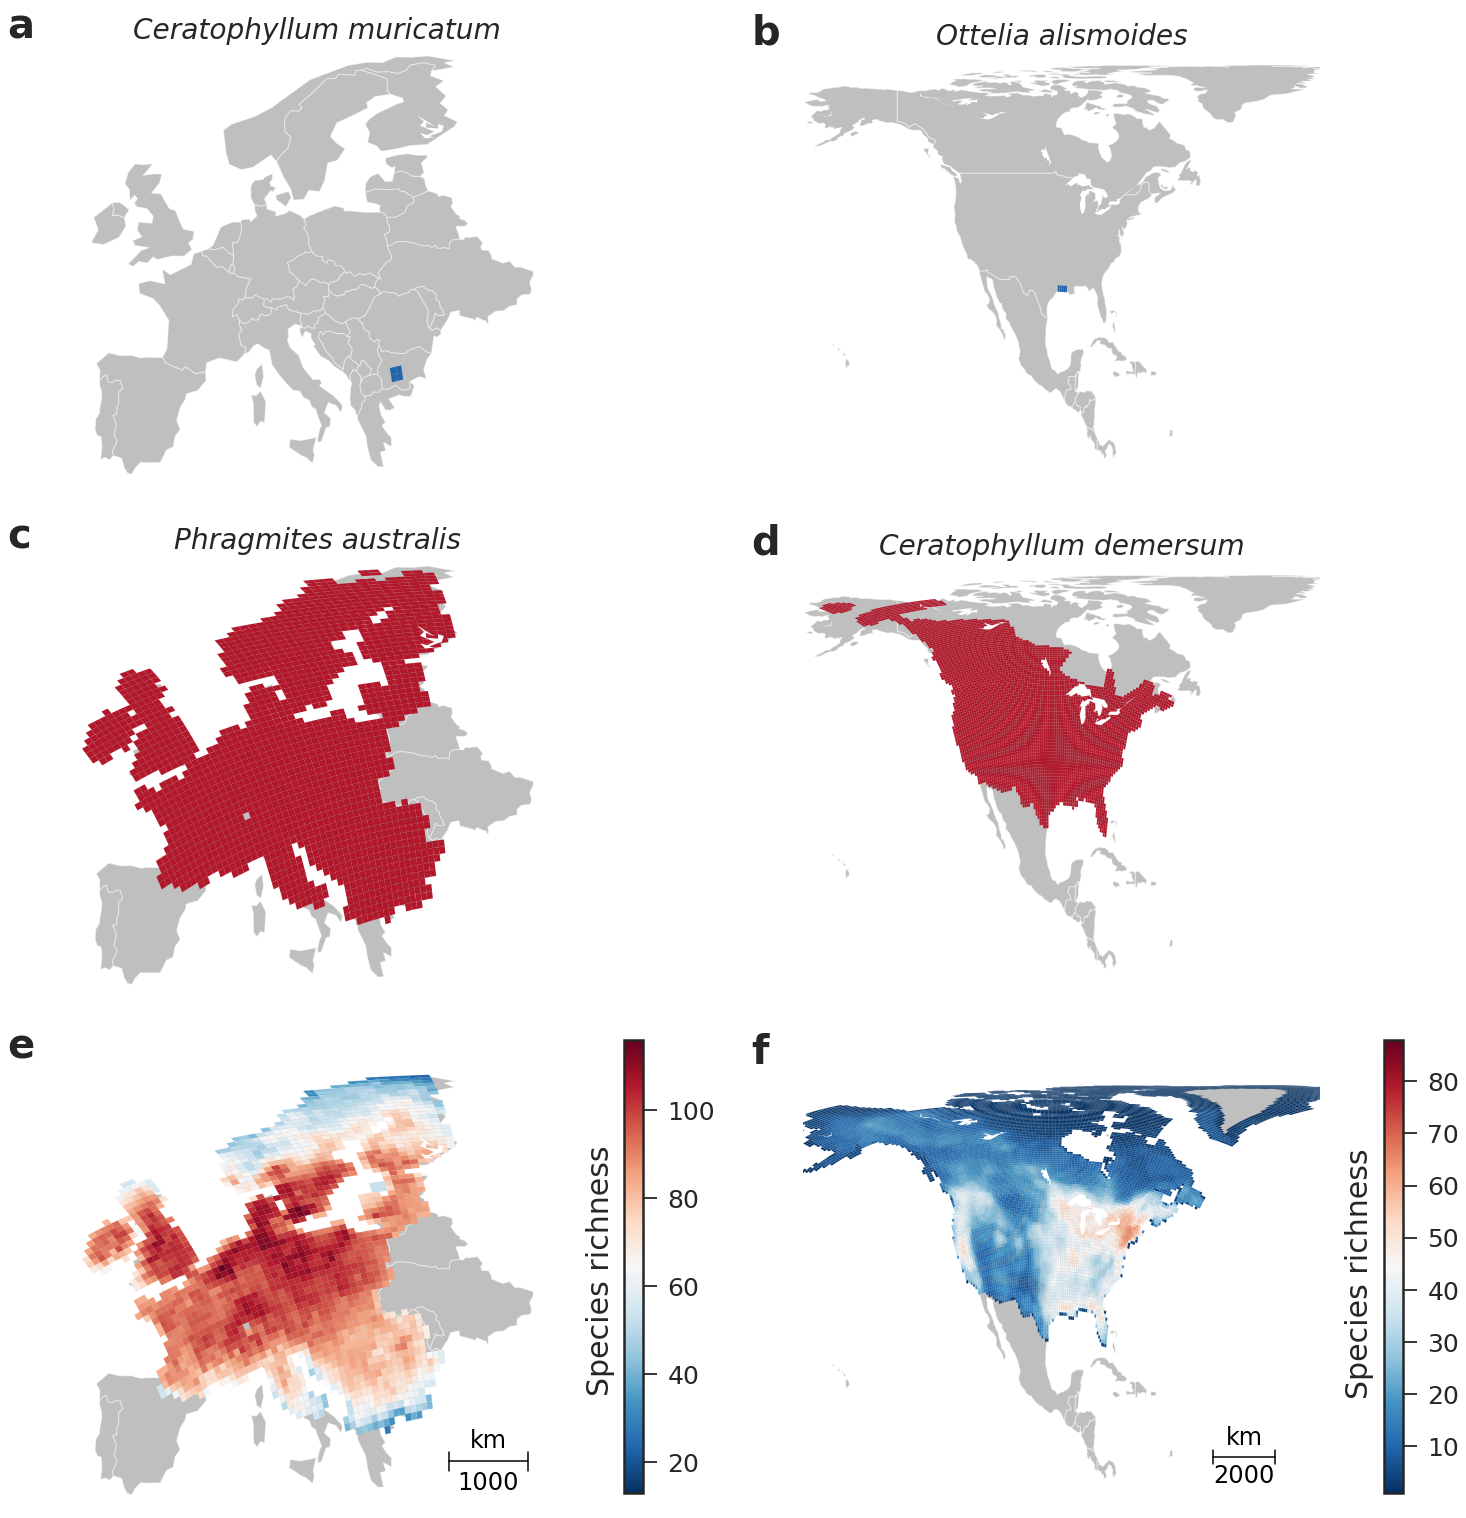

In [259]:
fig, ax = plt.subplots(3, 2, figsize=stdfigsize(ny=3, nx=2))

for i, axs in enumerate(fig.get_axes()):
    axs.annotate(string.ascii_lowercase[i], xy=(-0.1, 1.0), xycoords='axes fraction', fontsize=40, weight='bold')

df_eu = occurrences_within_5050_grid_europe_filtered
df_na = occurrences_within_5050_grid_north_america_filtered



cmap = palettable.colorbrewer.diverging.RdBu_11_r.mpl_colormap
mred, mblue = '#b2182b', '#2166ac'

# im_1 = ax[2,0].imshow(np.random.random((10,10)), vmin=df_eu['Total'].min(), vmax=df_eu['Total'].max(), cmap=cmap)  
# im_2 = ax[2,1].imshow(np.random.random((10,10)), vmin=df_na['Total'].min(), vmax=df_na['Total'].max(), cmap=cmap)  

[world[(world['continent'] == 'Europe') & (world['name'] != 'Russia')].to_crs(cea_proj_dict).plot(color='grey', edgecolor='white', alpha=0.5, ax=ax[i,0]) for i in range(3)]

eu_min = df_eu[df_eu.columns[:-8]].sum(axis=0)[df_eu[df_eu.columns[:-8]].sum(axis=0) == df_eu[df_eu.columns[:-8]].sum(axis=0).min()].index[0]
eu_max = df_eu[df_eu.columns[:-8]].sum(axis=0)[df_eu[df_eu.columns[:-8]].sum(axis=0) == df_eu[df_eu.columns[:-8]].sum(axis=0).max()].index[0]

df_eu[df_eu[eu_min] == 1][[eu_min, 'geometry']].to_crs(cea_proj_dict).plot(lw=0, ax=ax[0,0], color=mblue)
df_eu[df_eu[eu_max] == 1][[eu_max, 'geometry']].to_crs(cea_proj_dict).plot(lw=0, ax=ax[1,0], color=mred)
df_eu.to_crs(cea_proj_dict).plot(ax=ax[2,0], column='Total', vmin=df_na['Total'].min(), vmax=df_eu['Total'].max(), cmap=cmap, lw=0)


[world[(world['continent'] == 'North America')].to_crs(cea_proj_dict).plot(color='grey', edgecolor='white', alpha=0.5, ax=ax[i,1]) for i in range(3)]

na_min = df_na[df_na.columns[:-8]].sum(axis=0)[df_na[df_na.columns[:-8]].sum(axis=0) == df_na[df_na.columns[:-8]].sum(axis=0).min()].index[0]

na_max = df_na[df_na.columns[:-8]].sum(axis=0)[df_na[df_na.columns[:-8]].sum(axis=0) == df_na[df_na.columns[:-8]].sum(axis=0).max()].index[0]

df_na[df_na[na_min] == 1][[na_min, 'geometry']].to_crs(cea_proj_dict).plot(lw=0, ax=ax[0,1], color=mblue)
df_na[df_na[na_max] == 1][[na_max, 'geometry']].to_crs(cea_proj_dict).plot(lw=0, ax=ax[1,1], color=mred)
df_na.to_crs(cea_proj_dict).plot(ax=ax[2,1], column='Total', vmin=df_na['Total'].min(), vmax=df_eu['Total'].max(), cmap=cmap, lw=0)

# centroid_eu_min =  [i[0] for i in df_eu[df_eu[eu_min] == 1][[eu_min, 'geometry']].dissolve(eu_min).centroid.iloc[0].coords.xy]
# centroid_na_min =  [i[0] for i in df_na[df_na[na_min] == 1][[eu_min, 'geometry']].dissolve(eu_min).centroid.iloc[0].coords.xy]

# circle_eu = plt.Circle(centroid_eu_min, 3, color=mblue, fill=False, lw=5)
# circle_na = plt.Circle(centroid_na_min, 5, color=mblue, fill=False, lw=5)

# ax[0,0].add_patch(circle_eu)
# ax[0,1].add_patch(circle_na)

ax[0,0].set_title(final_filtered_sp_eu[final_filtered_sp_eu['codes'] == float(eu_min)]['specie'].iloc[0], pad=-1, style='italic')
ax[1,0].set_title(final_filtered_sp_eu[final_filtered_sp_eu['codes'] == float(eu_max)]['specie'].iloc[0], pad=-1, style='italic')

ax[0,1].set_title(final_filtered_sp_na[final_filtered_sp_na['codes'] == float(na_min)]['specie'].iloc[0], pad=-1, style='italic')
ax[1,1].set_title(final_filtered_sp_na[final_filtered_sp_na['codes'] == float(na_max)]['specie'].iloc[0], pad=-1, style='italic')


ax[2,0].annotate('Species richness', xy=(1.02,0.75), xycoords='axes fraction', fontsize=30, rotation=90)
ax[2,1].annotate('Species richness', xy=(1.05,0.75), xycoords='axes fraction', fontsize=30, rotation=90)

c = 0
for axs in ax.flat:
    
    m = Basemap(projection='cea', # cylindrical equal-area projection
         resolution='c',
         ax=axs
        )
    m.fillcontinents(color='none')
    
    axs.set_aspect(2.3)
    
    if c % 2 == 0:
        eu_xlim = [18.5e6, 25e6]
        eu_ylim = [10.1e6, 12.5e6]
        
        axs.set_xlim(*eu_xlim)
        axs.set_ylim(*eu_ylim)
         
        if c == 4:
            m.drawmapscale(lon=35, lat=38, lat0=0, lon0=0, length=1000, fontsize=24, yoffset=5e4);
            
    else:
        na_xlim = [1.3e6, 18e6]
        na_ylim = [7e6, 13e6]

        axs.set_xlim(*na_xlim)
        axs.set_ylim(*na_ylim)
        
        if c == 5:
            m.drawmapscale(lon=-40, lat=10, lat0=45, lon0=-100, length=2000, fontsize=24, yoffset=1e5);

    
    c += 1

    
fig.subplots_adjust(right=0.7)
cbar_ax_1 = fig.add_axes([0.45, 0.02, 0.015, 0.30])
cbar_ax_2 = fig.add_axes([1.03, 0.02, 0.015, 0.30])
fig.colorbar(im_1, cax=cbar_ax_1)
fig.colorbar(im_2, cax=cbar_ax_2)

axis_aesthetics(fig, rm_list=['left', 'top', 'right', 'bottom'])

fig.tight_layout(w_pad=20, h_pad=5)
# fig.savefig('../figures/species_richness_5050_cea.pdf', bbox_inches='tight')
# fig.savefig('../figures/species_richness_5050_cea.png', bbox_inches='tight')

# Comparisons between 50 $𝑘𝑚^2$, 100 $𝑘𝑚^2$, and 200 $𝑘𝑚^2$ for features distributions in overlapping areas
<a id="comparisons-between"></a>
<a href="#summary">Summary</a>

## Checking pairs of species in all scales
<a id="checking-pairs"></a>
<a href="#summary">Summary</a>

Due to the slightly increase in pairs overlapping considering higher spatial scales, we select the pairs concerning the smallest spatial scale, i.e., 50x50.

In [137]:
def fix_scaled_overlaped_pairs(df_ref, df_to_fix):
    return df_to_fix.merge(df_ref[['sp1', 'sp2']], how='inner', on=['sp1', 'sp2'])

### Europe
<a id="checking-pairs-europe"></a>
<a href="#summary">Summary</a>

In [138]:
overlap_features_100100_europe = fix_scaled_overlaped_pairs(overlap_features_5050_europe, overlap_features_100100_europe)
overlap_features_200200_europe = fix_scaled_overlaped_pairs(overlap_features_5050_europe, overlap_features_200200_europe)

In [139]:
overlap_features_100100_europe_weck4 = fix_scaled_overlaped_pairs(overlap_features_5050_europe_weck4, overlap_features_100100_europe_weck4)
overlap_features_200200_europe_weck4 = fix_scaled_overlaped_pairs(overlap_features_5050_europe_weck4, overlap_features_200200_europe_weck4)

In [140]:
[
    (overlap_features_5050_europe[['sp1', 'sp2']]   == overlap_features_100100_europe[['sp1', 'sp2']]).all(axis=1).all(),
    (overlap_features_5050_europe[['sp1', 'sp2']]   == overlap_features_200200_europe[['sp1', 'sp2']]).all(axis=1).all(),
    (overlap_features_100100_europe[['sp1', 'sp2']] == overlap_features_200200_europe[['sp1', 'sp2']]).all(axis=1).all(),
]

[True, True, True]

In [141]:
[
    (overlap_features_5050_europe_weck4[['sp1', 'sp2']]   == overlap_features_100100_europe_weck4[['sp1', 'sp2']]).all(axis=1).all(),
    (overlap_features_5050_europe_weck4[['sp1', 'sp2']]   == overlap_features_200200_europe_weck4[['sp1', 'sp2']]).all(axis=1).all(),
    (overlap_features_100100_europe_weck4[['sp1', 'sp2']] == overlap_features_200200_europe_weck4[['sp1', 'sp2']]).all(axis=1).all(),
]

[True, True, True]

In [142]:
[
    (overlap_features_5050_europe[['sp1', 'sp2']]   == overlap_features_5050_europe_weck4[['sp1', 'sp2']]).all(axis=1).all(),
    (overlap_features_100100_europe[['sp1', 'sp2']] == overlap_features_100100_europe_weck4[['sp1', 'sp2']]).all(axis=1).all(),
    (overlap_features_200200_europe[['sp1', 'sp2']] == overlap_features_200200_europe_weck4[['sp1', 'sp2']]).all(axis=1).all(),
]

[True, True, True]

In [143]:
[
    (overlap_features_5050_europe[['sp1', 'sp2']]  == overlap_features_100100_europe_weck4[['sp1', 'sp2']]).all(axis=1).all(),
    (overlap_features_5050_europe[['sp1', 'sp2']]  == overlap_features_200200_europe_weck4[['sp1', 'sp2']]).all(axis=1).all(),
    (overlap_features_100100_europe[['sp1', 'sp2']] == overlap_features_200200_europe_weck4[['sp1', 'sp2']]).all(axis=1).all(),
]

[True, True, True]

In [144]:
[
    (overlap_features_5050_europe[['codes1', 'codes2']]   == overlap_features_100100_europe[['codes1', 'codes2']]).all(axis=1).all(),
    (overlap_features_5050_europe[['codes1', 'codes2']]   == overlap_features_200200_europe[['codes1', 'codes2']]).all(axis=1).all(),
    (overlap_features_100100_europe[['codes1', 'codes2']] == overlap_features_200200_europe[['codes1', 'codes2']]).all(axis=1).all(),
]

[True, True, True]

In [145]:
[
    (overlap_features_5050_europe_weck4[['codes1', 'codes2']]   == overlap_features_100100_europe_weck4[['codes1', 'codes2']]).all(axis=1).all(),
    (overlap_features_5050_europe_weck4[['codes1', 'codes2']]   == overlap_features_200200_europe_weck4[['codes1', 'codes2']]).all(axis=1).all(),
    (overlap_features_100100_europe_weck4[['codes1', 'codes2']] == overlap_features_200200_europe_weck4[['codes1', 'codes2']]).all(axis=1).all(),
]

[True, True, True]

In [146]:
[
    (overlap_features_5050_europe[['codes1', 'codes2']] == overlap_features_5050_europe_weck4[['codes1', 'codes2']]).all(axis=1).all(),
    (overlap_features_5050_europe[['codes1', 'codes2']] == overlap_features_100100_europe_weck4[['codes1', 'codes2']]).all(axis=1).all(),
    (overlap_features_5050_europe[['codes1', 'codes2']] == overlap_features_200200_europe_weck4[['codes1', 'codes2']]).all(axis=1).all(),
]

[True, True, True]

In [147]:
[
    (overlap_features_100100_europe[['codes1', 'codes2']] == overlap_features_5050_europe_weck4[['codes1', 'codes2']]).all(axis=1).all(),
    (overlap_features_100100_europe[['codes1', 'codes2']] == overlap_features_100100_europe_weck4[['codes1', 'codes2']]).all(axis=1).all(),
    (overlap_features_100100_europe[['codes1', 'codes2']] == overlap_features_200200_europe_weck4[['codes1', 'codes2']]).all(axis=1).all(),
]

[True, True, True]

In [148]:
[
    (overlap_features_200200_europe[['codes1', 'codes2']] == overlap_features_5050_europe_weck4[['codes1', 'codes2']]).all(axis=1).all(),
    (overlap_features_200200_europe[['codes1', 'codes2']] == overlap_features_100100_europe_weck4[['codes1', 'codes2']]).all(axis=1).all(),
    (overlap_features_200200_europe[['codes1', 'codes2']] == overlap_features_200200_europe_weck4[['codes1', 'codes2']]).all(axis=1).all(),
]

[True, True, True]

### North America
<a id="checking-pairs-north-america"></a>
<a href="#summary">Summary</a>

In [149]:
def set_diff(arr1, arr2):
    if arr1.shape[0] > arr2.shape[0]:
        a1 = arr1
        a2 = arr2
    else:
        a1 = arr2
        a2 = arr1
        
    a1_rows = set(map(tuple, a1))
    a2_rows = set(map(tuple, a2))
    
    return a1_rows.difference(a2_rows), arr1.shape[0], arr2.shape[0]

In [150]:
overlap_features_100100_north_america = fix_scaled_overlaped_pairs(overlap_features_5050_north_america, overlap_features_100100_north_america)
overlap_features_200200_north_america = fix_scaled_overlaped_pairs(overlap_features_5050_north_america, overlap_features_200200_north_america)

In [151]:
[
    (overlap_features_5050_north_america[['sp1', 'sp2']]   == overlap_features_100100_north_america[['sp1', 'sp2']]).all(axis=1).all(),
    (overlap_features_5050_north_america[['sp1', 'sp2']]   == overlap_features_200200_north_america[['sp1', 'sp2']]).all(axis=1).all(),
    (overlap_features_100100_north_america[['sp1', 'sp2']] == overlap_features_200200_north_america[['sp1', 'sp2']]).all(axis=1).all(),
]

[True, True, True]

In [152]:
overlap_features_5050_north_america.shape, overlap_features_100100_north_america.shape, overlap_features_200200_north_america.shape

((545, 20), (545, 20), (545, 20))

In [153]:
overlap_features_100100_north_america_weck4 = fix_scaled_overlaped_pairs(overlap_features_5050_north_america_weck4, overlap_features_100100_north_america_weck4)
overlap_features_200200_north_america_weck4 = fix_scaled_overlaped_pairs(overlap_features_5050_north_america_weck4, overlap_features_200200_north_america_weck4)

In [154]:
[
    (overlap_features_5050_north_america_weck4[['sp1', 'sp2']]   == overlap_features_100100_north_america_weck4[['sp1', 'sp2']]).all(axis=1).all(),
    (overlap_features_5050_north_america_weck4[['sp1', 'sp2']]   == overlap_features_200200_north_america_weck4[['sp1', 'sp2']]).all(axis=1).all(),
    (overlap_features_100100_north_america_weck4[['sp1', 'sp2']] == overlap_features_200200_north_america_weck4[['sp1', 'sp2']]).all(axis=1).all(),
]

[True, True, True]

In [155]:
overlap_features_5050_north_america_weck4.shape, overlap_features_100100_north_america_weck4.shape, overlap_features_200200_north_america_weck4.shape

((544, 14), (544, 14), (544, 14))

In [156]:
overlap_features_5050_north_america = overlap_features_5050_north_america[~(overlap_features_5050_north_america['codes1'].isin(['52', '64']) & overlap_features_5050_north_america['codes2'].isin(['58', '68']))].reset_index(drop=True)

In [157]:
overlap_features_100100_north_america = fix_scaled_overlaped_pairs(overlap_features_5050_north_america, overlap_features_100100_north_america)
overlap_features_200200_north_america = fix_scaled_overlaped_pairs(overlap_features_5050_north_america, overlap_features_200200_north_america)

overlap_features_5050_north_america_weck4   = fix_scaled_overlaped_pairs(overlap_features_5050_north_america, overlap_features_5050_north_america_weck4)
overlap_features_100100_north_america_weck4 = fix_scaled_overlaped_pairs(overlap_features_5050_north_america, overlap_features_100100_north_america_weck4)
overlap_features_200200_north_america_weck4 = fix_scaled_overlaped_pairs(overlap_features_5050_north_america, overlap_features_200200_north_america_weck4)

In [158]:
[
    (overlap_features_5050_north_america[['sp1', 'sp2']]   == overlap_features_100100_north_america[['sp1', 'sp2']]).all(axis=1).all(),
    (overlap_features_5050_north_america[['sp1', 'sp2']]   == overlap_features_200200_north_america[['sp1', 'sp2']]).all(axis=1).all(),
    (overlap_features_100100_north_america[['sp1', 'sp2']] == overlap_features_200200_north_america[['sp1', 'sp2']]).all(axis=1).all(),
]

[True, True, True]

In [159]:
[
    (overlap_features_5050_north_america_weck4[['sp1', 'sp2']]   == overlap_features_100100_north_america_weck4[['sp1', 'sp2']]).all(axis=1).all(),
    (overlap_features_5050_north_america_weck4[['sp1', 'sp2']]   == overlap_features_200200_north_america_weck4[['sp1', 'sp2']]).all(axis=1).all(),
    (overlap_features_100100_north_america_weck4[['sp1', 'sp2']] == overlap_features_200200_north_america_weck4[['sp1', 'sp2']]).all(axis=1).all(),
]

[True, True, True]

In [160]:
[
    (overlap_features_5050_north_america[['sp1', 'sp2']]   == overlap_features_5050_north_america_weck4[['sp1', 'sp2']]).all(axis=1).all(),
    (overlap_features_100100_north_america[['sp1', 'sp2']] == overlap_features_100100_north_america_weck4[['sp1', 'sp2']]).all(axis=1).all(),
    (overlap_features_200200_north_america[['sp1', 'sp2']] == overlap_features_200200_north_america_weck4[['sp1', 'sp2']]).all(axis=1).all(),
]

[True, True, True]

In [161]:
[
    (overlap_features_5050_north_america[['sp1', 'sp2']]  == overlap_features_100100_north_america_weck4[['sp1', 'sp2']]).all(axis=1).all(),
    (overlap_features_5050_north_america[['sp1', 'sp2']]  == overlap_features_200200_north_america_weck4[['sp1', 'sp2']]).all(axis=1).all(),
    (overlap_features_100100_north_america[['sp1', 'sp2']] == overlap_features_200200_north_america_weck4[['sp1', 'sp2']]).all(axis=1).all(),
]

[True, True, True]

In [162]:
[
    (overlap_features_5050_north_america[['codes1', 'codes2']]   == overlap_features_100100_north_america[['codes1', 'codes2']]).all(axis=1).all(),
    (overlap_features_5050_north_america[['codes1', 'codes2']]   == overlap_features_200200_north_america[['codes1', 'codes2']]).all(axis=1).all(),
    (overlap_features_100100_north_america[['codes1', 'codes2']] == overlap_features_200200_north_america[['codes1', 'codes2']]).all(axis=1).all(),
]

[True, True, True]

In [163]:
[
    (overlap_features_5050_north_america_weck4[['codes1', 'codes2']]   == overlap_features_100100_north_america_weck4[['codes1', 'codes2']]).all(axis=1).all(),
    (overlap_features_5050_north_america_weck4[['codes1', 'codes2']]   == overlap_features_200200_north_america_weck4[['codes1', 'codes2']]).all(axis=1).all(),
    (overlap_features_100100_north_america_weck4[['codes1', 'codes2']] == overlap_features_200200_north_america_weck4[['codes1', 'codes2']]).all(axis=1).all(),
]

[True, True, True]

In [164]:
[
    (overlap_features_5050_north_america[['codes1', 'codes2']] == overlap_features_5050_north_america_weck4[['codes1', 'codes2']]).all(axis=1).all(),
    (overlap_features_5050_north_america[['codes1', 'codes2']] == overlap_features_100100_north_america_weck4[['codes1', 'codes2']]).all(axis=1).all(),
    (overlap_features_5050_north_america[['codes1', 'codes2']] == overlap_features_200200_north_america_weck4[['codes1', 'codes2']]).all(axis=1).all(),
]

[True, True, True]

In [165]:
[
    (overlap_features_100100_north_america[['codes1', 'codes2']] == overlap_features_5050_north_america_weck4[['codes1', 'codes2']]).all(axis=1).all(),
    (overlap_features_100100_north_america[['codes1', 'codes2']] == overlap_features_100100_north_america_weck4[['codes1', 'codes2']]).all(axis=1).all(),
    (overlap_features_100100_north_america[['codes1', 'codes2']] == overlap_features_200200_north_america_weck4[['codes1', 'codes2']]).all(axis=1).all(),
]

[True, True, True]

In [166]:
[
    (overlap_features_200200_north_america[['codes1', 'codes2']] == overlap_features_5050_north_america_weck4[['codes1', 'codes2']]).all(axis=1).all(),
    (overlap_features_200200_north_america[['codes1', 'codes2']] == overlap_features_100100_north_america_weck4[['codes1', 'codes2']]).all(axis=1).all(),
    (overlap_features_200200_north_america[['codes1', 'codes2']] == overlap_features_200200_north_america_weck4[['codes1', 'codes2']]).all(axis=1).all(),
]

[True, True, True]

### Europe (common)
<a id="checking-pairs-europe-common"></a>
<a href="#summary">Summary</a>

In [167]:
[
    (overlap_features_5050_europe_common[['codes1', 'codes2']]   == overlap_features_100100_europe_common[['codes1', 'codes2']]).all(axis=1).all(),
    (overlap_features_5050_europe_common[['codes1', 'codes2']]   == overlap_features_200200_europe_common[['codes1', 'codes2']]).all(axis=1).all(),
    (overlap_features_100100_europe_common[['codes1', 'codes2']] == overlap_features_200200_europe_common[['codes1', 'codes2']]).all(axis=1).all(),
]

[True, True, True]

In [168]:
[
    (overlap_features_5050_europe_weck4_common[['codes1', 'codes2']]   == overlap_features_100100_europe_weck4_common[['codes1', 'codes2']]).all(axis=1).all(),
    (overlap_features_5050_europe_weck4_common[['codes1', 'codes2']]   == overlap_features_200200_europe_weck4_common[['codes1', 'codes2']]).all(axis=1).all(),
    (overlap_features_100100_europe_weck4_common[['codes1', 'codes2']] == overlap_features_200200_europe_weck4_common[['codes1', 'codes2']]).all(axis=1).all(),
]

[True, True, True]

In [169]:
[
    (overlap_features_5050_europe_common[['codes1', 'codes2']] == overlap_features_5050_europe_weck4_common[['codes1', 'codes2']]).all(axis=1).all(),
    (overlap_features_5050_europe_common[['codes1', 'codes2']] == overlap_features_100100_europe_weck4_common[['codes1', 'codes2']]).all(axis=1).all(),
    (overlap_features_5050_europe_common[['codes1', 'codes2']] == overlap_features_200200_europe_weck4_common[['codes1', 'codes2']]).all(axis=1).all(),
]

[True, True, True]

In [170]:
[
    (overlap_features_100100_europe_common[['codes1', 'codes2']] == overlap_features_5050_europe_weck4_common[['codes1', 'codes2']]).all(axis=1).all(),
    (overlap_features_100100_europe_common[['codes1', 'codes2']] == overlap_features_100100_europe_weck4_common[['codes1', 'codes2']]).all(axis=1).all(),
    (overlap_features_100100_europe_common[['codes1', 'codes2']] == overlap_features_200200_europe_weck4_common[['codes1', 'codes2']]).all(axis=1).all(),
]

[True, True, True]

In [171]:
[
    (overlap_features_200200_europe_common[['codes1', 'codes2']] == overlap_features_5050_europe_weck4_common[['codes1', 'codes2']]).all(axis=1).all(),
    (overlap_features_200200_europe_common[['codes1', 'codes2']] == overlap_features_100100_europe_weck4_common[['codes1', 'codes2']]).all(axis=1).all(),
    (overlap_features_200200_europe_common[['codes1', 'codes2']] == overlap_features_200200_europe_weck4_common[['codes1', 'codes2']]).all(axis=1).all(),
]

[True, True, True]

### North America (common)
<a id="checking-pairs-north-america-common"></a>
<a href="#summary">Summary</a>

In [172]:
[
    (overlap_features_5050_north_america_common[['codes1', 'codes2']]   == overlap_features_100100_north_america_common[['codes1', 'codes2']]).all(axis=1).all(),
    (overlap_features_5050_north_america_common[['codes1', 'codes2']]   == overlap_features_200200_north_america_common[['codes1', 'codes2']]).all(axis=1).all(),
    (overlap_features_100100_north_america_common[['codes1', 'codes2']] == overlap_features_200200_north_america_common[['codes1', 'codes2']]).all(axis=1).all(),
]

[True, True, True]

In [173]:
[
    (overlap_features_5050_north_america_weck4_common[['codes1', 'codes2']]   == overlap_features_100100_north_america_weck4_common[['codes1', 'codes2']]).all(axis=1).all(),
    (overlap_features_5050_north_america_weck4_common[['codes1', 'codes2']]   == overlap_features_200200_north_america_weck4_common[['codes1', 'codes2']]).all(axis=1).all(),
    (overlap_features_100100_north_america_weck4_common[['codes1', 'codes2']] == overlap_features_200200_north_america_weck4_common[['codes1', 'codes2']]).all(axis=1).all(),
]

[True, True, True]

In [174]:
[
    (overlap_features_5050_north_america_common[['codes1', 'codes2']] == overlap_features_5050_north_america_weck4_common[['codes1', 'codes2']]).all(axis=1).all(),
    (overlap_features_5050_north_america_common[['codes1', 'codes2']] == overlap_features_100100_north_america_weck4_common[['codes1', 'codes2']]).all(axis=1).all(),
    (overlap_features_5050_north_america_common[['codes1', 'codes2']] == overlap_features_200200_north_america_weck4_common[['codes1', 'codes2']]).all(axis=1).all(),
]

[True, True, True]

In [175]:
[
    (overlap_features_100100_north_america_common[['codes1', 'codes2']] == overlap_features_5050_north_america_weck4_common[['codes1', 'codes2']]).all(axis=1).all(),
    (overlap_features_100100_north_america_common[['codes1', 'codes2']] == overlap_features_100100_north_america_weck4_common[['codes1', 'codes2']]).all(axis=1).all(),
    (overlap_features_100100_north_america_common[['codes1', 'codes2']] == overlap_features_200200_north_america_weck4_common[['codes1', 'codes2']]).all(axis=1).all(),
]

[True, True, True]

In [176]:
[
    (overlap_features_200200_north_america_common[['codes1', 'codes2']] == overlap_features_5050_north_america_weck4_common[['codes1', 'codes2']]).all(axis=1).all(),
    (overlap_features_200200_north_america_common[['codes1', 'codes2']] == overlap_features_100100_north_america_weck4_common[['codes1', 'codes2']]).all(axis=1).all(),
    (overlap_features_200200_north_america_common[['codes1', 'codes2']] == overlap_features_200200_north_america_weck4_common[['codes1', 'codes2']]).all(axis=1).all(),
]

[True, True, True]

# Number of pairs considering sympatry intervals
<a id="number-of-pairs"></a>
<a href="#summary">Summary</a>

In [177]:
sl = [0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0]

# europe
# 50km
europe_sympn_5050_less = pd.DataFrame([[s, s, overlap_features_5050_europe[overlap_features_5050_europe['sympatry_grids'] <= s].shape[0]] for s in sl], columns=['symp', 'overlap', 'n'])#.set_index('symp')
europe_sympn_5050_great = pd.DataFrame([[s, 1-s, overlap_features_5050_europe[overlap_features_5050_europe['sympatry_grids'] >= 1-s].shape[0]] for s in sl], columns=['symp', 'overlap', 'n'])#.set_index('symp')
# 100km
europe_sympn_100100_less = pd.DataFrame([[s, s, overlap_features_100100_europe[overlap_features_100100_europe['sympatry_grids'] <= s].shape[0]] for s in sl], columns=['symp', 'overlap', 'n'])#.set_index('symp')
europe_sympn_100100_great = pd.DataFrame([[s, 1-s, overlap_features_100100_europe[overlap_features_100100_europe['sympatry_grids'] >= 1-s].shape[0]] for s in sl], columns=['symp', 'overlap', 'n'])#.set_index('symp')
# 200km
europe_sympn_200200_less = pd.DataFrame([[s, s, overlap_features_200200_europe[overlap_features_200200_europe['sympatry_grids'] <= s].shape[0]] for s in sl], columns=['symp', 'overlap', 'n'])#.set_index('symp')
europe_sympn_200200_great = pd.DataFrame([[s, 1-s, overlap_features_200200_europe[overlap_features_200200_europe['sympatry_grids'] >= 1-s].shape[0]] for s in sl], columns=['symp', 'overlap', 'n'])#.set_index('symp')

# north america
# 50km
north_america_sympn_5050_less = pd.DataFrame([[s, s, overlap_features_5050_north_america[overlap_features_5050_north_america['sympatry_grids'] <= s].shape[0]] for s in sl], columns=['symp', 'overlap', 'n'])#.set_index('symp')
north_america_sympn_5050_great = pd.DataFrame([[s, 1-s, overlap_features_5050_north_america[overlap_features_5050_north_america['sympatry_grids'] >= 1-s].shape[0]] for s in sl], columns=['symp', 'overlap', 'n'])#.set_index('symp')
# 100km
north_america_sympn_100100_less = pd.DataFrame([[s, s, overlap_features_100100_north_america[overlap_features_100100_north_america['sympatry_grids'] <= s].shape[0]] for s in sl], columns=['symp', 'overlap', 'n'])#.set_index('symp')
north_america_sympn_100100_great = pd.DataFrame([[s, 1-s, overlap_features_100100_north_america[overlap_features_100100_north_america['sympatry_grids'] >= 1-s].shape[0]] for s in sl], columns=['symp', 'overlap', 'n'])#.set_index('symp')
# 200km
north_america_sympn_200200_less = pd.DataFrame([[s, s, overlap_features_200200_north_america[overlap_features_200200_north_america['sympatry_grids'] <= s].shape[0]] for s in sl], columns=['symp', 'overlap', 'n'])#.set_index('symp')
north_america_sympn_200200_great = pd.DataFrame([[s, 1-s, overlap_features_200200_north_america[overlap_features_200200_north_america['sympatry_grids'] >= 1-s].shape[0]] for s in sl], columns=['symp', 'overlap', 'n'])#.set_index('symp')

In [178]:
europe_sympn_5050_less['perc'] = europe_sympn_5050_less['n']/europe_sympn_5050_less['n'].max()
europe_sympn_100100_less['perc'] = europe_sympn_100100_less['n']/europe_sympn_100100_less['n'].max()
europe_sympn_200200_less['perc'] = europe_sympn_200200_less['n']/europe_sympn_200200_less['n'].max()

europe_sympn_5050_great['perc'] = europe_sympn_5050_great['n']/europe_sympn_5050_great['n'].max()
europe_sympn_100100_great['perc'] = europe_sympn_100100_great['n']/europe_sympn_100100_great['n'].max()
europe_sympn_200200_great['perc'] = europe_sympn_200200_great['n']/europe_sympn_200200_great['n'].max()

In [179]:
north_america_sympn_5050_less['perc'] = north_america_sympn_5050_less['n']/north_america_sympn_5050_less['n'].max()
north_america_sympn_100100_less['perc'] = north_america_sympn_100100_less['n']/north_america_sympn_100100_less['n'].max()
north_america_sympn_200200_less['perc'] = north_america_sympn_200200_less['n']/north_america_sympn_200200_less['n'].max()

north_america_sympn_5050_great['perc'] = north_america_sympn_5050_great['n']/north_america_sympn_5050_great['n'].max()
north_america_sympn_100100_great['perc'] = north_america_sympn_100100_great['n']/north_america_sympn_100100_great['n'].max()
north_america_sympn_200200_great['perc'] = north_america_sympn_200200_great['n']/north_america_sympn_200200_great['n'].max()

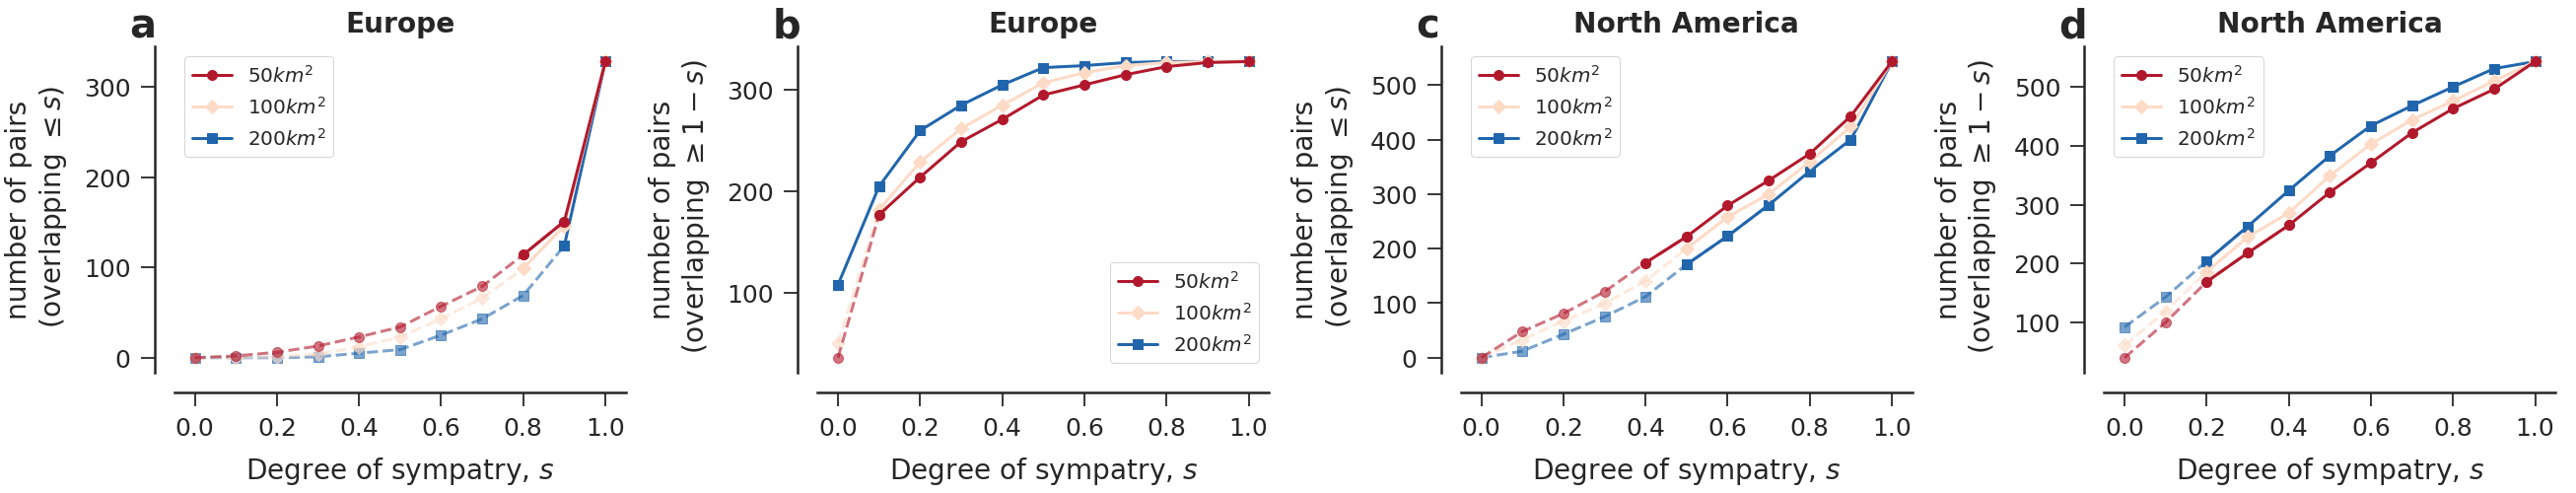

In [181]:
fig, ax = plt.subplots(1, 4, figsize=stdfigsize(ny=1, nx=4))

colors = palettable.colorbrewer.diverging.RdBu_11.mpl_colors
kwargs = dict(lw=3, markersize=10)

p = 0.3

europe_sympn_5050_less[europe_sympn_5050_less['perc'] >= p].plot('symp', 'n', ax=ax[0], marker='o', color=colors[1], **kwargs, zorder=3)
europe_sympn_100100_less[europe_sympn_100100_less['perc'] >= p] .plot('symp', 'n', ax=ax[0], marker='D', color=colors[4], **kwargs, zorder=2)
europe_sympn_200200_less[europe_sympn_200200_less['perc'] >= p].plot('symp', 'n', ax=ax[0], marker='s', color=colors[9], **kwargs, zorder=1)

europe_sympn_5050_less[europe_sympn_5050_less['perc'] <= p+0.2].plot('symp', 'n', ax=ax[0], marker='o', color=colors[1], **kwargs, zorder=3, alpha=0.6, style='--')
europe_sympn_100100_less[europe_sympn_100100_less['perc'] <= p+0.2] .plot('symp', 'n', ax=ax[0], marker='D', color=colors[4], **kwargs, zorder=2, alpha=0.6, style='--')
europe_sympn_200200_less[europe_sympn_200200_less['perc'] <= p+0.1].plot('symp', 'n', ax=ax[0], marker='s', color=colors[9], **kwargs, zorder=1, alpha=0.6, style='--')

europe_sympn_5050_great[europe_sympn_5050_great['perc'] >= p].plot('symp', 'n', ax=ax[1], marker='o', color=colors[1], **kwargs, zorder=3)
europe_sympn_100100_great[europe_sympn_100100_great['perc'] >= p].plot('symp', 'n', ax=ax[1], marker='D', color=colors[4], **kwargs, zorder=2)
europe_sympn_200200_great[europe_sympn_200200_great['perc'] >= p].plot('symp', 'n', ax=ax[1], marker='s', color=colors[9], **kwargs, zorder=1)

europe_sympn_5050_great[europe_sympn_5050_great['perc'] <= p+0.3].plot('symp', 'n', ax=ax[1], marker='o', color=colors[1], **kwargs, zorder=3, alpha=0.6, style='--')
europe_sympn_100100_great[europe_sympn_100100_great['perc'] <= p+0.3].plot('symp', 'n', ax=ax[1], marker='D', color=colors[4], **kwargs, zorder=2, alpha=0.6, style='--')
europe_sympn_200200_great[europe_sympn_200200_great['perc'] <= p+0.3].plot('symp', 'n', ax=ax[1], marker='s', color=colors[9], **kwargs, zorder=1, alpha=0.6, style='--')

north_america_sympn_5050_less[north_america_sympn_5050_less['perc'] >= p].plot('symp', 'n', ax=ax[2], marker='o', color=colors[1], **kwargs, zorder=3)
north_america_sympn_100100_less[north_america_sympn_100100_less['perc'] >= p].plot('symp', 'n', ax=ax[2], marker='D', color=colors[4], **kwargs, zorder=2)
north_america_sympn_200200_less[north_america_sympn_200200_less['perc'] >= p].plot('symp', 'n', ax=ax[2], marker='s', color=colors[9], **kwargs, zorder=1)

north_america_sympn_5050_less[north_america_sympn_5050_less['perc'] <= p+0.2].plot('symp', 'n', ax=ax[2], marker='o', color=colors[1], **kwargs, zorder=3, alpha=0.6, style='--')
north_america_sympn_100100_less[north_america_sympn_100100_less['perc'] <= p+0.2].plot('symp', 'n', ax=ax[2], marker='D', color=colors[4], **kwargs, zorder=2, alpha=0.6, style='--')
north_america_sympn_200200_less[north_america_sympn_200200_less['perc'] <= p+0.3].plot('symp', 'n', ax=ax[2], marker='s', color=colors[9], **kwargs, zorder=1, alpha=0.6, style='--')

north_america_sympn_5050_great[north_america_sympn_5050_great['perc'] >= p].plot('symp', 'n', ax=ax[3], marker='o', color=colors[1], **kwargs, zorder=3)
north_america_sympn_100100_great[north_america_sympn_100100_great['perc'] >= p].plot('symp', 'n', ax=ax[3], marker='D', color=colors[4], **kwargs, zorder=2)
north_america_sympn_200200_great[north_america_sympn_200200_great['perc'] >= p].plot('symp', 'n', ax=ax[3], marker='s', color=colors[9], **kwargs, zorder=1)

north_america_sympn_5050_great[north_america_sympn_5050_great['perc'] <= p+0.2].plot('symp', 'n', ax=ax[3], marker='o', color=colors[1], **kwargs, zorder=3, alpha=0.6, style='--')
north_america_sympn_100100_great[north_america_sympn_100100_great['perc'] <= p+0.2].plot('symp', 'n', ax=ax[3], marker='D', color=colors[4], **kwargs, zorder=2, alpha=0.6, style='--')
north_america_sympn_200200_great[north_america_sympn_200200_great['perc'] <= p+0.2].plot('symp', 'n', ax=ax[3], marker='s', color=colors[9], **kwargs, zorder=1, alpha=0.6, style='--')

c = 0
for ax in ax.flat:
    
    ax.set_title(['Europe', 'Europe', 'North America', 'North America'][c], weight='bold')
    ax.annotate(string.ascii_lowercase[c], xy=(-0.1, 1.03), xycoords='axes fraction', fontsize=40, weight='bold')
    ax.set_xlabel('Degree of sympatry, $s$')
    ax.set_ylabel(['number of pairs\n (overlapping $\\leq s$)', 'number of pairs\n (overlapping $\\geq 1-s$)', 'number of pairs\n (overlapping $\\leq s$)', 'number of pairs\n (overlapping $\\geq 1-s$)'][c])
    ax.legend(['$50km^2$', '$100km^2$', '$200km^2$'])
    ax.set_xlim([-0.05, 1.05])
#     ax.set_ylim([-50,600])

    
    for loc, spine in ax.spines.items():
        if loc in ['left', 'bottom']:
            spine.set_position(('outward', 20)) # outward by 20 points
        elif loc in ['right','top']:
            spine.set_color('none') # don't draw spine
        else:
            raise ValueError('unknown spine location: %s'%loc)

    # Only show ticks on the left and bottom spines
    ax.yaxis.set_ticks_position('left')
    ax.xaxis.set_ticks_position('bottom')
    
    c += 1
    
fig.tight_layout()
# fig.savefig('../figures/pairs_per_symp_new.pdf', bbox_inches='tight')
# fig.savefig('../figures/pairs_per_symp_new.png', bbox_inches='tight')

In [182]:
[
    scipy.stats.ks_2samp(overlap_features_5050_europe['sympatry_grids'], overlap_features_100100_europe['sympatry_grids'])[1],
    scipy.stats.ks_2samp(overlap_features_5050_europe['sympatry_grids'], overlap_features_200200_europe['sympatry_grids'])[1],
    scipy.stats.ks_2samp(overlap_features_100100_europe['sympatry_grids'], overlap_features_200200_europe['sympatry_grids'])[1]
]

[0.12865098972322633, 2.463522386198243e-07, 6.764671795501489e-05]

In [183]:
[
    scipy.stats.ks_2samp(overlap_features_5050_north_america['sympatry_grids'], overlap_features_100100_north_america['sympatry_grids'])[1],
    scipy.stats.ks_2samp(overlap_features_5050_north_america['sympatry_grids'], overlap_features_200200_north_america['sympatry_grids'])[1],
    scipy.stats.ks_2samp(overlap_features_100100_north_america['sympatry_grids'], overlap_features_200200_north_america['sympatry_grids'])[1]
]

[0.20941164033244541, 0.0005068336632979465, 0.09046450155411546]

# Spearman coefficient with shuffling pairs (areas correlation between sister species)
<a id="spearman-coefficient"></a>
<a href="#summary">Summary</a>

In [184]:
def spearman(data):
    """
    Calculates the Pearson correlation coefficient.
    Parameters
    ----------
    data: two-columns numpy array
    ----------
    Returns Pearson.
    """
    data=data.transpose()
    pea=scipy.stats.spearmanr(data[0],data[1])
    return(pea)

In [185]:
# df = north_america_overlay_5050
def spearman_sympatry(df, order, perc_filter=0.3, resample=False, rep=1000, alpha=0.05):
    # columns to use
    cols = ['area1', 'area2']
    if order == 'greater':
        df_size = pd.DataFrame([df[df['sympatry'] >= 1-s].shape[0] for s in np.arange(0, 1.1, 0.1)], columns=['size'])
        df_perc = pd.DataFrame([df[df['sympatry'] >= 1-s].shape[0]/df.shape[0] for s in np.arange(0, 1.1, 0.1)], columns=['perc'])
        df_spea = pd.DataFrame([np.asarray(spearman(np.asarray(df[df['sympatry'] >= 1-s][cols].apply(np.log)))) for s in np.arange(0, 1.1, 0.1)], columns=['spearman', 'pvalue'], index=np.arange(0,110,10)/100).reset_index()
                
        # condition if one wants to resample each pair within the df
        if resample:
            # list to append the mean spearman coefficient and the confidence interval values
            stats_l = []
            # loop through the sympatry values to filter the df
            for s in np.arange(0, 1.1, 0.1):
                # create a temporary array with the values of area1 and area2
                arr_tmp = np.asarray(df[df['sympatry'] >= 1-s][cols].apply(np.log))
                # list to append the values of the spearman coefficient for the resampled df
                spear_l = []
                # loop to shuffle each pair
                for _ in range(rep):
                    # shuffling each pair
                    [np.random.shuffle(arr) for arr in arr_tmp]
                    # append the spearman coefficient to the previous created list
                    spear_l.append(spearman(arr_tmp)[0])

                # transform the spearman coefficients list into an array
                spear_arr = np.asarray(spear_l)

                # calculate the mean value of all spearman coefficients and the confidence interval [5, 95]
                stats_values = np.append(spear_arr.mean(), np.percentile(spear_arr, q=[100*alpha/2, 100*(1-alpha/2)]))
                
                # append the stats values to the stats list
                stats_l.append(stats_values)
            
            df_stats = pd.DataFrame(stats_l, columns=['spearman_mean', 'spearman_5CI', 'spearman_95CI'])
            
            df = pd.concat([df_spea, df_size, df_perc, df_stats], axis=1).dropna()
            df = df[df['perc'] >= perc_filter]
          
        else:
            
            df = pd.concat([df_spea, df_size, df_perc], axis=1).dropna()
            df = df[df['perc'] >= perc_filter]
        
    elif order == 'less':
        df_size = pd.DataFrame([df[df['sympatry'] <= s].shape[0] for s in np.arange(0, 1.1, 0.1)], columns=['size'])
        df_perc = pd.DataFrame([df[df['sympatry'] <= s].shape[0]/df.shape[0] for s in np.arange(0, 1.1, 0.1)], columns=['perc'])
        df_spea = pd.DataFrame([np.asarray(spearman(np.asarray(df[df['sympatry'] <= s][cols].apply(np.log)))) for s in np.arange(0, 1.1, 0.1)], columns=['spearman', 'pvalue'], index=np.arange(0,110,10)/100).reset_index()
        
          # condition if one wants to resample each pair within the df
        if resample:
            # list to append the mean spearman coefficient and the confidence interval values
            stats_l = []
            # loop through the sympatry values to filter the df
            for s in np.arange(0, 1.1, 0.1):
                # create a temporary array with the values of area1 and area2
                arr_tmp = np.asarray(df[df['sympatry'] <= s][cols].apply(np.log))
                # list to append the values of the spearman coefficient for the resampled df
                spear_l = []
                # loop to shuffle each pair
                for _ in range(rep):
                    # shuffling each pair
                    [np.random.shuffle(arr) for arr in arr_tmp]
                    # append the spearman coefficient to the previous created list
                    spear_l.append(spearman(arr_tmp)[0])

                # transform the spearman coefficients list into an array
                spear_arr = np.asarray(spear_l)

                # calculate the mean value of all spearman coefficients and the confidence interval [5, 95]
                stats_values = np.append(spear_arr.mean(), np.percentile(spear_arr, q=[100*alpha/2, 100*(1-alpha/2)]))
                
                # append the stats values to the stats list
                stats_l.append(stats_values)
            
            df_stats = pd.DataFrame(stats_l, columns=['spearman_mean', 'spearman_5CI', 'spearman_95CI'])
            
            df = pd.concat([df_spea, df_size, df_perc, df_stats], axis=1).dropna()
            df = df[df['perc'] >= perc_filter]
            
        else:
            df = pd.concat([df_spea, df_size, df_perc], axis=1).dropna()
            df = df[df['perc'] >= perc_filter]
            
    else:
        raise ValueError('unknown order value: {}'.format(order))
        
    return df

In [186]:
def size_corr(df, s):
    _df = df[df['sympatry_grids'] >= s]
    corr = _df[['area1', 'area2']].apply(np.log).corr(method='spearman').iloc[0][1]
    
    return _df.shape[0], corr

In [187]:
europe_overlay_5050_greater_sympatry_spearman_shuffle   = spearman_sympatry(overlap_features_5050_europe,   order='greater', resample=True)
europe_overlay_100100_greater_sympatry_spearman_shuffle = spearman_sympatry(overlap_features_100100_europe, order='greater', resample=True)
europe_overlay_200200_greater_sympatry_spearman_shuffle = spearman_sympatry(overlap_features_200200_europe, order='greater', resample=True)

europe_overlay_5050_less_sympatry_spearman_shuffle   = spearman_sympatry(overlap_features_5050_europe,   order='less', resample=True)
europe_overlay_100100_less_sympatry_spearman_shuffle = spearman_sympatry(overlap_features_100100_europe, order='less', resample=True)
europe_overlay_200200_less_sympatry_spearman_shuffle = spearman_sympatry(overlap_features_200200_europe, order='less', resample=True)

europe_overlay_5050_common_greater_sympatry_spearman_shuffle   = spearman_sympatry(overlap_features_5050_europe_common,   order='greater', resample=True)
europe_overlay_100100_common_greater_sympatry_spearman_shuffle = spearman_sympatry(overlap_features_100100_europe_common, order='greater', resample=True)
europe_overlay_200200_common_greater_sympatry_spearman_shuffle = spearman_sympatry(overlap_features_200200_europe_common, order='greater', resample=True)

europe_overlay_5050_common_less_sympatry_spearman_shuffle   = spearman_sympatry(overlap_features_5050_europe_common,   order='less', resample=True)
europe_overlay_100100_common_less_sympatry_spearman_shuffle = spearman_sympatry(overlap_features_100100_europe_common, order='less', resample=True)
europe_overlay_200200_common_less_sympatry_spearman_shuffle = spearman_sympatry(overlap_features_200200_europe_common, order='less', resample=True)

In [188]:
north_america_overlay_5050_greater_sympatry_spearman_shuffle   = spearman_sympatry(overlap_features_5050_north_america,   order='greater', resample=True)
north_america_overlay_100100_greater_sympatry_spearman_shuffle = spearman_sympatry(overlap_features_100100_north_america, order='greater', resample=True)
north_america_overlay_200200_greater_sympatry_spearman_shuffle = spearman_sympatry(overlap_features_200200_north_america, order='greater', resample=True)

north_america_overlay_5050_less_sympatry_spearman_shuffle   = spearman_sympatry(overlap_features_5050_north_america,   order='less', resample=True)
north_america_overlay_100100_less_sympatry_spearman_shuffle = spearman_sympatry(overlap_features_100100_north_america, order='less', resample=True)
north_america_overlay_200200_less_sympatry_spearman_shuffle = spearman_sympatry(overlap_features_200200_north_america, order='less', resample=True)

north_america_overlay_5050_common_greater_sympatry_spearman_shuffle   = spearman_sympatry(overlap_features_5050_north_america_common,   order='greater', resample=True)
north_america_overlay_100100_common_greater_sympatry_spearman_shuffle = spearman_sympatry(overlap_features_100100_north_america_common, order='greater', resample=True)
north_america_overlay_200200_common_greater_sympatry_spearman_shuffle = spearman_sympatry(overlap_features_200200_north_america_common, order='greater', resample=True)

north_america_overlay_5050_common_less_sympatry_spearman_shuffle   = spearman_sympatry(overlap_features_5050_north_america_common,   order='less', resample=True)
north_america_overlay_100100_common_less_sympatry_spearman_shuffle = spearman_sympatry(overlap_features_100100_north_america_common, order='less', resample=True)
north_america_overlay_200200_common_less_sympatry_spearman_shuffle = spearman_sympatry(overlap_features_200200_north_america_common, order='less', resample=True)

/home/dsvieira/anaconda3/lib/python3.7/site-packages/numpy/lib/function_base.py:2534: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[:, None]
/home/dsvieira/anaconda3/lib/python3.7/site-packages/numpy/lib/function_base.py:2535: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[None, :]
/home/dsvieira/anaconda3/lib/python3.7/site-packages/scipy/stats/_distn_infrastructure.py:901: RuntimeWarning: invalid value encountered in greater
  return (a < x) & (x < b)
/home/dsvieira/anaconda3/lib/python3.7/site-packages/scipy/stats/_distn_infrastructure.py:901: RuntimeWarning: invalid value encountered in less
  return (a < x) & (x < b)
/home/dsvieira/anaconda3/lib/python3.7/site-packages/scipy/stats/_distn_infrastructure.py:1892: RuntimeWarning: invalid value encountered in less_equal
  cond2 = cond0 & (x <= _a)


In [189]:
europe_overlay_5050_less_sympatry_spearman_shuffle[
    europe_overlay_5050_less_sympatry_spearman_shuffle['spearman'] == europe_overlay_5050_less_sympatry_spearman_shuffle['spearman'].max()
]

index  spearman    pvalue  size      perc  spearman_mean  spearman_5CI  \
8    0.8  0.227683  0.015294   113  0.344512       0.196785       0.18146   

   spearman_95CI  
8        0.21691

In [190]:
north_america_overlay_5050_less_sympatry_spearman_shuffle[
    north_america_overlay_5050_less_sympatry_spearman_shuffle['spearman'] == north_america_overlay_5050_less_sympatry_spearman_shuffle['spearman'].max()
]

index  spearman    pvalue  size      perc  spearman_mean  spearman_5CI  \
4    0.4  0.295619  0.000091   170  0.313076       0.319778      0.309979   

   spearman_95CI  
4       0.333818

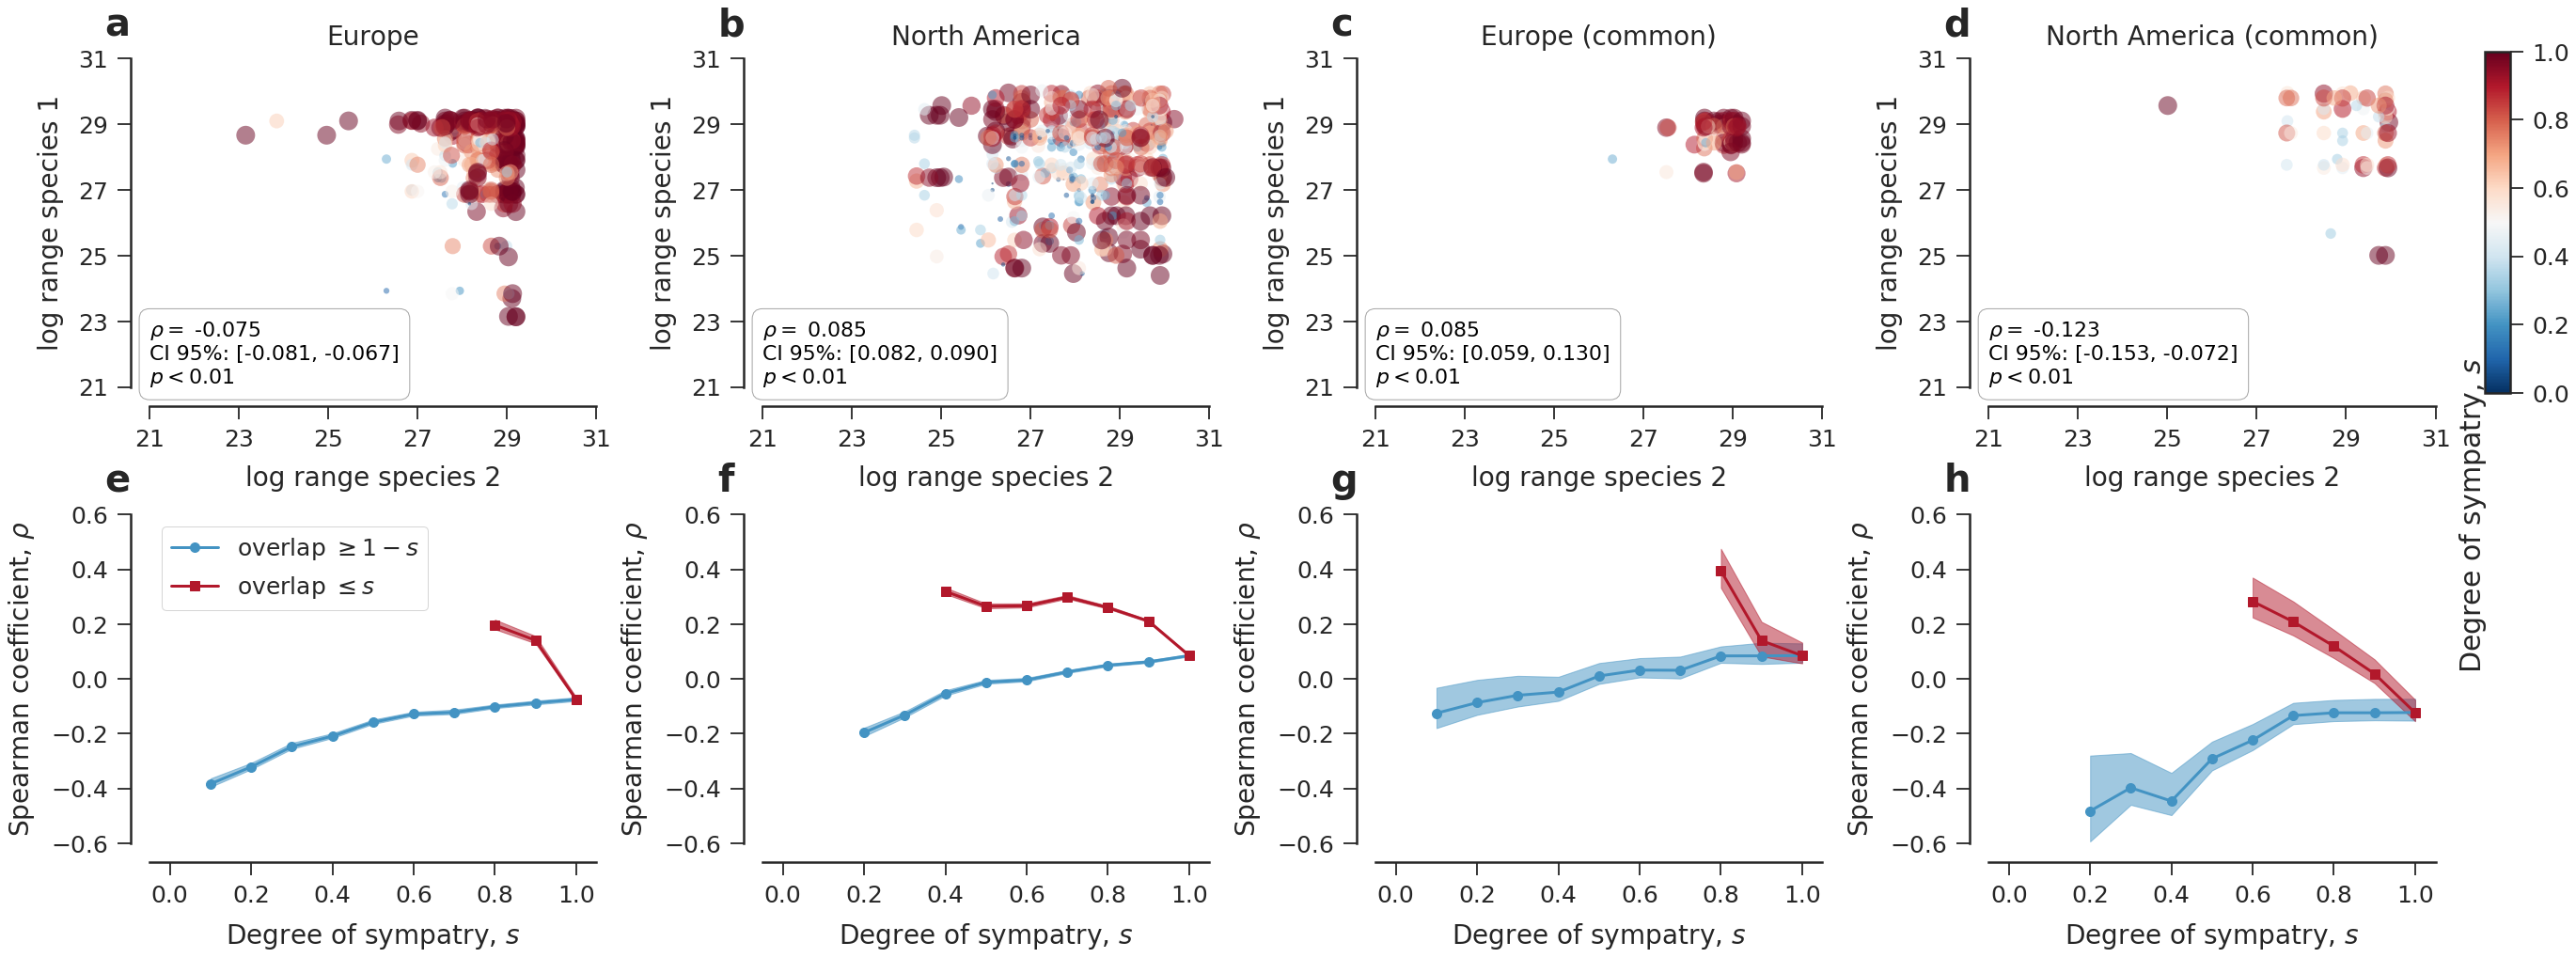

In [193]:
fig, ax = plt.subplots(2, 4, figsize=stdfigsize(ny=2, nx=4, ratio=1.3))

df_l  = [overlap_features_5050_europe, overlap_features_5050_north_america, overlap_features_5050_europe_common, overlap_features_5050_north_america_common]

df_sg = [europe_overlay_5050_greater_sympatry_spearman_shuffle, north_america_overlay_5050_greater_sympatry_spearman_shuffle, europe_overlay_5050_common_greater_sympatry_spearman_shuffle, north_america_overlay_5050_common_greater_sympatry_spearman_shuffle]

df_sl = [europe_overlay_5050_less_sympatry_spearman_shuffle, north_america_overlay_5050_less_sympatry_spearman_shuffle, europe_overlay_5050_common_less_sympatry_spearman_shuffle, north_america_overlay_5050_common_less_sympatry_spearman_shuffle]

kwargs = dict(lw=0, marker='o', alpha=0.5, legend=False)

color_s = palettable.colorbrewer.diverging.RdBu_11_r.mpl_colors
kwargs_sg = dict(lw=3, marker='o', markersize=10, color=color_s[2], legend=False)
kwargs_sl = dict(lw=3, marker='s', markersize=10, color=color_s[-2], legend=False)

kwargs_sg_bar = dict(lw=3, marker='o', markersize=10, color=color_s[2])
kwargs_sl_bar = dict(lw=3, marker='s', markersize=10, color=color_s[-2])

c = 0
for ax in ax.flat:
    if c < 4:
#         im = ax.imshow(np.random.random((10,10)), vmin=0, vmax=1, cmap=palettable.colorbrewer.diverging.RdBu_11_r.mpl_colormap)
        colors=[palettable.colorbrewer.diverging.RdBu_11_r.mpl_colormap(i) for i in df_l[c]['sympatry']]
    
        df_l[c][['area1', 'area2']].apply(np.log).plot.scatter('area1', 'area2', ax=ax, **kwargs, s=df_l[c]['sympatry']*400, c=colors)

        ax.set_ylabel('log range species 1')
        ax.set_xlabel('log range species 2')
    
        ax.set_title(['Europe', 'North America', 'Europe (common)', 'North America (common)'][c])
        
        df_stats = df_sg[c][df_sg[c]['index'] == 1.0].iloc[0]
    
        ax.text(0.0, 0.01,
                '$\\rho=$ {:.3f}\nCI 95%: [{:.3f}, {:.3f}]\n$p < 0.01$'.format(df_stats['spearman_mean'],df_stats['spearman_5CI'], df_stats['spearman_95CI']), 
                color='black', 
                bbox=dict(facecolor='white', edgecolor='gray', boxstyle='round,pad=0.5', alpha=0.7),
                transform=ax.transAxes,
                fontsize=22
               )
        ax.set_xlim([21,31])
        ax.set_ylim([21,31])
        ax.set_xticks(np.arange(21,33,2))
        ax.set_yticks(np.arange(21,33,2))
    
        if c == 3:
            ax.annotate('Degree of sympatry, $s$', xy=(1.05, 0.02), xycoords='axes fraction', rotation=90, fontsize=30)
    
    else:
        df_sg[c-4].plot('index', 'spearman_mean', ax=ax, **kwargs_sg)
        df_sl[c-4].plot('index', 'spearman_mean', ax=ax, **kwargs_sl)
        
        ax.fill_between(x=df_sg[c-4]['index'], y1=df_sg[c-4]['spearman_5CI'], y2=df_sg[c-4]['spearman_95CI'], color=color_s[2] , alpha=0.5)
        ax.fill_between(x=df_sl[c-4]['index'], y1=df_sl[c-4]['spearman_5CI'], y2=df_sl[c-4]['spearman_95CI'], color=color_s[-2], alpha=0.5)
        
        ax.set_xlabel('Degree of sympatry, $s$')
        ax.set_ylabel('Spearman coefficient, $\\rho$')
        
        ax.set_xlim([-0.05,1.05])
        ax.set_ylim([-0.6, 0.6])

        if c == 4:
            ax.legend(['overlap $\\geq 1-s$', 'overlap $\\leq s$'], fontsize=25, frameon=True, loc='upper left')
    
    ax.annotate(string.ascii_lowercase[c], xy=(-0.1, 1.07), xycoords='axes fraction', fontsize=40, weight='bold')
    
    for loc, spine in ax.spines.items():
        if loc in ['left', 'bottom']:
            spine.set_position(('outward', 20)) # outward by 20 points
        elif loc in ['right','top']:
            spine.set_color('none') # don't draw spine
        else:
            raise ValueError('unknown spine location: %s'%loc)
    
    # Only show ticks on the left and bottom spines
    ax.yaxis.set_ticks_position('left')
    ax.xaxis.set_ticks_position('bottom')
       
    c += 1
    
fig.subplots_adjust(right=0.8)
cbar_ax = fig.add_axes([1.01, 0.60, 0.01, 0.36])
fig.colorbar(im, cax=cbar_ax)
    
fig.tight_layout()
# fig.savefig('../figures/range_correlation_spearman_band_new.pdf', bbox_inches='tight')
# fig.savefig('../figures/range_correlation_spearman_band_new.png', bbox_inches='tight')

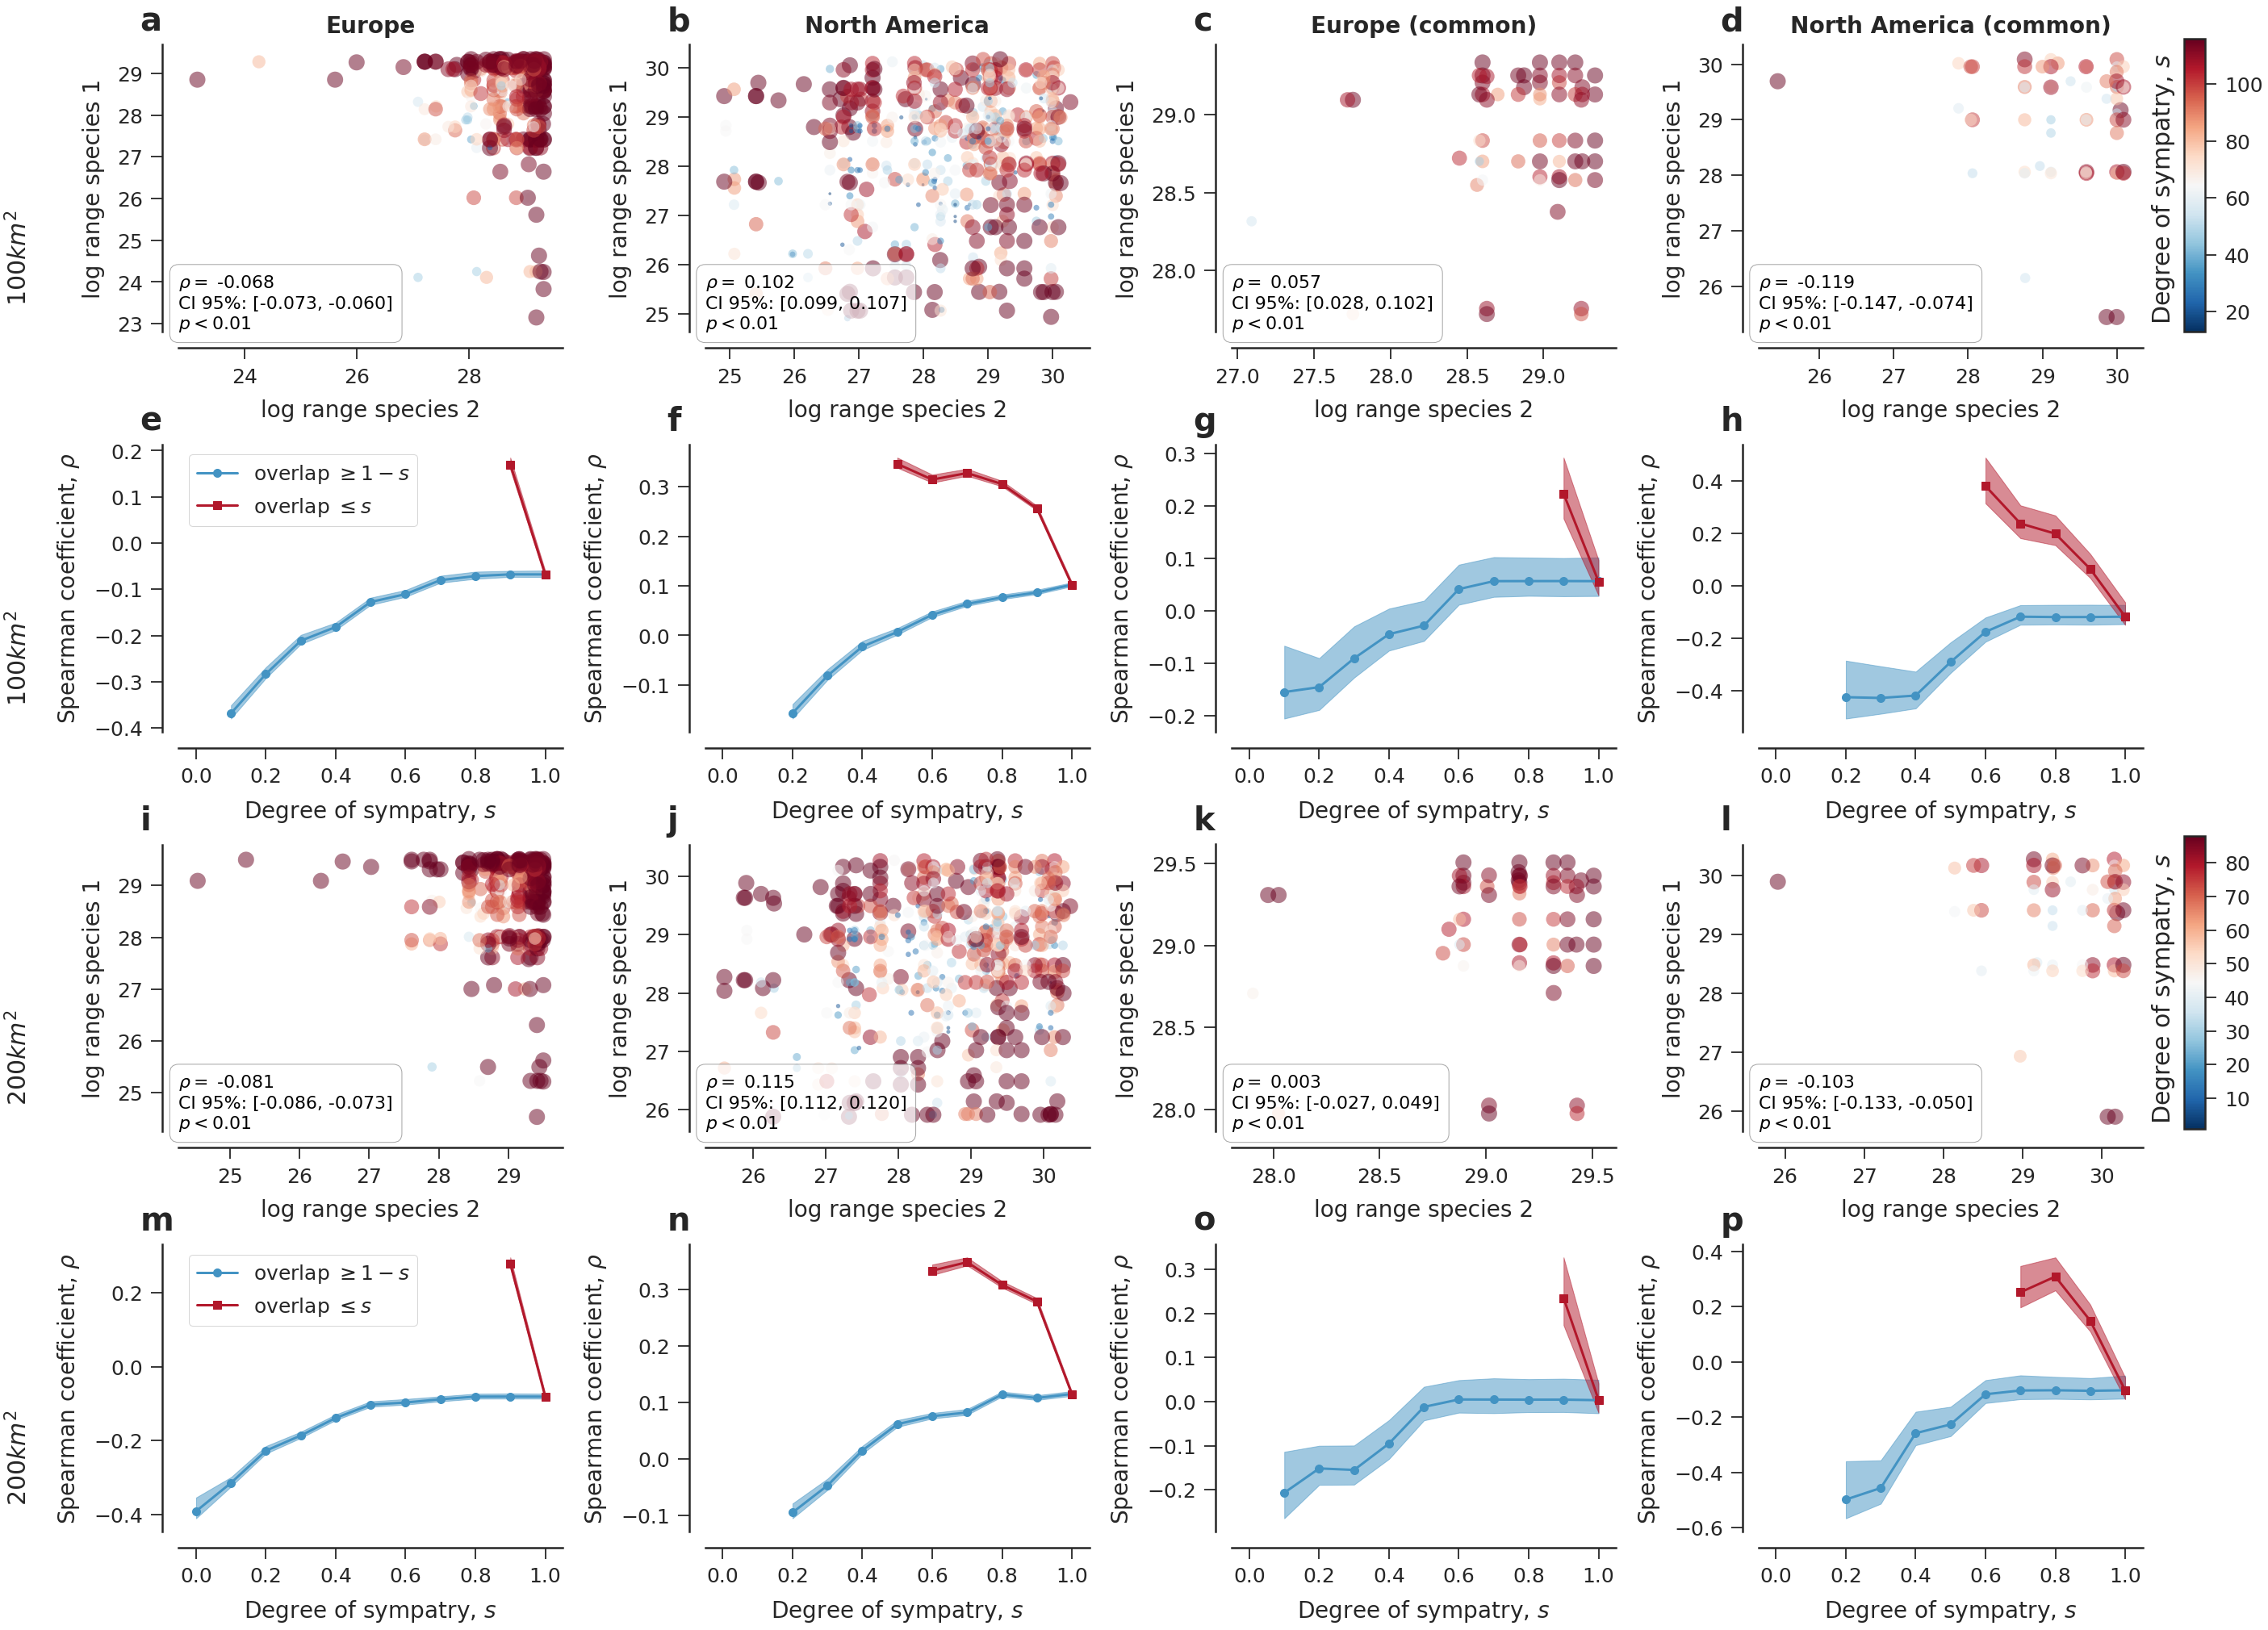

In [265]:
fig, axarr = plt.subplots(4, 4, figsize=stdfigsize(ny=4, nx=4))

# overlap_features_5050_europe
df_l = [overlap_features_100100_europe, overlap_features_100100_north_america, 
        overlap_features_100100_europe_common, overlap_features_100100_north_america_common,
        overlap_features_200200_europe, overlap_features_200200_north_america, 
        overlap_features_200200_europe_common, overlap_features_200200_north_america_common,]

df_sg = [
    europe_overlay_100100_greater_sympatry_spearman_shuffle, north_america_overlay_100100_greater_sympatry_spearman_shuffle,
    europe_overlay_100100_common_greater_sympatry_spearman_shuffle, north_america_overlay_100100_common_greater_sympatry_spearman_shuffle,
    europe_overlay_200200_greater_sympatry_spearman_shuffle, north_america_overlay_200200_greater_sympatry_spearman_shuffle,
    europe_overlay_200200_common_greater_sympatry_spearman_shuffle, north_america_overlay_200200_common_greater_sympatry_spearman_shuffle
        ]

df_sl = [
    europe_overlay_100100_less_sympatry_spearman_shuffle, north_america_overlay_100100_less_sympatry_spearman_shuffle,
    europe_overlay_100100_common_less_sympatry_spearman_shuffle, north_america_overlay_100100_common_less_sympatry_spearman_shuffle,
    europe_overlay_200200_less_sympatry_spearman_shuffle, north_america_overlay_200200_less_sympatry_spearman_shuffle,
    europe_overlay_200200_common_less_sympatry_spearman_shuffle, north_america_overlay_200200_common_less_sympatry_spearman_shuffle
        ]


kwargs = dict(lw=0, marker='o', alpha=0.5, legend=False)

color_s = palettable.colorbrewer.diverging.RdBu_11_r.mpl_colors
kwargs_sg = dict(lw=3, marker='o', markersize=10, color=color_s[2], legend=False)
kwargs_sl = dict(lw=3, marker='s', markersize=10, color=color_s[-2], legend=False)

c = 0
for ax in axarr.flat:
    if c < 4:
        colors=[palettable.colorbrewer.diverging.RdBu_11_r.mpl_colormap(i) for i in df_l[c]['sympatry']]

        df_l[c][['area1', 'area2']].apply(np.log).plot.scatter('area1', 'area2', ax=ax, **kwargs, s=df_l[c]['sympatry']*400, c=colors)

        ax.set_ylabel('log range species 1')
        ax.set_xlabel('log range species 2')

        df_stats = df_sg[c][df_sg[c]['index'] == 1.0].iloc[0]
    
        ax.text(0.0, 0.01,
                '$\\rho=$ {:.3f}\nCI 95%: [{:.3f}, {:.3f}]\n$p < 0.01$'.format(df_stats['spearman_mean'],df_stats['spearman_5CI'], df_stats['spearman_95CI']), 
                color='black', 
                bbox=dict(facecolor='white', edgecolor='gray', boxstyle='round,pad=0.5', alpha=0.7),
                transform=ax.transAxes,
                fontsize=22
               )
#         ax.set_xlim([21,31])
#         ax.set_ylim([21,31])
#         ax.set_xticks(np.arange(21,33,2))
#         ax.set_yticks(np.arange(21,33,2))
        
    elif c > 3 and c < 8:
        df_sg[c-4].plot('index', 'spearman_mean', ax=ax, **kwargs_sg)
        df_sl[c-4].plot('index', 'spearman_mean', ax=ax, **kwargs_sl)
        
        ax.fill_between(x=df_sg[c-4]['index'], y1=df_sg[c-4]['spearman_5CI'], y2=df_sg[c-4]['spearman_95CI'], color=color_s[2] , alpha=0.5)
        ax.fill_between(x=df_sl[c-4]['index'], y1=df_sl[c-4]['spearman_5CI'], y2=df_sl[c-4]['spearman_95CI'], color=color_s[-2], alpha=0.5)
        
        ax.set_xlabel('Degree of sympatry, $s$')
        ax.set_ylabel('Spearman coefficient, $\\rho$')
        
        ax.set_xlim([-0.05,1.05])
#         ax.set_ylim([-0.6, 0.6])
        
        if c == 4:
            ax.legend(['overlap $\\geq 1-s$', 'overlap $\\leq s$'], fontsize=25, frameon=True, loc='upper left')
    
    elif c > 7 and c < 12:
        colors=[palettable.colorbrewer.diverging.RdBu_11_r.mpl_colormap(i) for i in df_l[c-4]['sympatry']]

        df_l[c-4][['area1', 'area2']].apply(np.log).plot.scatter('area1', 'area2', ax=ax, **kwargs, s=df_l[c-4]['sympatry']*400, c=colors)

        ax.set_ylabel('log range species 1')
        ax.set_xlabel('log range species 2')

        df_stats = df_sg[c-4][df_sg[c-4]['index'] == 1.0].iloc[0]
    
        ax.text(0.0, 0.01,
                '$\\rho=$ {:.3f}\nCI 95%: [{:.3f}, {:.3f}]\n$p < 0.01$'.format(df_stats['spearman_mean'],df_stats['spearman_5CI'], df_stats['spearman_95CI']), 
                color='black', 
                bbox=dict(facecolor='white', edgecolor='gray', boxstyle='round,pad=0.5', alpha=0.7),
                transform=ax.transAxes,
                fontsize=22
               )
#         ax.set_xlim([23,31])
#         ax.set_ylim([23,31])
#         ax.set_xticks(np.arange(23,33,2))
#         ax.set_yticks(np.arange(23,33,2))
        
    elif c > 11 and c < 16:
        df_sg[c-8].plot('index', 'spearman_mean', ax=ax, **kwargs_sg)
        df_sl[c-8].plot('index', 'spearman_mean', ax=ax, **kwargs_sl)
        
        ax.fill_between(x=df_sg[c-8]['index'], y1=df_sg[c-8]['spearman_5CI'], y2=df_sg[c-8]['spearman_95CI'], color=color_s[2] , alpha=0.5)
        ax.fill_between(x=df_sl[c-8]['index'], y1=df_sl[c-8]['spearman_5CI'], y2=df_sl[c-8]['spearman_95CI'], color=color_s[-2], alpha=0.5)
        
        ax.set_xlabel('Degree of sympatry, $s$')
        ax.set_ylabel('Spearman coefficient, $\\rho$')
        
        ax.set_xlim([-0.05,1.05])
#         ax.set_ylim([-0.6, 0.6])
        
        if c == 12:
            ax.legend(['overlap $\\geq 1-s$', 'overlap $\\leq s$'], fontsize=25, frameon=True)
        
    ax.annotate(string.ascii_lowercase[c], xy=(-0.1, 1.05), xycoords='axes fraction', fontsize=40, weight='bold')
    
    if c < 4:
        ax.set_title(['Europe', 'North America', 'Europe (common)', 'North America (common)'][c], weight='bold')
    
    for loc, spine in ax.spines.items():
        if loc in ['left', 'bottom']:
            spine.set_position(('outward', 20)) # outward by 20 points
        elif loc in ['right','top']:
            spine.set_color('none') # don't draw spine
        else:
            raise ValueError('unknown spine location: %s'%loc)
    
    # Only show ticks on the left and bottom spines
    ax.yaxis.set_ticks_position('left')
    ax.xaxis.set_ticks_position('bottom')
    
    c += 1
    
[axarr[i,0].annotate(['$100km^2$', '$100km^2$', '$200km^2$',  '$200km^2$'][i], xy=(-0.45, 0.35), xycoords='axes fraction', rotation=90, fontsize=30, weight='bold') for i in range(4)]
[axarr[i,3].annotate('Degree of sympatry, $s$', xy=(1.02, 0.90), xycoords='axes fraction', rotation=90, fontsize=30) for i in [0,2]]

# im_1 = [axarr[0,i].imshow(np.random.random((10,10)), vmin=0, vmax=1, cmap=palettable.colorbrewer.diverging.RdBu_11_r.mpl_colormap) for i in range(4)][3]
# im_2 = [axarr[2,i].imshow(np.random.random((10,10)), vmin=0, vmax=1, cmap=palettable.colorbrewer.diverging.RdBu_11_r.mpl_colormap) for i in range(4)][3]

fig.subplots_adjust(right=0.8)
cbar_ax_1 = fig.add_axes([1.01, 0.80, 0.01, 0.18])
cbar_ax_2 = fig.add_axes([1.01, 0.31, 0.01, 0.18])
fig.colorbar(im_1, cax=cbar_ax_1)
fig.colorbar(im_2, cax=cbar_ax_2)
    
fig.tight_layout()
# fig.savefig('figures/range_correlation_spearman_supl_mat_band_new_autoaxes.pdf', bbox_inches='tight')
# fig.savefig('figures/range_correlation_spearman_supl_mat_band_new_autoaxes.png', bbox_inches='tight')

# Comparison of the environmental distributions between sister species
<a id="comparison-of-the-environmental"></a>
<a href="#summary">Summary</a>

In [195]:
def transform_list(l):
    dist = pd.eval(l.replace('nan', '-2')) 
    dist = dist[dist != -2].astype(np.float)
    
    return pd.DataFrame(dist, columns=['dist'])

def dist_comparison(df_1, df_2, df_3):
    
    df_tmp_lf = []
    
    for feature in ['mean_temp', 'mean_prec', 'mean_vtemp', 'alkalinity', 'water', 'lgm']:
    
        df_tmp_l = []
        
        for i in range(df_1.shape[0]):
            sp1, sp2 = list(df_1.loc[i, ['sp1', 'sp2']])
#             dist_1 = np.asarray(transform_list(df_1[(df_1['sp1'] == sp1) & (df_1['sp2'] == sp2)][feature].iloc[0])['dist'])
#             dist_2 = np.asarray(transform_list(df_2[(df_2['sp1'] == sp1) & (df_2['sp2'] == sp2)][feature].iloc[0])['dist'])
#             dist_3 = np.asarray(transform_list(df_3[(df_3['sp1'] == sp1) & (df_3['sp2'] == sp2)][feature].iloc[0])['dist'])
            dist_1 = np.asarray(df_1[(df_1['sp1'] == sp1) & (df_1['sp2'] == sp2)][feature].iloc[0]).round(3)
            dist_2 = np.asarray(df_2[(df_2['sp1'] == sp1) & (df_2['sp2'] == sp2)][feature].iloc[0]).round(3)
            dist_3 = np.asarray(df_3[(df_3['sp1'] == sp1) & (df_3['sp2'] == sp2)][feature].iloc[0]).round(3)
            
            dist_1 = dist_1[~np.isnan(dist_1)]
            dist_2 = dist_2[~np.isnan(dist_2)]
            dist_3 = dist_3[~np.isnan(dist_3)]
            
            if feature == 'water':
                dist_1 = dist_1/dist_1.mean()
                dist_2 = dist_2/dist_2.mean()
                dist_3 = dist_3/dist_3.mean()
            
            stats_50100, pvalue_50100   = scipy.stats.ks_2samp(dist_1, dist_2)
            stats_50200, pvalue_50200   = scipy.stats.ks_2samp(dist_1, dist_3)
            stats_100200, pvalue_100200 = scipy.stats.ks_2samp(dist_2, dist_3)

            df_tmp_l.append(pd.DataFrame({'sp1': [sp1], 'sp2': [sp2], 
                                   '50100_pvalue_{}'.format(feature): [pvalue_50100],
                                   '50100_stats_{}'.format(feature): [stats_50100],
                                   '50200_pvalue_{}'.format(feature): [pvalue_50200],
                                   '50200_stats_{}'.format(feature): [stats_50200],
                                   '100200_pvalue_{}'.format(feature): [pvalue_100200],
                                   '100200_stats_{}'.format(feature): [stats_100200]}))

        df_tmp = pd.concat(df_tmp_l).reset_index(drop=True)
        df_tmp_lf.append(df_tmp)
    
    df_tmp = pd.concat(df_tmp_lf, axis=1).reset_index(drop=True).T.drop_duplicates().T
        
    return df_tmp

In [196]:
overlap_features_5050_europe_ok   = overlap_features_5050_europe_weck4[['sp1', 'sp2', 'water']].merge(overlap_features_5050_europe, on=['sp1', 'sp2'])
overlap_features_100100_europe_ok = overlap_features_100100_europe_weck4[['sp1', 'sp2', 'water']].merge(overlap_features_100100_europe, on=['sp1', 'sp2'])
overlap_features_200200_europe_ok = overlap_features_200200_europe_weck4[['sp1', 'sp2', 'water']].merge(overlap_features_200200_europe, on=['sp1', 'sp2'])

overlap_features_5050_europe_common_ok   = overlap_features_5050_europe_weck4_common[['sp1', 'sp2', 'water']].merge(overlap_features_5050_europe_common, on=['sp1', 'sp2'])
overlap_features_100100_europe_common_ok = overlap_features_100100_europe_weck4_common[['sp1', 'sp2', 'water']].merge(overlap_features_100100_europe_common, on=['sp1', 'sp2'])
overlap_features_200200_europe_common_ok = overlap_features_200200_europe_weck4_common[['sp1', 'sp2', 'water']].merge(overlap_features_200200_europe_common, on=['sp1', 'sp2'])

In [197]:
overlap_features_5050_north_america_ok   = overlap_features_5050_north_america_weck4[['sp1', 'sp2', 'water']].merge(overlap_features_5050_north_america, on=['sp1', 'sp2'])
overlap_features_100100_north_america_ok = overlap_features_100100_north_america_weck4[['sp1', 'sp2', 'water']].merge(overlap_features_100100_north_america, on=['sp1', 'sp2'])
overlap_features_200200_north_america_ok = overlap_features_200200_north_america_weck4[['sp1', 'sp2', 'water']].merge(overlap_features_200200_north_america, on=['sp1', 'sp2'])

overlap_features_5050_north_america_common_ok   = overlap_features_5050_north_america_weck4_common[['sp1', 'sp2', 'water']].merge(overlap_features_5050_north_america_common, on=['sp1', 'sp2'])
overlap_features_100100_north_america_common_ok = overlap_features_100100_north_america_weck4_common[['sp1', 'sp2', 'water']].merge(overlap_features_100100_north_america_common, on=['sp1', 'sp2'])
overlap_features_200200_north_america_common_ok = overlap_features_200200_north_america_weck4_common[['sp1', 'sp2', 'water']].merge(overlap_features_200200_north_america_common, on=['sp1', 'sp2'])

In [198]:
features_comp_europe        = dist_comparison(overlap_features_5050_europe_ok, overlap_features_100100_europe_ok, overlap_features_200200_europe_ok)
features_comp_europe_common = dist_comparison(overlap_features_5050_europe_common_ok, overlap_features_100100_europe_common_ok, overlap_features_200200_europe_common_ok)

In [199]:
features_comp_north_america        = dist_comparison(overlap_features_5050_north_america_ok, overlap_features_100100_north_america_ok, overlap_features_200200_north_america_ok)
features_comp_north_america_common = dist_comparison(overlap_features_5050_north_america_common_ok, overlap_features_100100_north_america_common_ok, overlap_features_200200_north_america_common_ok)

In [200]:
# df = overlap_features_5050_europe_ok

# this consider the p-value with the Bonferroni correction
def comp_env_dist_sister(df, symp=False, method='ks'):

    df_tmp_l = []
    features = ['mean_temp', 'mean_prec', 'mean_vtemp', 'alkalinity', 'water', 'lgm']

    for genus in df['genus'].unique():

        for feature in features:
#                   
            dists = df[df['genus'] == genus][feature]        
#             dists = [np.asarray(transform_list(l)['dist']) for l in dists]
            dists = [np.asarray(l) for l in dists]
            symps = df[df['genus'] == genus]['sympatry']
            
            scombs = [comb for comb in combinations(symps, 2)]
            symp_1 = [symp[0] for symp in scombs]
            symp_2 = [symp[1] for symp in scombs]
            dcombs = [comb for comb in combinations(dists, 2)]
            
            if method == 'ks':
                pvalues = [scipy.stats.ks_2samp(comb[0], comb[1])[1] for comb in dcombs]
            elif method == 'wilcoxon':
                pvalues = [scipy.stats.ranksums(comb[0], comb[1])[1] for comb in dcombs]
            
            
            pv_df = pd.DataFrame(pvalues)
            total_pairs = pv_df.shape[0]
            
            perc_001_df = pv_df[pv_df >= 0.01].dropna()
            perc_005_df = pv_df[pv_df >= 0.05].dropna()
            
            # bonferroni
            if total_pairs > 1:
                perc_001_bf_df = pv_df[pv_df >= (0.01/(total_pairs-1))]
                perc_005_bf_df = pv_df[pv_df >= (0.05/(total_pairs-1))]
            else:
                perc_001_bf_df = pv_df[pv_df >= 0.01]
                perc_005_bf_df = pv_df[pv_df >= 0.05]
            
            if perc_001_df.shape[0] > 0:
                perc_001 = perc_001_df.shape[0]/pv_df.shape[0]
                n_pairs_001 = perc_001_df.shape[0]
            else:
                perc_001 = 0
                n_pairs_001 = 0
                
            if perc_005_df.shape[0] > 0:
                perc_005 = perc_005_df.shape[0]/pv_df.shape[0]
                n_pairs_005 = perc_005_df.shape[0]
            else:
                perc_005 = 0
                n_pairs_005 = 0
            
            # bonferroni
            if perc_001_bf_df.shape[0] > 0:
                perc_001_bf = perc_001_bf_df.shape[0]/pv_df.shape[0]
                n_pairs_001_bf = perc_001_bf_df.shape[0]
            else:
                perc_001_bf = 0
                n_pairs_001_bf = 0
                
            if perc_005_bf_df.shape[0] > 0:
                perc_005_bf = perc_005_bf_df.shape[0]/pv_df.shape[0]
                n_pairs_005_bf = perc_005_bf_df.shape[0]
            else:
                perc_005_bf = 0
                n_pairs_005_bf = 0
            
            if symp == False:
                df_tmp = pd.DataFrame({'genus': genus, 'feature': feature, 'pvalues': [pvalues], 'total_pairs': total_pairs, 'n_pairs_001': n_pairs_001, 'n_pairs_005': n_pairs_005, 'perc_001': perc_001, 'perc_005': perc_005, 'n_pairs_001_bf': n_pairs_001_bf, 'n_pairs_005_bf': n_pairs_005_bf, 'perc_001_bf': perc_001_bf, 'perc_005_bf': perc_005_bf})
            
            elif symp == True:
                df_tmp = pd.DataFrame({'genus': [genus]*len(pvalues), 'feature': [feature]*len(pvalues), 'pvalues': pvalues, 'symp_1': symp_1, 'symp_2': symp_2})
                
            df_tmp_l.append(df_tmp)
            
    return pd.concat(df_tmp_l).reset_index(drop=True)

In [201]:
comp_env_dist_sister_5050_europe        = comp_env_dist_sister(overlap_features_5050_europe_ok)
comp_env_dist_sister_5050_europe_common = comp_env_dist_sister(overlap_features_5050_europe_common_ok)

comp_env_dist_sister_100100_europe        = comp_env_dist_sister(overlap_features_100100_europe_ok)
comp_env_dist_sister_100100_europe_common = comp_env_dist_sister(overlap_features_100100_europe_common_ok)

comp_env_dist_sister_200200_europe        = comp_env_dist_sister(overlap_features_200200_europe_ok)
comp_env_dist_sister_200200_europe_common = comp_env_dist_sister(overlap_features_200200_europe_common_ok)

In [202]:
comp_env_dist_sister_5050_north_america        = comp_env_dist_sister(overlap_features_5050_north_america_ok)
comp_env_dist_sister_5050_north_america_common = comp_env_dist_sister(overlap_features_5050_north_america_common_ok)

comp_env_dist_sister_100100_north_america        = comp_env_dist_sister(overlap_features_100100_north_america_ok)
comp_env_dist_sister_100100_north_america_common = comp_env_dist_sister(overlap_features_100100_north_america_common_ok)

comp_env_dist_sister_200200_north_america        = comp_env_dist_sister(overlap_features_200200_north_america_ok)
comp_env_dist_sister_200200_north_america_common = comp_env_dist_sister(overlap_features_200200_north_america_common_ok)

In [203]:
comp_env_dist_sister_5050_europe.head(3)

genus     feature                                            pvalues  \
0  Alisma   mean_temp  [1.7069453840945492e-05, 0.9007643821104193, 9...   
1  Alisma   mean_prec  [0.2146128713214931, 0.7749467788311841, 4.995...   
2  Alisma  mean_vtemp  [0.03953228200983794, 0.0002188486519245636, 0...   

   total_pairs  n_pairs_001  n_pairs_005  perc_001  perc_005  n_pairs_001_bf  \
0            6            1            1  0.166667  0.166667               6   
1            6            3            2  0.500000  0.333333               6   
2            6            4            3  0.666667  0.500000               6   

   n_pairs_005_bf  perc_001_bf  perc_005_bf  
0               6          1.0          1.0  
1               6          1.0          1.0  
2               6          1.0          1.0

In [204]:
comp_env_dist_sister_5050_north_america.head(3)

genus     feature                                            pvalues  \
0  Alisma   mean_temp  [0.053822083099043905, 0.002425359966342522, 0...   
1  Alisma   mean_prec  [2.980809897801251e-07, 7.921117095577301e-10,...   
2  Alisma  mean_vtemp  [1.3957334617737006e-13, 2.4424906541753444e-1...   

   total_pairs  n_pairs_001  n_pairs_005  perc_001  perc_005  n_pairs_001_bf  \
0           10            2            2       0.2       0.2              10   
1           10            1            1       0.1       0.1              10   
2           10            1            1       0.1       0.1              10   

   n_pairs_005_bf  perc_001_bf  perc_005_bf  
0              10          1.0          1.0  
1              10          1.0          1.0  
2              10          1.0          1.0

In [205]:
comp_env_dist_sister_5050_europe[comp_env_dist_sister_5050_europe['feature'] == 'water'][['total_pairs', 'n_pairs_001', 'n_pairs_005', 'n_pairs_001_bf', 'n_pairs_005_bf']].sum()

total_pairs       14491
n_pairs_001        5787
n_pairs_005        4433
n_pairs_001_bf    14491
n_pairs_005_bf    14491
dtype: int64

In [206]:
comp_env_dist_sister_5050_north_america[comp_env_dist_sister_5050_north_america['feature'] == 'water'][['total_pairs', 'n_pairs_001', 'n_pairs_005', 'n_pairs_001_bf', 'n_pairs_005_bf']].sum()

total_pairs       26082
n_pairs_001       11705
n_pairs_005        8996
n_pairs_001_bf    26082
n_pairs_005_bf    26082
dtype: int64

In [207]:
num_comp_env_pv_001_5050_europe   = [comp_env_dist_sister_5050_europe[comp_env_dist_sister_5050_europe['feature']     == feature][['total_pairs', 'n_pairs_001', 'n_pairs_005']].sum()['n_pairs_001'] for feature in features]
num_comp_env_pv_001_100100_europe = [comp_env_dist_sister_100100_europe[comp_env_dist_sister_100100_europe['feature'] == feature][['total_pairs', 'n_pairs_001', 'n_pairs_005']].sum()['n_pairs_001'] for feature in features]
num_comp_env_pv_001_200200_europe = [comp_env_dist_sister_200200_europe[comp_env_dist_sister_200200_europe['feature'] == feature][['total_pairs', 'n_pairs_001', 'n_pairs_005']].sum()['n_pairs_001'] for feature in features]

num_comp_env_pv_005_5050_europe   = [comp_env_dist_sister_5050_europe[comp_env_dist_sister_5050_europe['feature']     == feature][['total_pairs', 'n_pairs_001', 'n_pairs_005']].sum()['n_pairs_005'] for feature in features]
num_comp_env_pv_005_100100_europe = [comp_env_dist_sister_100100_europe[comp_env_dist_sister_100100_europe['feature'] == feature][['total_pairs', 'n_pairs_001', 'n_pairs_005']].sum()['n_pairs_005'] for feature in features]
num_comp_env_pv_005_200200_europe = [comp_env_dist_sister_200200_europe[comp_env_dist_sister_200200_europe['feature'] == feature][['total_pairs', 'n_pairs_001', 'n_pairs_005']].sum()['n_pairs_005'] for feature in features]

In [208]:
num_comp_env_pv_001_5050_europe_common   = [comp_env_dist_sister_5050_europe_common[comp_env_dist_sister_5050_europe_common['feature']     == feature][['total_pairs', 'n_pairs_001', 'n_pairs_005']].sum()['n_pairs_001'] for feature in features]
num_comp_env_pv_001_100100_europe_common = [comp_env_dist_sister_100100_europe_common[comp_env_dist_sister_100100_europe_common['feature'] == feature][['total_pairs', 'n_pairs_001', 'n_pairs_005']].sum()['n_pairs_001'] for feature in features]
num_comp_env_pv_001_200200_europe_common = [comp_env_dist_sister_200200_europe_common[comp_env_dist_sister_200200_europe_common['feature'] == feature][['total_pairs', 'n_pairs_001', 'n_pairs_005']].sum()['n_pairs_001'] for feature in features]

num_comp_env_pv_005_5050_europe_common   = [comp_env_dist_sister_5050_europe_common[comp_env_dist_sister_5050_europe_common['feature']     == feature][['total_pairs', 'n_pairs_001', 'n_pairs_005']].sum()['n_pairs_005'] for feature in features]
num_comp_env_pv_005_100100_europe_common = [comp_env_dist_sister_100100_europe_common[comp_env_dist_sister_100100_europe_common['feature'] == feature][['total_pairs', 'n_pairs_001', 'n_pairs_005']].sum()['n_pairs_005'] for feature in features]
num_comp_env_pv_005_200200_europe_common = [comp_env_dist_sister_200200_europe_common[comp_env_dist_sister_200200_europe_common['feature'] == feature][['total_pairs', 'n_pairs_001', 'n_pairs_005']].sum()['n_pairs_005'] for feature in features]

In [209]:
num_comp_env_pv_001_5050_north_america   = [comp_env_dist_sister_5050_north_america[comp_env_dist_sister_5050_north_america['feature']     == feature][['total_pairs', 'n_pairs_001', 'n_pairs_005']].sum()['n_pairs_001'] for feature in features]
num_comp_env_pv_001_100100_north_america = [comp_env_dist_sister_100100_north_america[comp_env_dist_sister_100100_north_america['feature'] == feature][['total_pairs', 'n_pairs_001', 'n_pairs_005']].sum()['n_pairs_001'] for feature in features]
num_comp_env_pv_001_200200_north_america = [comp_env_dist_sister_200200_north_america[comp_env_dist_sister_200200_north_america['feature'] == feature][['total_pairs', 'n_pairs_001', 'n_pairs_005']].sum()['n_pairs_001'] for feature in features]

num_comp_env_pv_005_5050_north_america   = [comp_env_dist_sister_5050_north_america[comp_env_dist_sister_5050_north_america['feature']     == feature][['total_pairs', 'n_pairs_001', 'n_pairs_005']].sum()['n_pairs_005'] for feature in features]
num_comp_env_pv_005_100100_north_america = [comp_env_dist_sister_100100_north_america[comp_env_dist_sister_100100_north_america['feature'] == feature][['total_pairs', 'n_pairs_001', 'n_pairs_005']].sum()['n_pairs_005'] for feature in features]
num_comp_env_pv_005_200200_north_america = [comp_env_dist_sister_200200_north_america[comp_env_dist_sister_200200_north_america['feature'] == feature][['total_pairs', 'n_pairs_001', 'n_pairs_005']].sum()['n_pairs_005'] for feature in features]

In [210]:
num_comp_env_pv_001_5050_north_america_common   = [comp_env_dist_sister_5050_north_america_common[comp_env_dist_sister_5050_north_america_common['feature']     == feature][['total_pairs', 'n_pairs_001', 'n_pairs_005']].sum()['n_pairs_001'] for feature in features]
num_comp_env_pv_001_100100_north_america_common = [comp_env_dist_sister_100100_north_america_common[comp_env_dist_sister_100100_north_america_common['feature'] == feature][['total_pairs', 'n_pairs_001', 'n_pairs_005']].sum()['n_pairs_001'] for feature in features]
num_comp_env_pv_001_200200_north_america_common = [comp_env_dist_sister_200200_north_america_common[comp_env_dist_sister_200200_north_america_common['feature'] == feature][['total_pairs', 'n_pairs_001', 'n_pairs_005']].sum()['n_pairs_001'] for feature in features]

num_comp_env_pv_005_5050_north_america_common   = [comp_env_dist_sister_5050_north_america_common[comp_env_dist_sister_5050_north_america_common['feature']     == feature][['total_pairs', 'n_pairs_001', 'n_pairs_005']].sum()['n_pairs_005'] for feature in features]
num_comp_env_pv_005_100100_north_america_common = [comp_env_dist_sister_100100_north_america_common[comp_env_dist_sister_100100_north_america_common['feature'] == feature][['total_pairs', 'n_pairs_001', 'n_pairs_005']].sum()['n_pairs_005'] for feature in features]
num_comp_env_pv_005_200200_north_america_common = [comp_env_dist_sister_200200_north_america_common[comp_env_dist_sister_200200_north_america_common['feature'] == feature][['total_pairs', 'n_pairs_001', 'n_pairs_005']].sum()['n_pairs_005'] for feature in features]

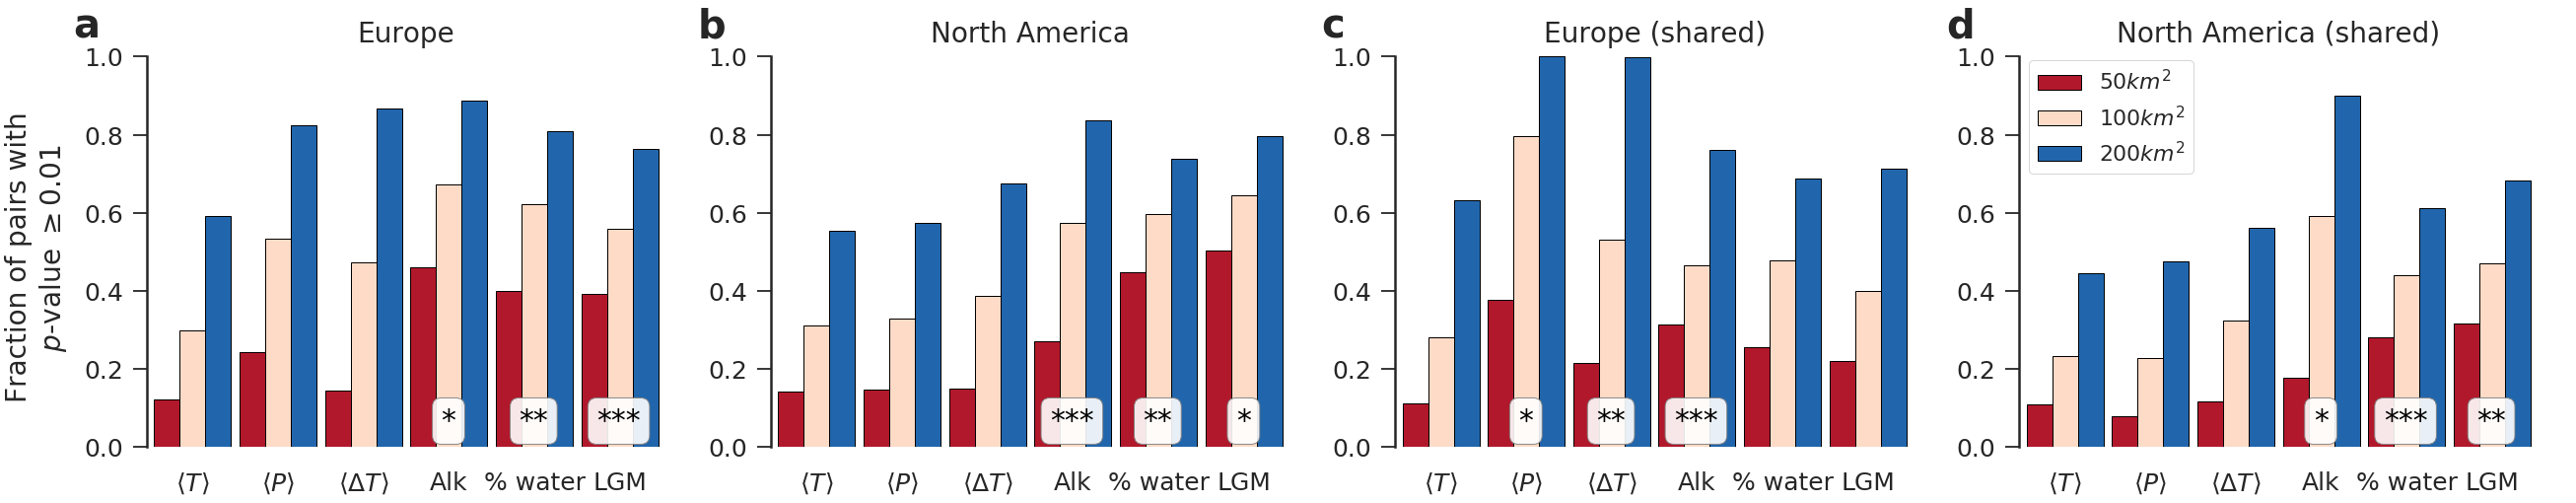

In [211]:
fig, ax = plt.subplots(1, 4, figsize=stdfigsize(ny=1, nx=4))


colors = palettable.colorbrewer.diverging.RdBu_11.mpl_colors
xlabels = ['$\\langle T \\rangle$', '$\\langle P \\rangle$', '$\\langle \Delta T \\rangle$', 'Alk', '% water', 'LGM']

# set width of bar
# barWidth = 0.15
barWidth = 0.3

pairs_europe               =                             comp_env_dist_sister_5050_europe[comp_env_dist_sister_5050_europe['feature'] == 'mean_temp']['total_pairs'].sum()
pairs_europe_common        =               comp_env_dist_sister_5050_europe_common[comp_env_dist_sister_5050_europe_common['feature'] == 'mean_temp']['total_pairs'].sum()
pairs_north_america        =               comp_env_dist_sister_5050_north_america[comp_env_dist_sister_5050_north_america['feature'] == 'mean_temp']['total_pairs'].sum()
pairs_north_america_common = comp_env_dist_sister_5050_north_america_common[comp_env_dist_sister_5050_north_america_common['feature'] == 'mean_temp']['total_pairs'].sum()


# set height of bar
bars1 = num_comp_env_pv_001_5050_europe/pairs_europe
bars2 = num_comp_env_pv_001_100100_europe/pairs_europe
bars3 = num_comp_env_pv_001_200200_europe/pairs_europe

# Set position of bar on X axis
r1 = np.arange(len(bars1))
# r2 = [x + 0.15 for x in r1]
# r3 = [x + 0.15 for x in r2]
r2 = [x + barWidth for x in r1]
r3 = [x + barWidth for x in r2]

# Make the plot
ax[0].bar(r1, bars1, color=colors[1], width=barWidth, edgecolor='k', label='var1')
ax[0].bar(r2, bars2, color=colors[4], width=barWidth, edgecolor='k', label='var2')
ax[0].bar(r3, bars3, color=colors[9], width=barWidth, edgecolor='k', label='var3')

# set height of bar
bars1 = num_comp_env_pv_001_5050_north_america/pairs_north_america
bars2 = num_comp_env_pv_001_100100_north_america/pairs_north_america
bars3 = num_comp_env_pv_001_200200_north_america/pairs_north_america

# Set position of bar on X axis
r1 = np.arange(len(bars1))
# r2 = [x + 0.15 for x in r1]
# r3 = [x + 0.15 for x in r2]
r2 = [x + barWidth for x in r1]
r3 = [x + barWidth for x in r2]

# Make the plot
ax[1].bar(r1, bars1, color=colors[1], width=barWidth, edgecolor='k', label='var1')
ax[1].bar(r2, bars2, color=colors[4], width=barWidth, edgecolor='k', label='var2')
ax[1].bar(r3, bars3, color=colors[9], width=barWidth, edgecolor='k', label='var3')

# set height of bar
bars1 = num_comp_env_pv_001_5050_europe_common/pairs_europe_common
bars2 = num_comp_env_pv_001_100100_europe_common/pairs_europe_common
bars3 = num_comp_env_pv_001_200200_europe_common/pairs_europe_common

# Set position of bar on X axis
r1 = np.arange(len(bars1))
# r2 = [x + 0.15 for x in r1]
# r3 = [x + 0.15 for x in r2]
r2 = [x + barWidth for x in r1]
r3 = [x + barWidth for x in r2]

# Make the plot
ax[2].bar(r1, bars1, color=colors[1], width=barWidth, edgecolor='k', label='var1')
ax[2].bar(r2, bars2, color=colors[4], width=barWidth, edgecolor='k', label='var2')
ax[2].bar(r3, bars3, color=colors[9], width=barWidth, edgecolor='k', label='var3')


# set height of bar
bars1 = num_comp_env_pv_001_5050_north_america_common/pairs_north_america_common
bars2 = num_comp_env_pv_001_100100_north_america_common/pairs_north_america_common
bars3 = num_comp_env_pv_001_200200_north_america_common/pairs_north_america_common

# Set position of bar on X axis
r1 = np.arange(len(bars1))
# r2 = [x + 0.15 for x in r1]
# r3 = [x + 0.15 for x in r2]
r2 = [x + barWidth for x in r1]
r3 = [x + barWidth for x in r2]

# Make the plot
ax[3].bar(r1, bars1, color=colors[1], width=barWidth, edgecolor='k', label='var1')
ax[3].bar(r2, bars2, color=colors[4], width=barWidth, edgecolor='k', label='var2')
ax[3].bar(r3, bars3, color=colors[9], width=barWidth, edgecolor='k', label='var3')


# Create legend & Show graphic
plt.legend(['$50km^2$', '$100km^2$', '$200km^2$'], fontsize=22, loc=(0.05,0.70))

# dashed line with total number of pairs
y_lim_1 = [comp_env_dist_sister_5050_europe[comp_env_dist_sister_5050_europe['feature'] == feature]['total_pairs'].sum() for feature in features]
y_lim_2 = [comp_env_dist_sister_5050_north_america[comp_env_dist_sister_5050_north_america['feature'] == feature]['total_pairs'].sum() for feature in features]
y_lim_3 = [comp_env_dist_sister_5050_europe_common[comp_env_dist_sister_5050_europe_common['feature'] == feature]['total_pairs'].sum() for feature in features]
y_lim_4 = [comp_env_dist_sister_5050_north_america_common[comp_env_dist_sister_5050_north_america_common['feature'] == feature]['total_pairs'].sum() for feature in features]

# ax[0].plot([0, 5.5], [1, 1], ls='--', color='k', lw=3)
# ax[1].plot([0, 5.5], [1, 1], ls='--', color='k', lw=3)
# ax[2].plot([0, 5.5], [1, 1], ls='--', color='k', lw=3)
# ax[3].plot([0, 5.5], [1, 1], ls='--', color='k', lw=3)

mean_1 = np.asarray(pd.DataFrame({'50': num_comp_env_pv_001_5050_europe/pairs_europe, '100': num_comp_env_pv_001_100100_europe/pairs_europe, '200': num_comp_env_pv_001_200200_europe/pairs_europe}).mean(axis=1))
mean_2 = np.asarray(pd.DataFrame({'50': num_comp_env_pv_001_5050_north_america/pairs_north_america, '100': num_comp_env_pv_001_100100_north_america/pairs_north_america, '200': num_comp_env_pv_001_200200_north_america/pairs_north_america}).mean(axis=1))
mean_3 = np.asarray(pd.DataFrame({'50': num_comp_env_pv_001_5050_europe_common/pairs_europe_common, '100': num_comp_env_pv_001_100100_europe_common/pairs_europe_common, '200': num_comp_env_pv_001_200200_europe_common/pairs_europe_common}).mean(axis=1))
mean_4 = np.asarray(pd.DataFrame({'50': num_comp_env_pv_001_5050_north_america_common/pairs_north_america_common, '100': num_comp_env_pv_001_100100_north_america_common/pairs_north_america_common, '200': num_comp_env_pv_001_200200_north_america_common/pairs_north_america_common}).mean(axis=1))

pair_1 = sorted(np.asarray([r1, mean_1]).T, key=lambda a_entry: a_entry[1], reverse=True)
pair_2 = sorted(np.asarray([r1, mean_2]).T, key=lambda a_entry: a_entry[1], reverse=True)
pair_3 = sorted(np.asarray([r1, mean_3]).T, key=lambda a_entry: a_entry[1], reverse=True)
pair_4 = sorted(np.asarray([r1, mean_4]).T, key=lambda a_entry: a_entry[1], reverse=True)

# ax[0].annotate('*',   xy=(pair_1[0][0]+barWidth*.60, 1), fontsize=30, weight='bold')
# ax[0].annotate('**',  xy=(pair_1[1][0]+barWidth*.25, 1), fontsize=30, weight='bold')
# ax[0].annotate('***', xy=(pair_1[2][0]+barWidth/100, 1), fontsize=30, weight='bold')

# ax[1].annotate('*',   xy=(pair_2[0][0]+barWidth*.60, 1), fontsize=30, weight='bold')
# ax[1].annotate('**',  xy=(pair_2[1][0]+barWidth*.25, 1), fontsize=30, weight='bold')
# ax[1].annotate('***', xy=(pair_2[2][0]+barWidth/100, 1), fontsize=30, weight='bold')

# ax[2].annotate('*',   xy=(pair_3[0][0]+barWidth*.60, 1), fontsize=30, weight='bold')
# ax[2].annotate('**',  xy=(pair_3[1][0]+barWidth*.25, 1), fontsize=30, weight='bold')
# ax[2].annotate('***', xy=(pair_3[2][0]+barWidth/100, 1), fontsize=30, weight='bold')

# ax[3].annotate('*',   xy=(pair_4[0][0]+barWidth*.60, 1), fontsize=30, weight='bold')
# ax[3].annotate('**',  xy=(pair_4[1][0]+barWidth*.25, 1), fontsize=30, weight='bold')
# ax[3].annotate('***', xy=(pair_4[2][0]+barWidth/100, 1), fontsize=30, weight='bold')


text_kwargs = dict(color='black', fontsize=30, bbox=dict(facecolor='white', edgecolor='gray', alpha=.9, boxstyle='round, pad=.3'))
ax[0].text(pair_1[0][0]+barWidth*.70, 0.045, '*'  , **text_kwargs)
ax[0].text(pair_1[1][0]+barWidth*.40, 0.045, '**' , **text_kwargs)
ax[0].text(pair_1[2][0]+barWidth*.10, 0.045, '***', **text_kwargs)

ax[1].text(pair_2[0][0]+barWidth*.70, 0.045, '*'  , **text_kwargs)
ax[1].text(pair_2[1][0]+barWidth*.40, 0.045, '**' , **text_kwargs)
ax[1].text(pair_2[2][0]+barWidth*.10, 0.045, '***', **text_kwargs)

ax[2].text(pair_3[0][0]+barWidth*.70, 0.045, '*'  , **text_kwargs)
ax[2].text(pair_3[1][0]+barWidth*.40, 0.045, '**' , **text_kwargs)
ax[2].text(pair_3[2][0]+barWidth*.10, 0.045, '***', **text_kwargs)

ax[3].text(pair_4[0][0]+barWidth*.70, 0.045, '*'  , **text_kwargs)
ax[3].text(pair_4[1][0]+barWidth*.40, 0.045, '**' , **text_kwargs)
ax[3].text(pair_4[2][0]+barWidth*.10, 0.045, '***', **text_kwargs)
# ax[0].annotate('Total number of pairs', xy=(0.05, 0.88), xycoords='axes fraction', fontsize=24)

c = 0
for ax in ax.flat:
    for loc, spine in ax.spines.items():
        if loc in ['left']:
            spine.set_position(('outward', -18)) # outward by 20 points
        elif loc in ['right','top', 'bottom']:
            spine.set_color('none') # don't draw spine
        else:
            raise ValueError('unknown spine location: %s'%loc)

        # Only show ticks on the left and bottom spines
        ax.yaxis.set_ticks_position('left')
        ax.xaxis.set_ticks_position('none') 
        
#     ax.set_xticks([r + 0.15 for r in range(len(bars1))])
    ax.set_xticks([r + barWidth for r in range(len(bars1))])
    ax.set_xticklabels(xlabels)
    if c == 0:
        ax.set_ylabel('Fraction of pairs with \n $p$-value $\geq 0.01$')
#     ax.yaxis.set_label_coords(-0.1,1.02,)
#     ax.annotate('$\%\ p$-value $\geq 0.05$', xy=(-0.2,1.05), xycoords='axes fraction', fontsize=20)
    ax.set_title(['Europe', 'North America', 'Europe (shared)', 'North America (shared)'][c])
    ax.annotate(string.ascii_lowercase[c], xy=(-0.1, 1.05), xycoords='axes fraction', fontsize=40, weight='bold')

    ax.set_ylim([0,1.0])
    
    c += 1


fig.tight_layout()
# fig.savefig('../figures/pairs_features_frac_pvalue_new.pdf', bbox_inches='tight')
# fig.savefig('../figures/pairs_features_frac_pvalue_new.png', bbox_inches='tight')

# Correlation between sympatry of pairs and their phylogenitic distance
<a id="correlation-between-sympatry"></a>
<a href="#summary">Summary</a>

In [212]:
coph_distance = pd.read_excel('new_data/coph_distances.xlsx')

In [213]:
coph_distance['sp1'] = [" ".join(sp1.split('_')[:2]).capitalize() for sp1 in np.asarray(coph_distance['Var1'])]
coph_distance['sp2'] = [" ".join(sp2.split('_')[:2]).capitalize() for sp2 in np.asarray(coph_distance['Var2'])]

In [214]:
coph_distance = coph_distance[['sp1', 'sp2', 'Patristic distance']]

In [215]:
overlap_features_5050_europe['area_diff']   = abs(overlap_features_5050_europe['area1'] - overlap_features_5050_europe['area2'])
overlap_features_100100_europe['area_diff'] = abs(overlap_features_100100_europe['area1'] - overlap_features_100100_europe['area2'])
overlap_features_200200_europe['area_diff'] = abs(overlap_features_200200_europe['area1'] - overlap_features_200200_europe['area2'])

overlap_features_5050_europe['grids_diff']   = abs(overlap_features_5050_europe['grids1'] - overlap_features_5050_europe['grids2'])
overlap_features_100100_europe['grids_diff'] = abs(overlap_features_100100_europe['grids1'] - overlap_features_100100_europe['grids2'])
overlap_features_200200_europe['grids_diff'] = abs(overlap_features_200200_europe['grids1'] - overlap_features_200200_europe['grids2'])

In [216]:
overlap_features_5050_north_america['area_diff']   = abs(overlap_features_5050_north_america['area1'] - overlap_features_5050_north_america['area2'])
overlap_features_100100_north_america['area_diff'] = abs(overlap_features_100100_north_america['area1'] - overlap_features_100100_north_america['area2'])
overlap_features_200200_north_america['area_diff'] = abs(overlap_features_200200_north_america['area1'] - overlap_features_200200_north_america['area2'])

overlap_features_5050_north_america['grids_diff']   = abs(overlap_features_5050_north_america['grids1'] - overlap_features_5050_north_america['grids2'])
overlap_features_100100_north_america['grids_diff'] = abs(overlap_features_100100_north_america['grids1'] - overlap_features_100100_north_america['grids2'])
overlap_features_200200_north_america['grids_diff'] = abs(overlap_features_200200_north_america['grids1'] - overlap_features_200200_north_america['grids2'])

In [217]:
np.asarray(overlap_features_5050_north_america.iloc[1][['sp1', 'sp2', 'sympatry_grids', 'area_diff', 'grids_diff']][['sympatry_grids', 'area_diff']])

array([0.285140562248996, 1173954685301.8794], dtype=object)

In [218]:
def join_symp_phylo(df):
    l_arr = []
    for i in range(df.shape[0]):
        curr_pair = df.iloc[i][['sp1', 'sp2', 'sympatry_grids', 'area_diff', 'grids_diff', 'area1', 'area2']]
        
        phylo_df = coph_distance[(coph_distance['sp1'] == curr_pair[0]) & 
                  (coph_distance['sp2'] == curr_pair[1])]
        
        if phylo_df.shape[0] > 0:
        
            arr = np.concatenate([np.asarray(coph_distance[(coph_distance['sp1'] == curr_pair[0]) & 
                      (coph_distance['sp2'] == curr_pair[1])]), np.asarray(curr_pair[['sympatry_grids', 'area_diff', 'grids_diff', 'area1', 'area2']])], axis=None)

            l_arr.append(arr)

    final_df = pd.DataFrame(np.asarray(l_arr), columns=['sp1', 'sp2', 'pdist', 'sympatry', 'area_diff', 'grids_diff', 'area1', 'area2'])
#     final_df['pdist_norm'] = (final_df['pdist'] - final_df['pdist'].min()) / (final_df['pdist'].max() - final_df['pdist'].min())
#     final_df['sympatry_norm'] = (final_df['sympatry'] - final_df['sympatry'].min()) / (final_df['sympatry'].max() - final_df['sympatry'].min())
#     final_df['area_diff_norm'] = (final_df['area_diff'] - final_df['area_diff'].min()) / (final_df['area_diff'].max() - final_df['area_diff'].min())
#     final_df['grids_diff_norm'] = (final_df['grids_diff'] - final_df['grids_diff'].min()) / (final_df['grids_diff'].max() - final_df['grids_diff'].min())
    
    return final_df

In [219]:
symp_phylo_europe_5050 = join_symp_phylo(overlap_features_5050_europe)
symp_phylo_europe_100100 = join_symp_phylo(overlap_features_100100_europe)
symp_phylo_europe_200200 = join_symp_phylo(overlap_features_200200_europe)

symp_phylo_europe_common_5050 = join_symp_phylo(overlap_features_5050_europe_common)
symp_phylo_europe_common_100100 = join_symp_phylo(overlap_features_100100_europe_common)
symp_phylo_europe_common_200200 = join_symp_phylo(overlap_features_200200_europe_common)

/home/dsvieira/anaconda3/lib/python3.7/site-packages/pandas/core/series.py:1152: FutureWarning: 
Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentation here:
https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#deprecate-loc-reindex-listlike
  return self.loc[key]


In [220]:
symp_phylo_north_america_5050 = join_symp_phylo(overlap_features_5050_north_america)
symp_phylo_north_america_100100 = join_symp_phylo(overlap_features_100100_north_america)
symp_phylo_north_america_200200 = join_symp_phylo(overlap_features_200200_north_america)

symp_phylo_north_america_common_5050 = join_symp_phylo(overlap_features_5050_north_america_common)
symp_phylo_north_america_common_100100 = join_symp_phylo(overlap_features_100100_north_america_common)
symp_phylo_north_america_common_200200 = join_symp_phylo(overlap_features_200200_north_america_common)

In [221]:
symp_phylo_europe_5050[['pdist', 'sympatry']].astype(float).corr().iloc[0][1].round(3)

-0.062

In [222]:
def spearman(data):
    """
    Calculates the Spearman correlation coefficient.
    Parameters
    ----------
    data: two-columns numpy array
    ----------
    Returns Spearman.
    """
    data=data.transpose()
    pea=scipy.stats.spearmanr(data[0],data[1])
    return(pea)

In [223]:
def pearson(data):
    """
    Calculates the Pearson correlation coefficient.
    Parameters
    ----------
    data: two-columns numpy array
    ----------
    Returns Pearson.
    """
    data=data.transpose()
    pea=scipy.stats.pearsonr(data[0],data[1])
    return(pea)

## Patristic distance $\times$ sympatry
<a id="patristic-distance-sympatry"></a>
<a href="#summary">Summary</a>

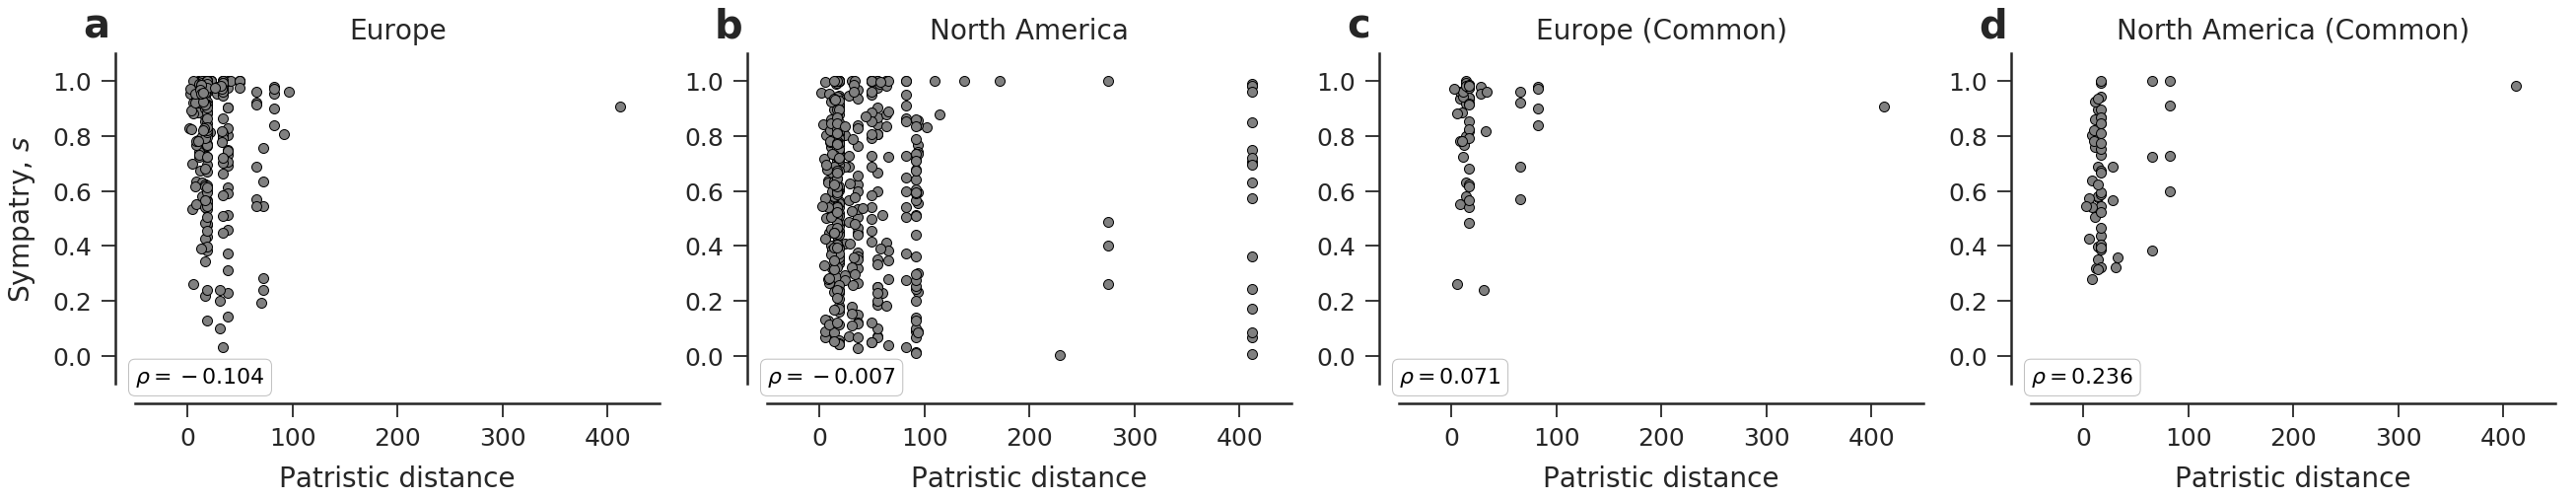

In [224]:
fig, ax = plt.subplots(1, 4, figsize=stdfigsize(ny=1, nx=4))

axis_aesthetics(fig)
place_axes_label(fig)

kwargs=dict(lw=0, marker='o', markersize=10, markeredgecolor='black', color='gray', legend=False)
text_kwargs = dict(color='black', fontsize=22, bbox=dict(facecolor='white', edgecolor='gray', alpha=.5, boxstyle='round, pad=.3'))

l = [symp_phylo_europe_5050, 
    symp_phylo_north_america_5050,
    symp_phylo_europe_common_5050,
    symp_phylo_north_america_common_5050]

for n, _ax in enumerate(fig.get_axes()):
    l[n].plot('pdist', 'sympatry', ax=_ax, **kwargs)
    _ax.text(0, 0, 
               '$\\rho = {:.3f}$'.format(l[n][['pdist', 'sympatry']].astype(float).corr(method='spearman').iloc[0][1]), 
#                '$\\rho=$ {:.3f}\nCI 95%: [{:.3f}, {:.3f}]\n$p < 0.01$'.format(df_stats['spearman_mean'], df_stats['spearman_5CI'], df_stats['spearman_95CI'])
               transform=_ax.transAxes,
               **text_kwargs)
    _ax.set_xlabel('Patristic distance')
    _ax.set_ylim([-0.1, 1.1])
    _ax.set_yticks(np.arange(0,1.2,0.2))
    _ax.set_xlim([-50, 450])
    _ax.set_title(['Europe', 'North America', 'Europe (Common)', 'North America (Common)'][n])
    if n == 0 :
        _ax.set_ylabel('Sympatry, $s$')

fig.tight_layout()
# fig.savefig('figures/pdist_symp_corr.pdf', bbox_inches='tight')
# fig.savefig('figures/pdist_symp_corr.png', bbox_inches='tight')

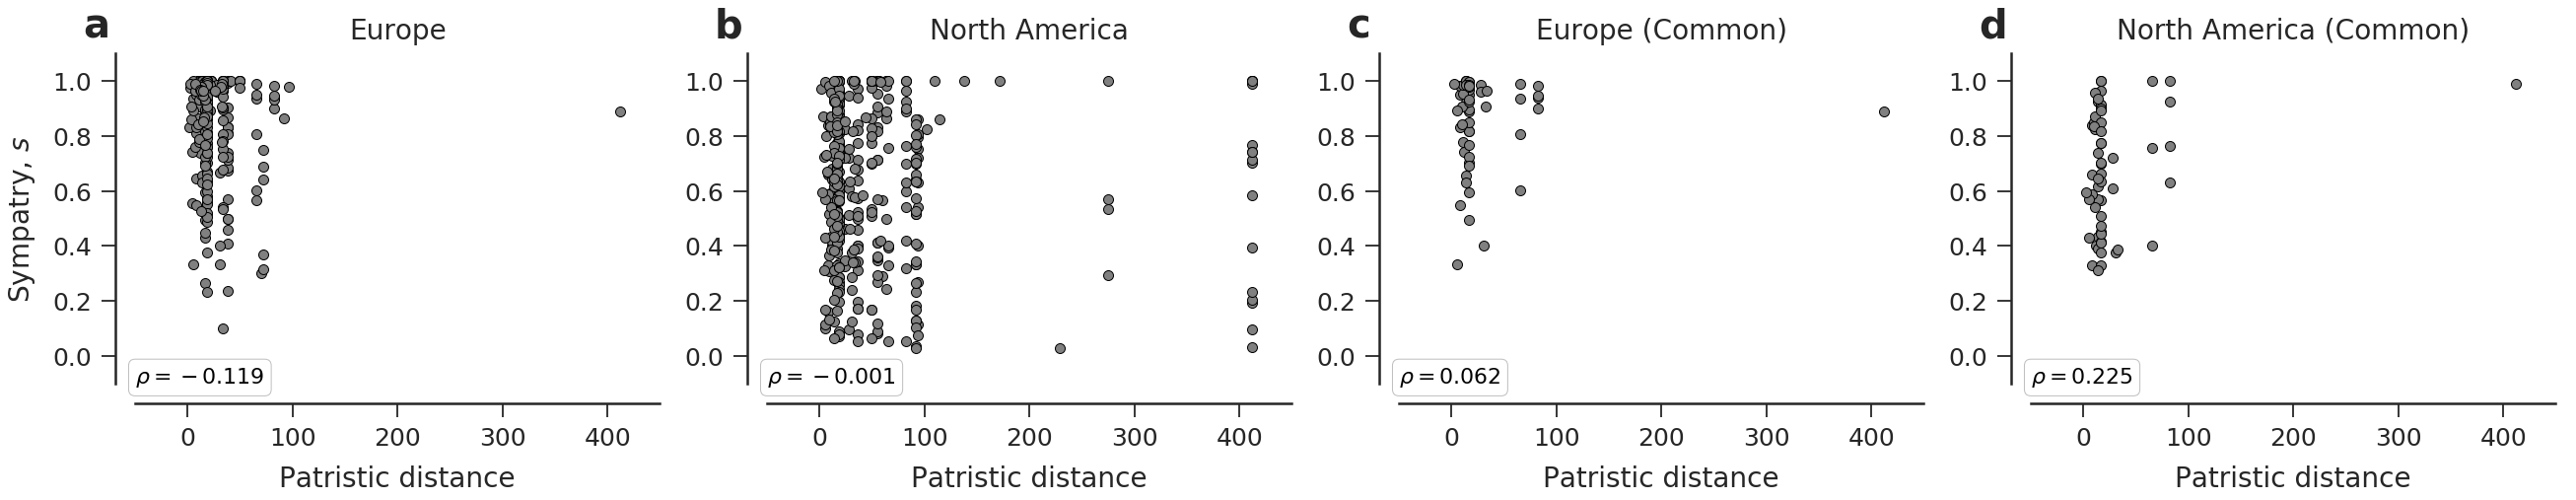

In [225]:
fig, ax = plt.subplots(1, 4, figsize=stdfigsize(ny=1, nx=4))

axis_aesthetics(fig)
place_axes_label(fig)

kwargs=dict(lw=0, marker='o', markersize=10, markeredgecolor='black', color='gray', legend=False)
text_kwargs = dict(color='black', fontsize=22, bbox=dict(facecolor='white', edgecolor='gray', alpha=.5, boxstyle='round, pad=.3'))

l = [symp_phylo_europe_100100, 
    symp_phylo_north_america_100100,
    symp_phylo_europe_common_100100,
    symp_phylo_north_america_common_100100]

for n, _ax in enumerate(fig.get_axes()):
    l[n].plot('pdist', 'sympatry', ax=_ax, **kwargs)
    _ax.text(0, 0, 
               '$\\rho = {:.3f}$'.format(l[n][['pdist', 'sympatry']].astype(float).corr(method='spearman').iloc[0][1]), 
#                '$\\rho=$ {:.3f}\nCI 95%: [{:.3f}, {:.3f}]\n$p < 0.01$'.format(df_stats['spearman_mean'], df_stats['spearman_5CI'], df_stats['spearman_95CI'])
               transform=_ax.transAxes,
               **text_kwargs)
    _ax.set_xlabel('Patristic distance')
    _ax.set_ylim([-0.1, 1.1])
    _ax.set_yticks(np.arange(0,1.2,0.2))
    _ax.set_xlim([-50, 450])
    _ax.set_title(['Europe', 'North America', 'Europe (Common)', 'North America (Common)'][n])
    if n == 0 :
        _ax.set_ylabel('Sympatry, $s$')

fig.tight_layout()
# fig.savefig('figures/pdist_symp_corr.pdf', bbox_inches='tight')
# fig.savefig('figures/pdist_symp_corr.png', bbox_inches='tight')

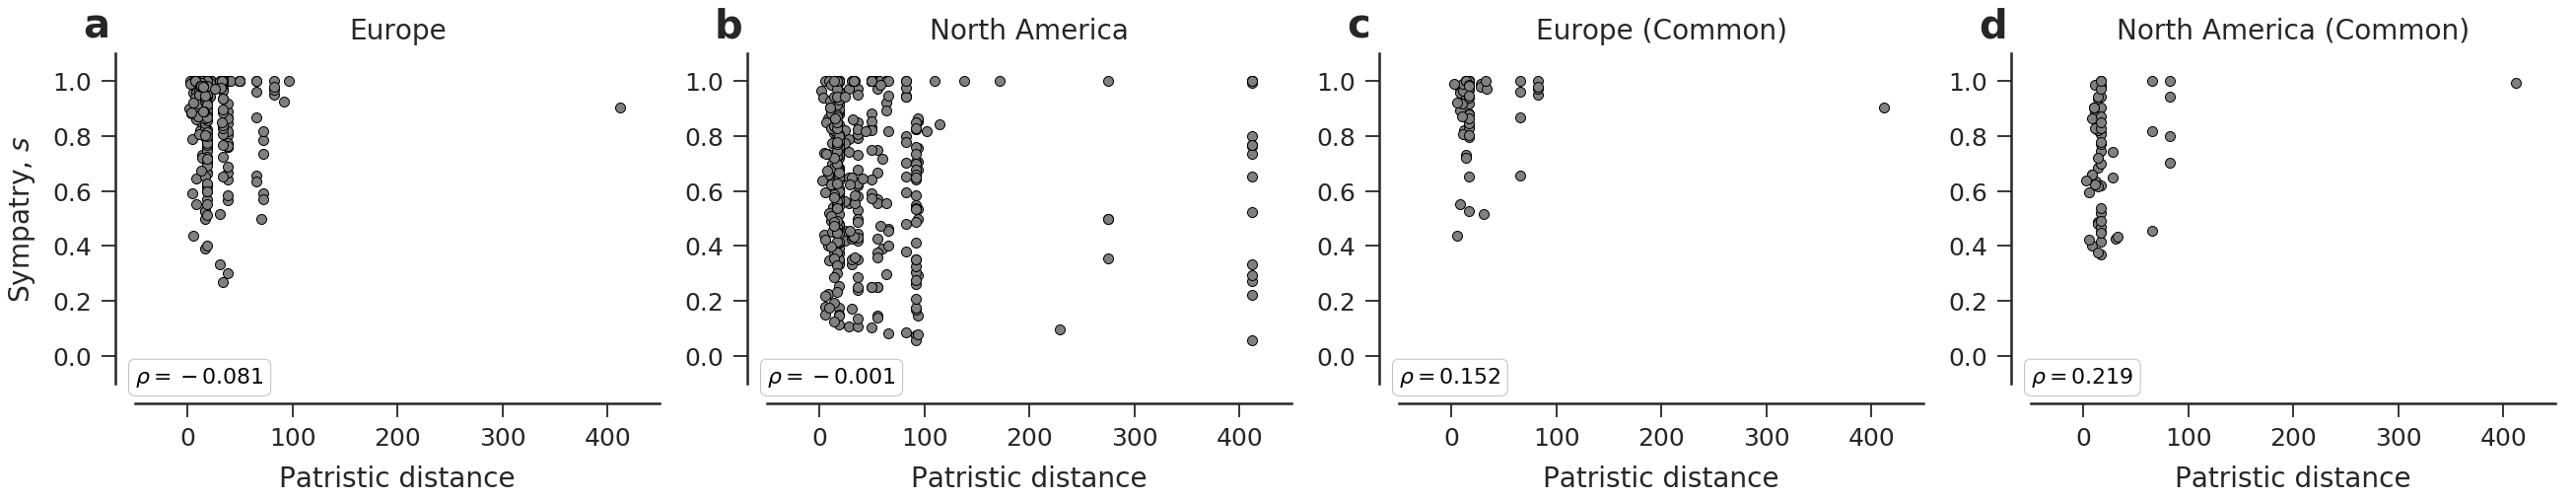

In [226]:
fig, ax = plt.subplots(1, 4, figsize=stdfigsize(ny=1, nx=4))

axis_aesthetics(fig)
place_axes_label(fig)

kwargs=dict(lw=0, marker='o', markersize=10, markeredgecolor='black', color='gray', legend=False)
text_kwargs = dict(color='black', fontsize=22, bbox=dict(facecolor='white', edgecolor='gray', alpha=.5, boxstyle='round, pad=.3'))

l = [symp_phylo_europe_200200, 
    symp_phylo_north_america_200200,
    symp_phylo_europe_common_200200,
    symp_phylo_north_america_common_200200]

for n, _ax in enumerate(fig.get_axes()):
    l[n].plot('pdist', 'sympatry', ax=_ax, **kwargs)
    _ax.text(0, 0, 
               '$\\rho = {:.3f}$'.format(l[n][['pdist', 'sympatry']].astype(float).corr(method='spearman').iloc[0][1]), 
#                '$\\rho=$ {:.3f}\nCI 95%: [{:.3f}, {:.3f}]\n$p < 0.01$'.format(df_stats['spearman_mean'], df_stats['spearman_5CI'], df_stats['spearman_95CI'])
               transform=_ax.transAxes,
               **text_kwargs)
    _ax.set_xlabel('Patristic distance')
    _ax.set_ylim([-0.1, 1.1])
    _ax.set_yticks(np.arange(0,1.2,0.2))
    _ax.set_xlim([-50, 450])
    _ax.set_title(['Europe', 'North America', 'Europe (Common)', 'North America (Common)'][n])
    if n == 0 :
        _ax.set_ylabel('Sympatry, $s$')

fig.tight_layout()
# fig.savefig('figures/pdist_symp_corr.pdf', bbox_inches='tight')
# fig.savefig('figures/pdist_symp_corr.png', bbox_inches='tight')

## Patristic distance $\times$ area_diff
<a id="patristic-distance-area"></a>
<a href="#summary">Summary</a>

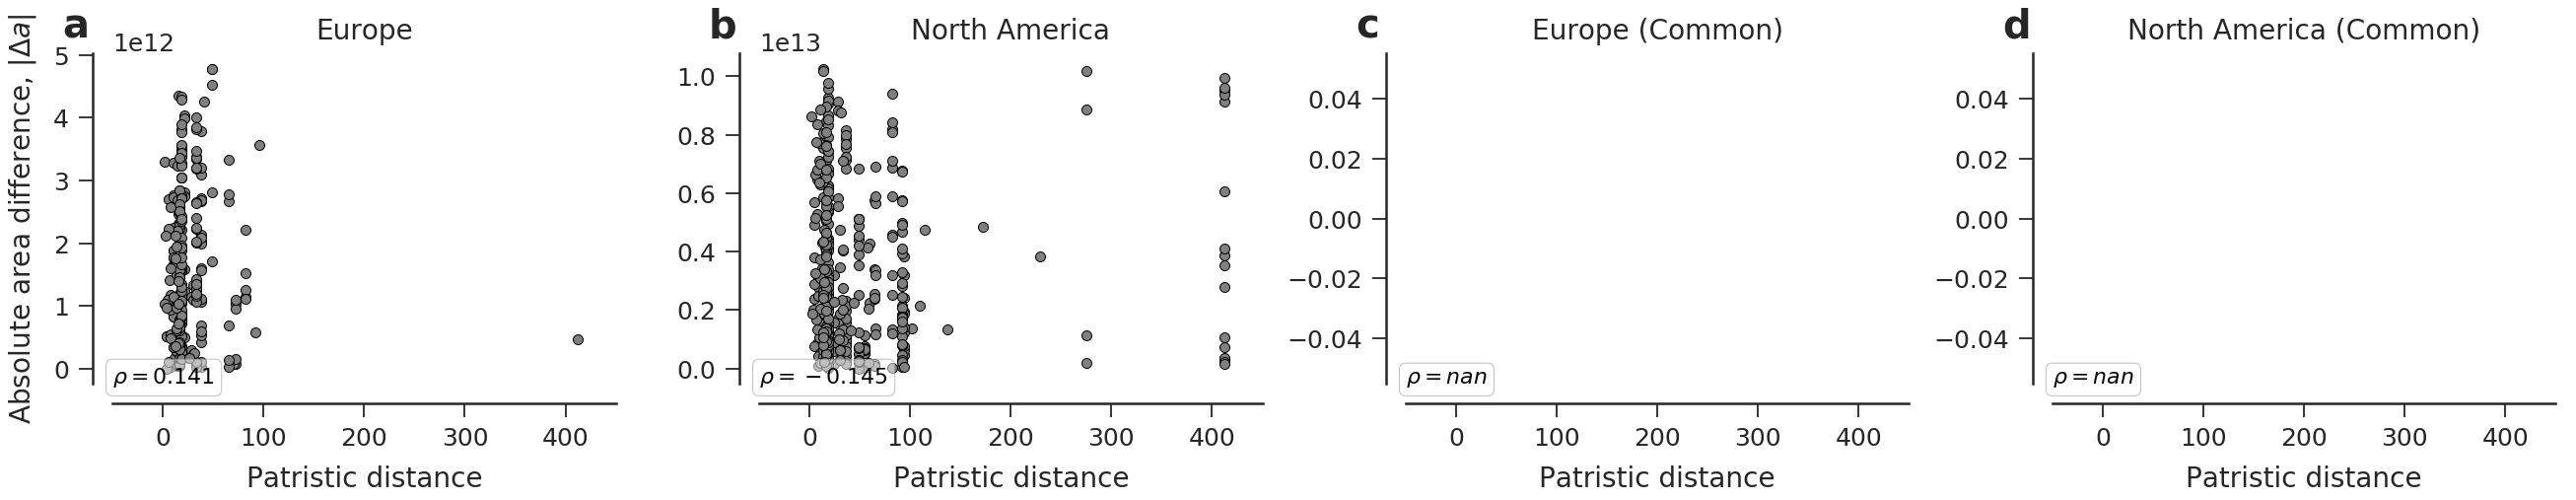

In [227]:
fig, ax = plt.subplots(1, 4, figsize=stdfigsize(ny=1, nx=4))

axis_aesthetics(fig)
place_axes_label(fig)

kwargs=dict(lw=0, marker='o', markersize=10, markeredgecolor='black', color='gray', legend=False)
text_kwargs = dict(color='black', fontsize=22, bbox=dict(facecolor='white', edgecolor='gray', alpha=.5, boxstyle='round, pad=.3'))

l = [symp_phylo_europe_5050, 
    symp_phylo_north_america_5050,
    symp_phylo_europe_common_5050,
    symp_phylo_north_america_common_5050]

for n, _ax in enumerate(fig.get_axes()):
    l[n].plot('pdist', 'area_diff', ax=_ax, **kwargs)
    _ax.text(0, 0, 
               '$\\rho = {:.3f}$'.format(l[n][['pdist', 'area_diff']].astype(float).corr(method='spearman').iloc[0][1]), 
#                '$\\rho=$ {:.3f}\nCI 95%: [{:.3f}, {:.3f}]\n$p < 0.01$'.format(df_stats['spearman_mean'], df_stats['spearman_5CI'], df_stats['spearman_95CI'])
               transform=_ax.transAxes,
               **text_kwargs)
    _ax.set_xlabel('Patristic distance')
#     _ax.set_ylim([-0.1, 1.1])
#     _ax.set_yticks(np.arange(0,1.2,0.2))
    _ax.set_xlim([-50, 450])
    _ax.set_title(['Europe', 'North America', 'Europe (Common)', 'North America (Common)'][n])
    if n == 0 :
        _ax.set_ylabel('Absolute area difference, $|\Delta a|$')

fig.tight_layout()
# fig.savefig('figures/pdist_symp_corr.pdf', bbox_inches='tight')
# fig.savefig('figures/pdist_symp_corr.png', bbox_inches='tight')

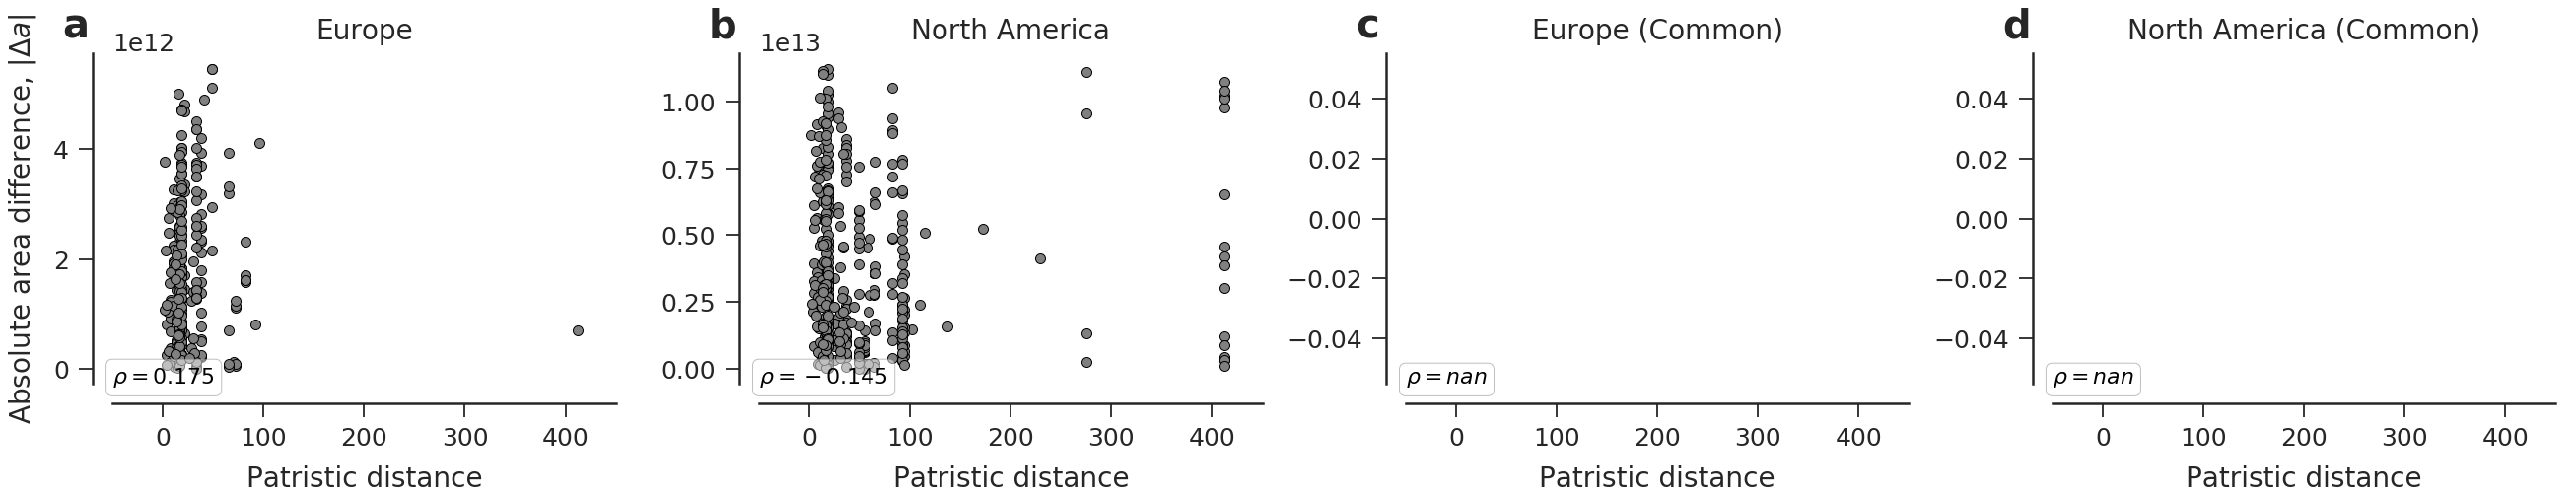

In [228]:
fig, ax = plt.subplots(1, 4, figsize=stdfigsize(ny=1, nx=4))

axis_aesthetics(fig)
place_axes_label(fig)

kwargs=dict(lw=0, marker='o', markersize=10, markeredgecolor='black', color='gray', legend=False)
text_kwargs = dict(color='black', fontsize=22, bbox=dict(facecolor='white', edgecolor='gray', alpha=.5, boxstyle='round, pad=.3'))

l = [symp_phylo_europe_100100, 
    symp_phylo_north_america_100100,
    symp_phylo_europe_common_100100,
    symp_phylo_north_america_common_100100]

for n, _ax in enumerate(fig.get_axes()):
    l[n].plot('pdist', 'area_diff', ax=_ax, **kwargs)
    _ax.text(0, 0, 
               '$\\rho = {:.3f}$'.format(l[n][['pdist', 'area_diff']].astype(float).corr(method='spearman').iloc[0][1]), 
#                '$\\rho=$ {:.3f}\nCI 95%: [{:.3f}, {:.3f}]\n$p < 0.01$'.format(df_stats['spearman_mean'], df_stats['spearman_5CI'], df_stats['spearman_95CI'])
               transform=_ax.transAxes,
               **text_kwargs)
    _ax.set_xlabel('Patristic distance')
#     _ax.set_ylim([-0.1, 1.1])
#     _ax.set_yticks(np.arange(0,1.2,0.2))
    _ax.set_xlim([-50, 450])
    _ax.set_title(['Europe', 'North America', 'Europe (Common)', 'North America (Common)'][n])
    if n == 0 :
        _ax.set_ylabel('Absolute area difference, $|\Delta a|$')

fig.tight_layout()
# fig.savefig('figures/pdist_symp_corr.pdf', bbox_inches='tight')
# fig.savefig('figures/pdist_symp_corr.png', bbox_inches='tight')

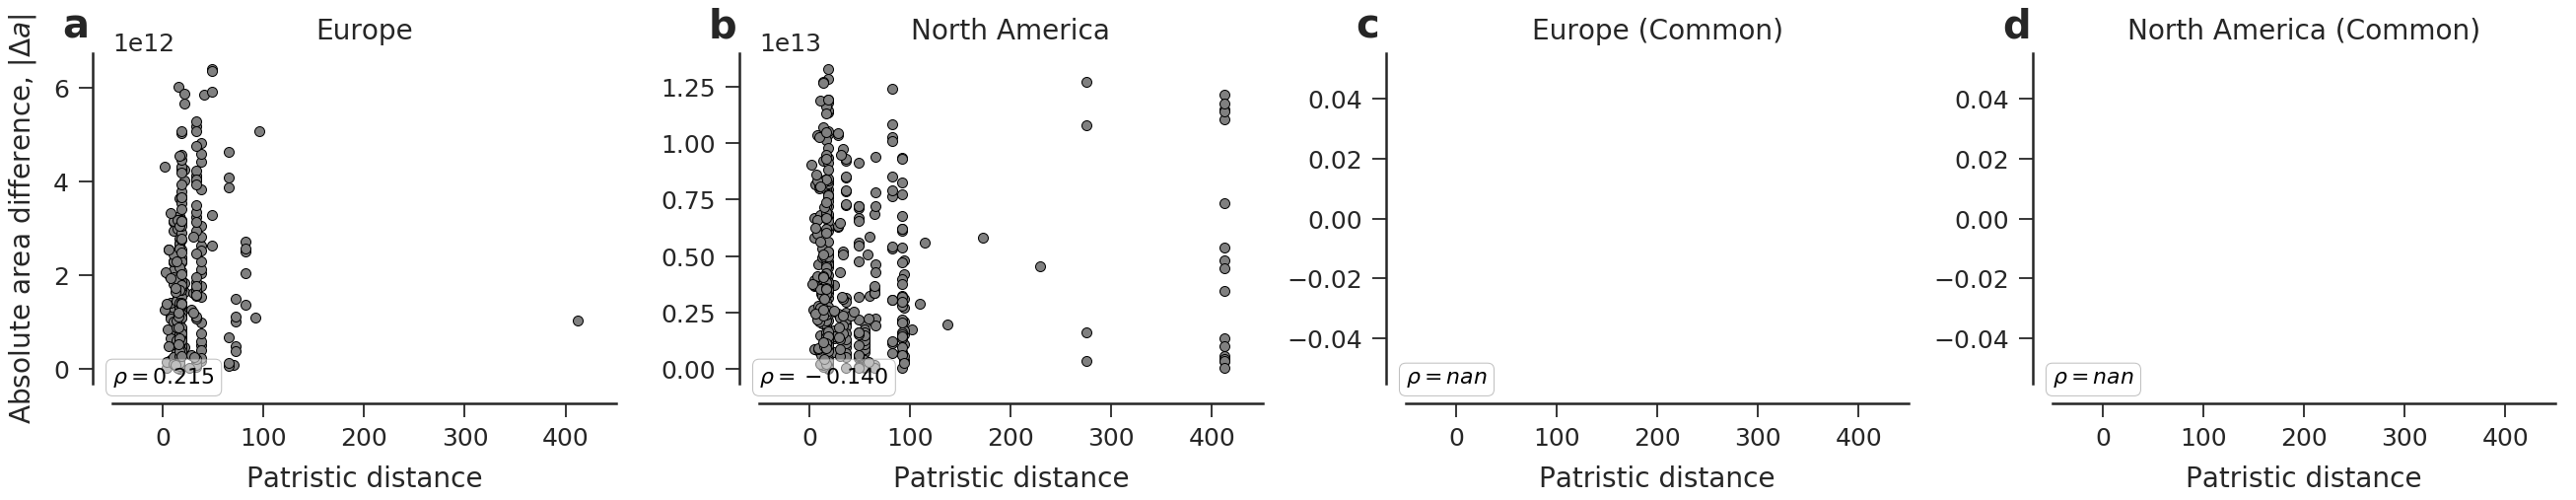

In [229]:
fig, ax = plt.subplots(1, 4, figsize=stdfigsize(ny=1, nx=4))

axis_aesthetics(fig)
place_axes_label(fig)

kwargs=dict(lw=0, marker='o', markersize=10, markeredgecolor='black', color='gray', legend=False)
text_kwargs = dict(color='black', fontsize=22, bbox=dict(facecolor='white', edgecolor='gray', alpha=.5, boxstyle='round, pad=.3'))

l = [symp_phylo_europe_200200, 
    symp_phylo_north_america_200200,
    symp_phylo_europe_common_200200,
    symp_phylo_north_america_common_200200]

for n, _ax in enumerate(fig.get_axes()):
    l[n].plot('pdist', 'area_diff', ax=_ax, **kwargs)
    _ax.text(0, 0, 
               '$\\rho = {:.3f}$'.format(l[n][['pdist', 'area_diff']].astype(float).corr(method='spearman').iloc[0][1]), 
#                '$\\rho=$ {:.3f}\nCI 95%: [{:.3f}, {:.3f}]\n$p < 0.01$'.format(df_stats['spearman_mean'], df_stats['spearman_5CI'], df_stats['spearman_95CI'])
               transform=_ax.transAxes,
               **text_kwargs)
    _ax.set_xlabel('Patristic distance')
#     _ax.set_ylim([-0.1, 1.1])
#     _ax.set_yticks(np.arange(0,1.2,0.2))
    _ax.set_xlim([-50, 450])
    _ax.set_title(['Europe', 'North America', 'Europe (Common)', 'North America (Common)'][n])
    if n == 0 :
        _ax.set_ylabel('Absolute area difference, $|\Delta a|$')

fig.tight_layout()
# fig.savefig('figures/pdist_symp_corr.pdf', bbox_inches='tight')
# fig.savefig('figures/pdist_symp_corr.png', bbox_inches='tight')

## Patristic distance $\times$ grids_diff
<a id="patristic-distance-grids"></a>
<a href="#summary">Summary</a>

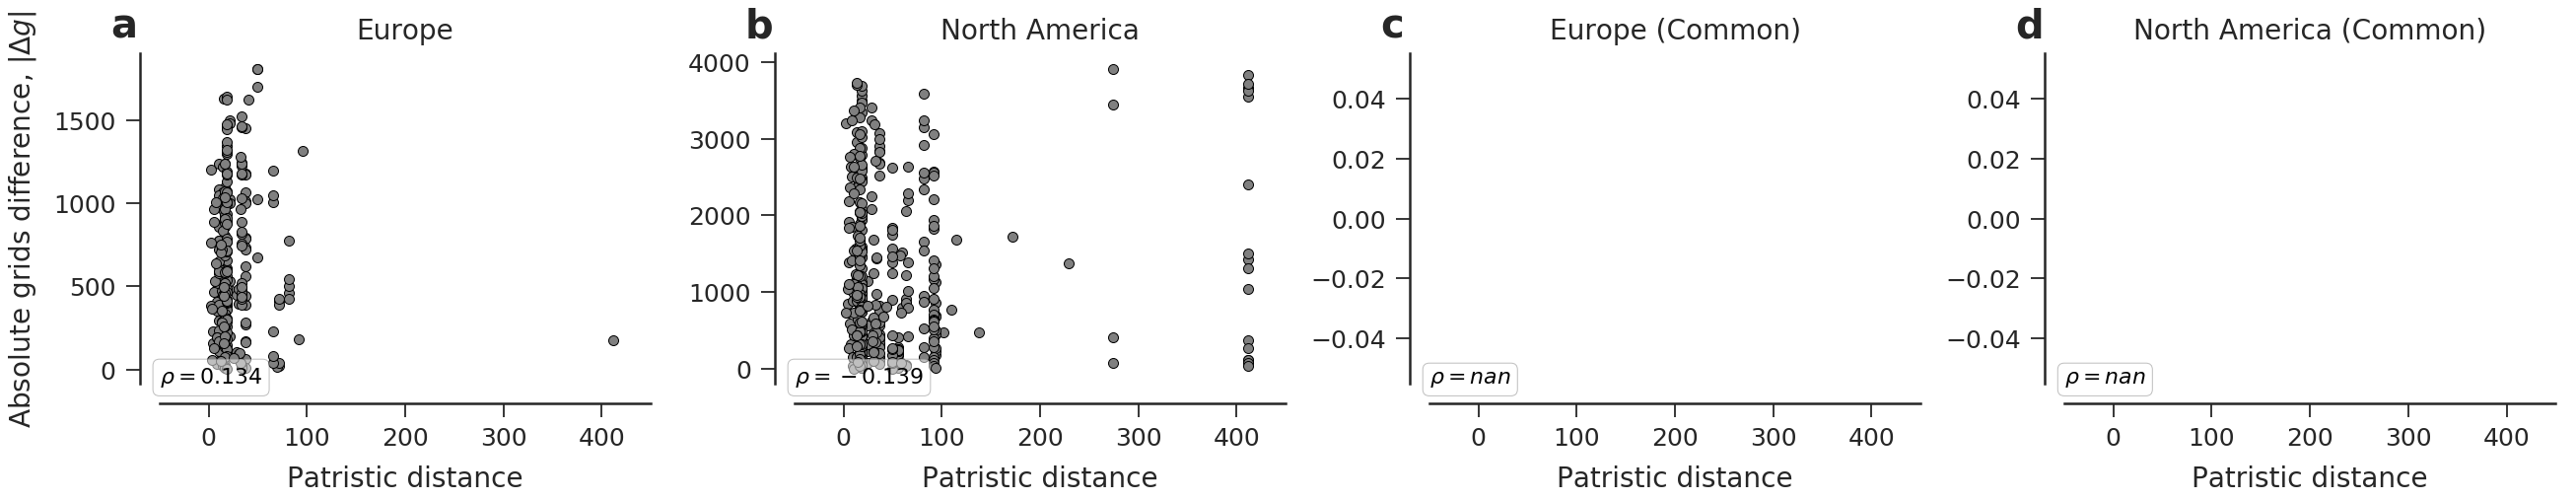

In [230]:
fig, ax = plt.subplots(1, 4, figsize=stdfigsize(ny=1, nx=4))

axis_aesthetics(fig)
place_axes_label(fig)

kwargs=dict(lw=0, marker='o', markersize=10, markeredgecolor='black', color='gray', legend=False)
text_kwargs = dict(color='black', fontsize=22, bbox=dict(facecolor='white', edgecolor='gray', alpha=.5, boxstyle='round, pad=.3'))

l = [symp_phylo_europe_5050, 
    symp_phylo_north_america_5050,
    symp_phylo_europe_common_5050,
    symp_phylo_north_america_common_5050]

for n, _ax in enumerate(fig.get_axes()):
    l[n].plot('pdist', 'grids_diff', ax=_ax, **kwargs)
    _ax.text(0, 0, 
               '$\\rho = {:.3f}$'.format(l[n][['pdist', 'grids_diff']].astype(float).corr(method='spearman').iloc[0][1]), 
#                '$\\rho=$ {:.3f}\nCI 95%: [{:.3f}, {:.3f}]\n$p < 0.01$'.format(df_stats['spearman_mean'], df_stats['spearman_5CI'], df_stats['spearman_95CI'])
               transform=_ax.transAxes,
               **text_kwargs)
    _ax.set_xlabel('Patristic distance')
#     _ax.set_ylim([-0.1, 1.1])
#     _ax.set_yticks(np.arange(0,1.2,0.2))
    _ax.set_xlim([-50, 450])
    _ax.set_title(['Europe', 'North America', 'Europe (Common)', 'North America (Common)'][n])
    if n == 0 :
        _ax.set_ylabel('Absolute grids difference, $|\Delta g|$')

fig.tight_layout()
# fig.savefig('figures/pdist_symp_corr.pdf', bbox_inches='tight')
# fig.savefig('figures/pdist_symp_corr.png', bbox_inches='tight')

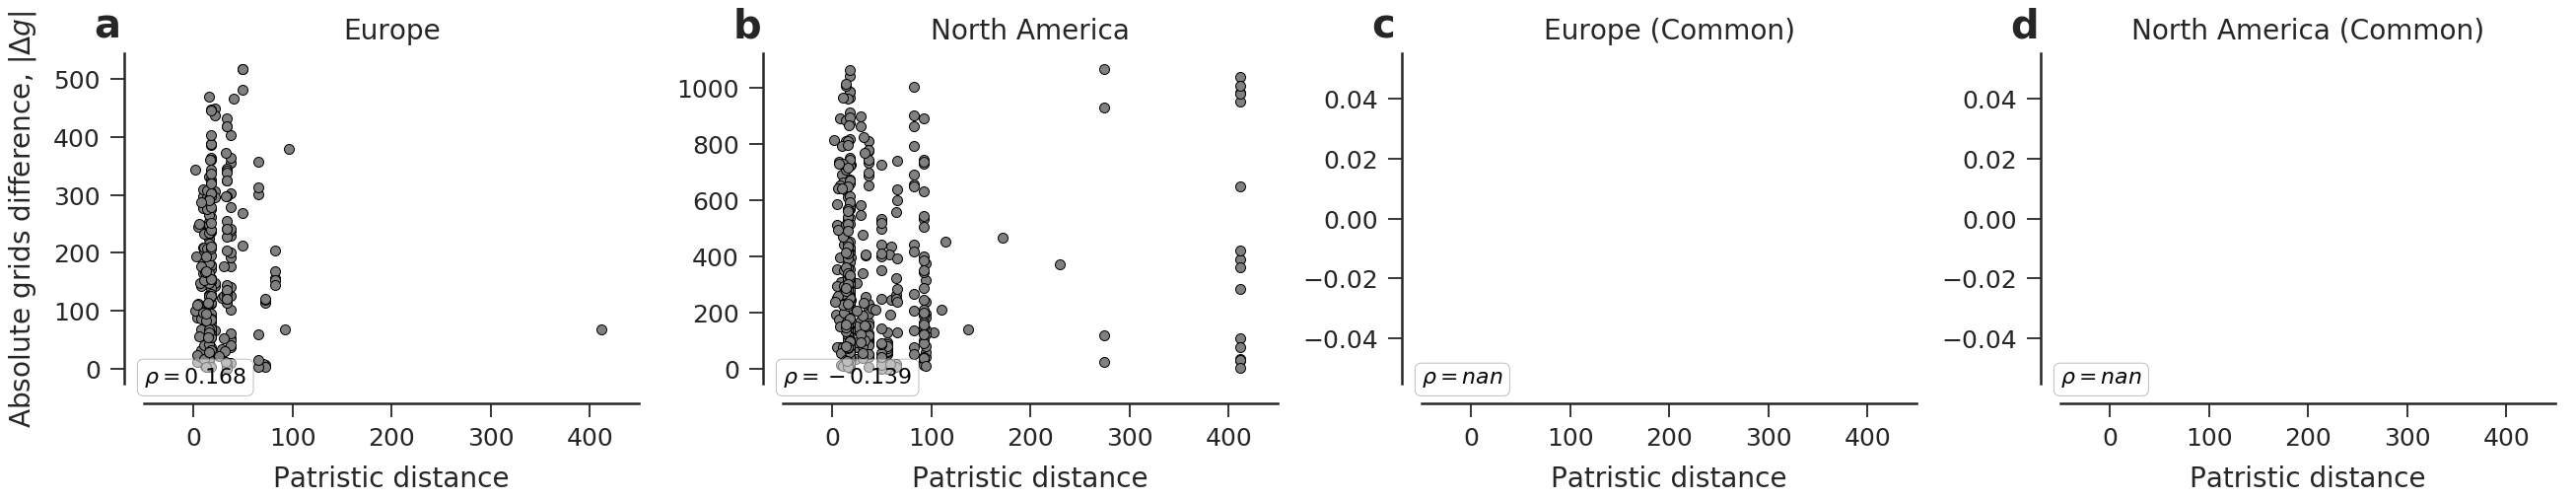

In [231]:
fig, ax = plt.subplots(1, 4, figsize=stdfigsize(ny=1, nx=4))

axis_aesthetics(fig)
place_axes_label(fig)

kwargs=dict(lw=0, marker='o', markersize=10, markeredgecolor='black', color='gray', legend=False)
text_kwargs = dict(color='black', fontsize=22, bbox=dict(facecolor='white', edgecolor='gray', alpha=.5, boxstyle='round, pad=.3'))

l = [symp_phylo_europe_100100, 
    symp_phylo_north_america_100100,
    symp_phylo_europe_common_100100,
    symp_phylo_north_america_common_100100]

for n, _ax in enumerate(fig.get_axes()):
    l[n].plot('pdist', 'grids_diff', ax=_ax, **kwargs)
    _ax.text(0, 0, 
               '$\\rho = {:.3f}$'.format(l[n][['pdist', 'grids_diff']].astype(float).corr(method='spearman').iloc[0][1]), 
#                '$\\rho=$ {:.3f}\nCI 95%: [{:.3f}, {:.3f}]\n$p < 0.01$'.format(df_stats['spearman_mean'], df_stats['spearman_5CI'], df_stats['spearman_95CI'])
               transform=_ax.transAxes,
               **text_kwargs)
    _ax.set_xlabel('Patristic distance')
#     _ax.set_ylim([-0.1, 1.1])
#     _ax.set_yticks(np.arange(0,1.2,0.2))
    _ax.set_xlim([-50, 450])
    _ax.set_title(['Europe', 'North America', 'Europe (Common)', 'North America (Common)'][n])
    if n == 0 :
        _ax.set_ylabel('Absolute grids difference, $|\Delta g|$')

fig.tight_layout()
# fig.savefig('figures/pdist_symp_corr.pdf', bbox_inches='tight')
# fig.savefig('figures/pdist_symp_corr.png', bbox_inches='tight')

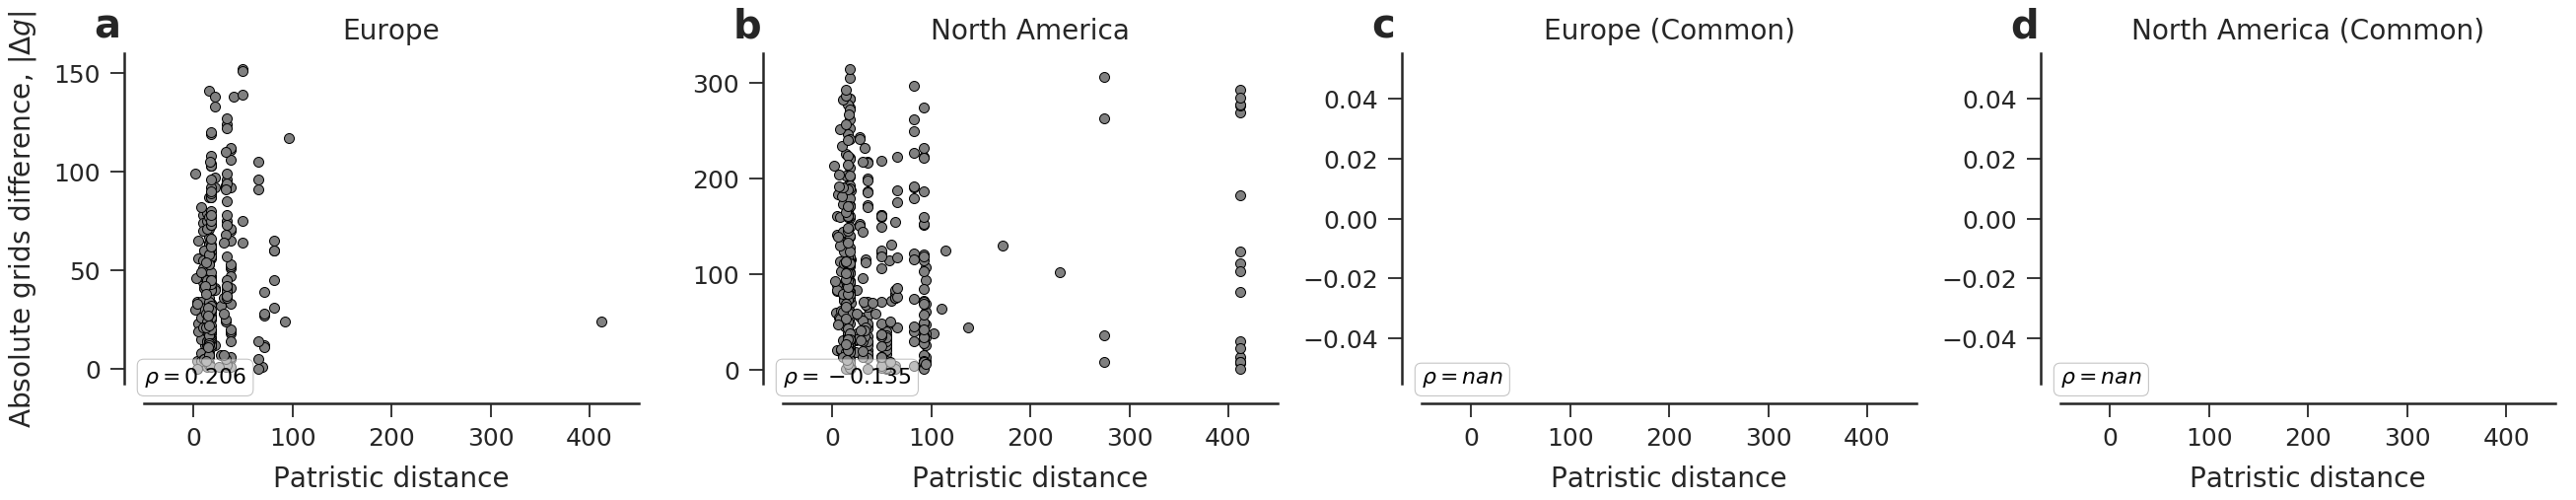

In [232]:
fig, ax = plt.subplots(1, 4, figsize=stdfigsize(ny=1, nx=4))

axis_aesthetics(fig)
place_axes_label(fig)

kwargs=dict(lw=0, marker='o', markersize=10, markeredgecolor='black', color='gray', legend=False)
text_kwargs = dict(color='black', fontsize=22, bbox=dict(facecolor='white', edgecolor='gray', alpha=.5, boxstyle='round, pad=.3'))

l = [symp_phylo_europe_200200, 
    symp_phylo_north_america_200200,
    symp_phylo_europe_common_200200,
    symp_phylo_north_america_common_200200]

for n, _ax in enumerate(fig.get_axes()):
    l[n].plot('pdist', 'grids_diff', ax=_ax, **kwargs)
    _ax.text(0, 0, 
               '$\\rho = {:.3f}$'.format(l[n][['pdist', 'grids_diff']].astype(float).corr(method='spearman').iloc[0][1]), 
#                '$\\rho=$ {:.3f}\nCI 95%: [{:.3f}, {:.3f}]\n$p < 0.01$'.format(df_stats['spearman_mean'], df_stats['spearman_5CI'], df_stats['spearman_95CI'])
               transform=_ax.transAxes,
               **text_kwargs)
    _ax.set_xlabel('Patristic distance')
#     _ax.set_ylim([-0.1, 1.1])
#     _ax.set_yticks(np.arange(0,1.2,0.2))
    _ax.set_xlim([-50, 450])
    _ax.set_title(['Europe', 'North America', 'Europe (Common)', 'North America (Common)'][n])
    if n == 0 :
        _ax.set_ylabel('Absolute grids difference, $|\Delta g|$')

fig.tight_layout()
# fig.savefig('figures/pdist_symp_corr.pdf', bbox_inches='tight')
# fig.savefig('figures/pdist_symp_corr.png', bbox_inches='tight')

## Correlation of all variables
<a id="correlation-of-all-variables"></a>
<a href="#summary">Summary</a>

In [233]:
def pdist_interval_areas(df, interval='open'):

    l = []
    for distance in np.linspace(10, 420, 84):
        
        if interval == 'closed':
            _df = df[(df['pdist'] >= distance-10) & (df['pdist'] <= distance)]
        elif interval == 'open':
            _df = df[(df['pdist'] <= distance)]
        
        num_pairs = _df.shape[0]
        corr_pairs = _df[['area1', 'area2']].astype(float).corr().iloc[0][1]

        l.append([num_pairs, corr_pairs])

    arr = np.asarray(l)

    return arr

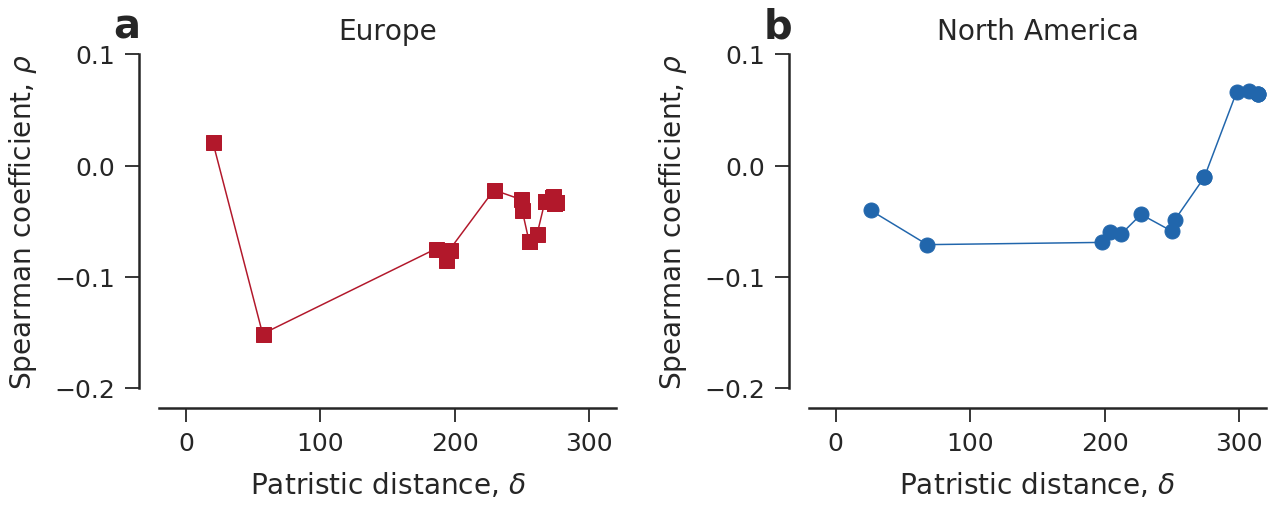

In [234]:
fig, ax = plt.subplots(1, 2, figsize=stdfigsize(ny=1, nx=2))

axis_aesthetics(fig)
place_axes_label(fig)

colors = palettable.colorbrewer.diverging.RdBu_11.mpl_colors

ax[0].plot(*pdist_interval_areas(symp_phylo_europe_5050).T, marker='s', markersize=15, color=colors[1])

# ax[0].set_ylim([-0.2, 0.1])
ax[0].set_xlim([-20, 320])

ax[1].plot(*pdist_interval_areas(symp_phylo_north_america_5050).T, marker='o', markersize=15, color=colors[9])

# ax[1].set_ylim([-0.1, 0.1])
ax[1].set_xlim([-20, 320])


for counter, _ax in enumerate(fig.get_axes()):
    _ax.set_ylim([-0.2, 0.1])
    _ax.set_title(['Europe', 'North America'][counter])
    _ax.set_xlabel('Patristic distance, $\\delta$')
    _ax.set_ylabel('Spearman coefficient, $\\rho$')


fig.tight_layout()
# fig.savefig('../figures/pdist_overlap_intervals_corr.pdf', bbox_inches='tight')
# fig.savefig('../figures/pdist_overlap_intervals_corr.png', bbox_inches='tight')

## Correlation between sympatry in different scales
<a id="correlation-between-sympatry-in-different-scales"></a>
<a href="#summary">Summary</a>

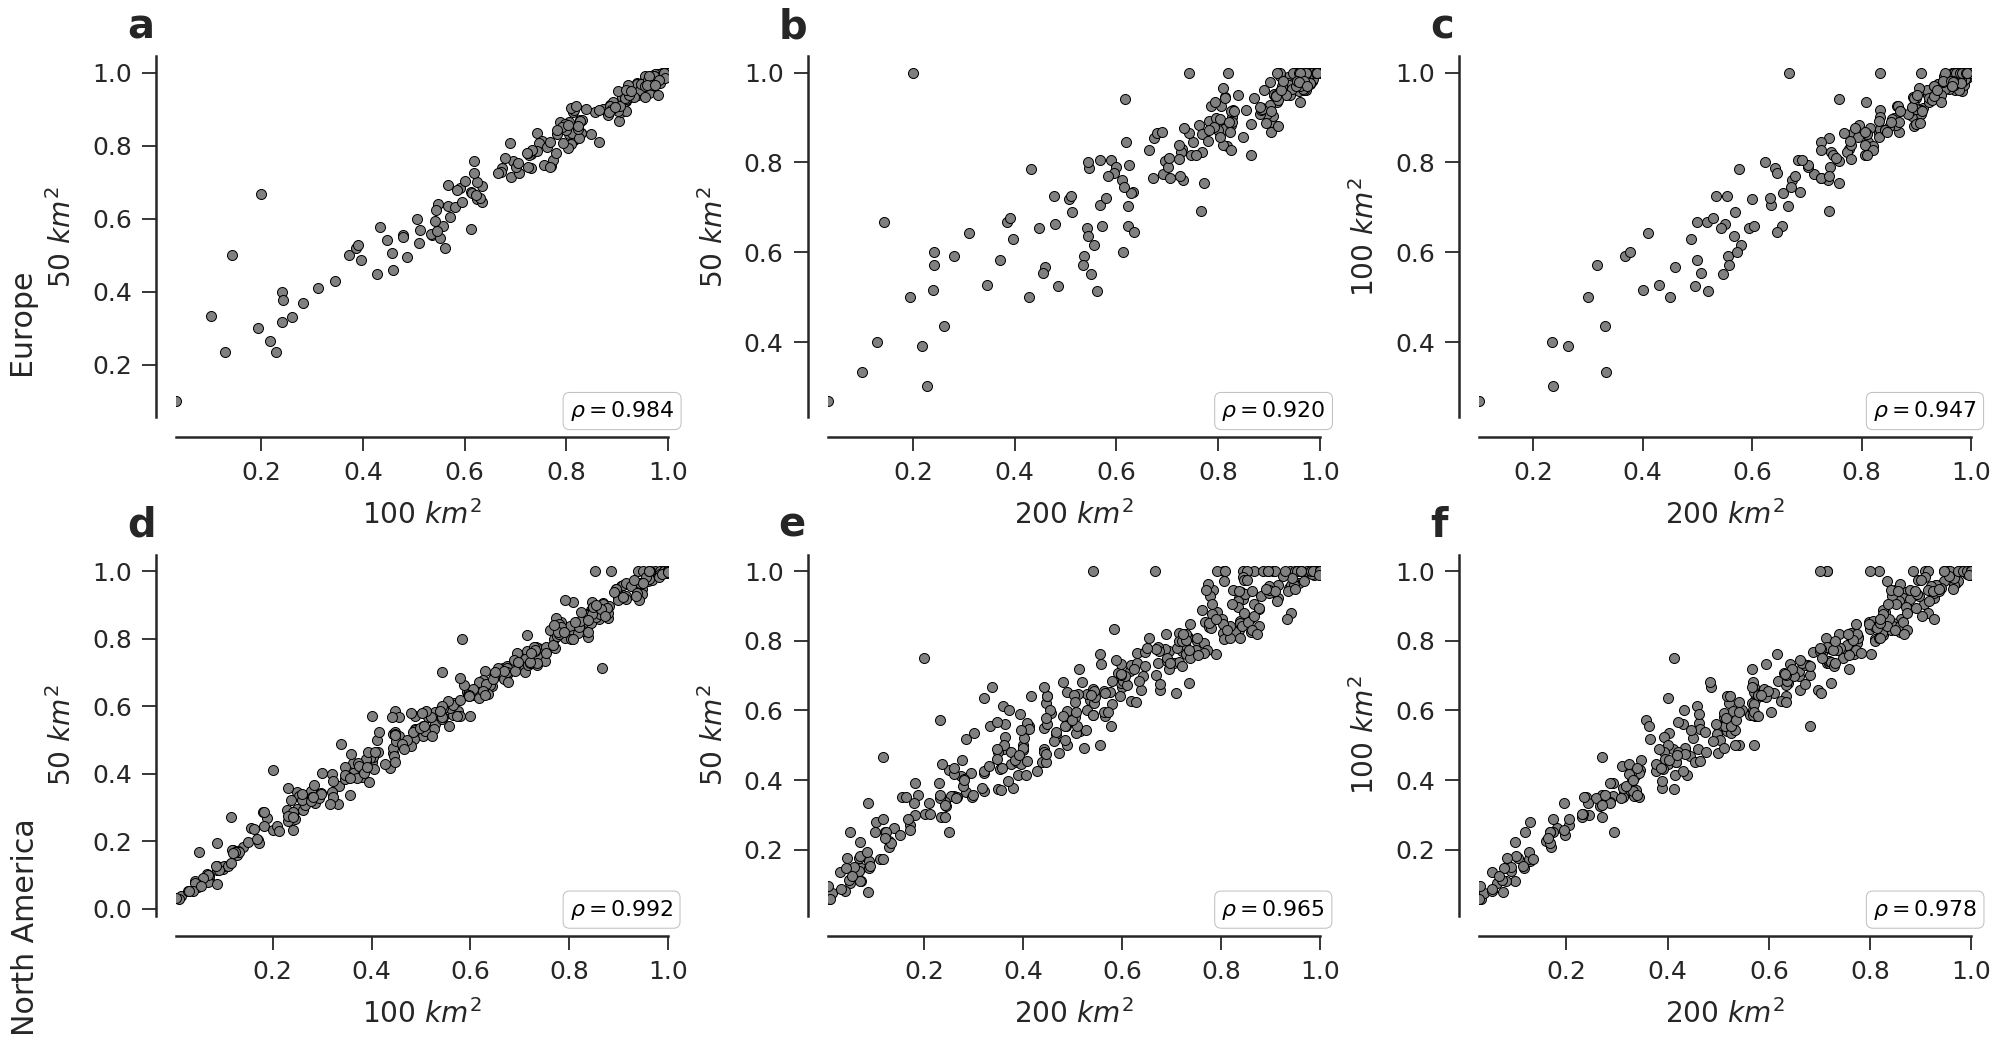

In [237]:
fig, ax = plt.subplots(2, 3, figsize=stdfigsize(ny=2, nx=3))

axis_aesthetics(fig)
place_axes_label(fig)

kwargs=dict(lw=0, marker='o', markersize=10, markeredgecolor='black', color='gray', legend=False)
text_kwargs = dict(color='black', fontsize=22, bbox=dict(facecolor='white', edgecolor='gray', alpha=.5, boxstyle='round, pad=.3'))

l_eu = [symp_phylo_europe_5050, symp_phylo_europe_100100, symp_phylo_europe_200200]
l_na = [symp_phylo_north_america_5050, symp_phylo_north_america_100100, symp_phylo_north_america_200200]

combs = [c for c in combinations([0,1,2], 2)]
labels = ['50 $km^2$', '100 $km^2$', '200 $km^2$']
for n, _ax in enumerate(fig.get_axes()):
    if n < 3:
        df = pd.merge(l_eu[combs[n][0]], l_eu[combs[n][1]], on=['sp1', 'sp2'])
        df.plot('sympatry_x', 'sympatry_y', ax=_ax, **kwargs)
        _ax.text(0.8,0,
                '$\\rho = {:.3f}$'.format(df[['sympatry_x', 'sympatry_y']].astype(float).corr(method='spearman').iloc[0][1]),
                transform=_ax.transAxes,
                **text_kwargs)
        _ax.set_ylabel(labels[combs[n][0]])
        _ax.set_xlabel(labels[combs[n][1]])
    else:
        df = pd.merge(l_na[combs[n-3][0]], l_na[combs[n-3][1]], on=['sp1', 'sp2'])
        df.plot('sympatry_x', 'sympatry_y', ax=_ax, **kwargs)
        _ax.text(0.8,0,
                '$\\rho = {:.3f}$'.format(df[['sympatry_x', 'sympatry_y']].astype(float).corr(method='spearman').iloc[0][1]),
                transform=_ax.transAxes,
                **text_kwargs)
        _ax.set_ylabel(labels[combs[n-3][0]])
        _ax.set_xlabel(labels[combs[n-3][1]])
        
ax[0,0].text(-0.3, 0.4, 'Europe', rotation=90, fontsize=30)
ax[1,0].text(-0.33, 0.2, 'North America', rotation=90, fontsize=30)

fig.tight_layout()
# fig.savefig('figures/symp_scales_corr.pdf', bbox_inches='tight')
# fig.savefig('figures/symp_scales_corr.png', bbox_inches='tight')

# Correlation between environmental variables of pairs and their phylogenetic distance
<a id="correlation-between-environmental-variables"></a>
<a href="#summary">Summary</a>

In [238]:
def overlap_with_ksdistance(df, genus_pair):

    # features to use and compare their distributions
    features = ['mean_temp', 'mean_prec', 'mean_vtemp', 'alkalinity', 'lgm']

    features_pvalues_dict = {}
    # loop through the features
    for feature in features:
    #     feature = features[0] # REMOVE
        # list to append the p-value of the comaparison between the distributions
        feature_dist_comparison_pvalue = []
        overlapping_pairs_list = []
        overlapping_names_list = []
        overlapping_grids_list = []
        sympatry_values_list  = []

        # loop through all the rows, which considers all pairs of codes for the pairs of species that overlap
        for row in range(genus_pair.shape[0]):

            # the pair of species, selected by their unique code
            pair  = list(genus_pair.loc[row, ['codes1', 'codes2']])
            names = list(genus_pair.loc[row, ['sp1', 'sp2']])

            # mask the grids where they appear together
            df_overlay = df[df[pair].sum(axis=1) == 2]

            if df_overlay.shape[0] != 0:
                # pd.DataFrame with the environmental variables' values for the first of the pair
                feature_values_sp1 = df[df[pair[0]] == 1][feature]
                # pd.DataFrame with the environmental variables' values for the second of the pair
                feature_values_sp2 = df[df[pair[1]] == 1][feature]

                # normalize the features
                feature_values_sp1 = (feature_values_sp1 - feature_values_sp1.mean())/(feature_values_sp1.std())
                feature_values_sp2 = (feature_values_sp2 - feature_values_sp2.mean())/(feature_values_sp2.std())

                feature_dist_comparison_pvalue.append(scipy.stats.ks_2samp(feature_values_sp1, feature_values_sp2)[1])

                if feature == features[-1]:

                    pair_grids = [df[df[sp] == 1].shape[0] for sp in pair]
                    overlapping_pairs_list.append(pair)
                    overlapping_names_list.append(names)
                    overlapping_grids_list.append(pair_grids)
                    sympatry_values_list.append(df_overlay.shape[0]/min(pair_grids))

        features_pvalues_dict[feature + '_ks_pvalue'] = feature_dist_comparison_pvalue

    codes_grids_sympatry_df = pd.DataFrame(data=[
        np.asarray(overlapping_names_list).transpose()[0],
        np.asarray(overlapping_names_list).transpose()[1],
        np.asarray(overlapping_pairs_list).transpose()[0],
        np.asarray(overlapping_pairs_list).transpose()[1],
        np.asarray(overlapping_grids_list).transpose()[0],
        np.asarray(overlapping_grids_list).transpose()[1],                                                  
        np.asarray(sympatry_values_list)
    ]
    ).transpose()

    codes_grids_sympatry_df.columns = ['sp1', 'sp2', 'codes1', 'codes2', 'grids_sp1', 'grids_sp2', 'sympatry']

    features_pvalues_df = pd.DataFrame(features_pvalues_dict)

    return pd.concat([codes_grids_sympatry_df, features_pvalues_df], axis=1)


In [239]:
overlap_with_ksdistance_europe_5050   = overlap_with_ksdistance(occurrences_within_5050_grid_europe_filtered, genus_pairs_df_europe)
overlap_with_ksdistance_europe_100100 = overlap_with_ksdistance(occurrences_within_100100_grid_europe_filtered, genus_pairs_df_europe)
overlap_with_ksdistance_europe_200200 = overlap_with_ksdistance(occurrences_within_200200_grid_europe_filtered, genus_pairs_df_europe)

overlap_with_ksdistance_europe_common_5050   = overlap_with_ksdistance(occurrences_within_5050_grid_europe_filtered, genus_pairs_df_europe_common)
overlap_with_ksdistance_europe_common_100100 = overlap_with_ksdistance(occurrences_within_100100_grid_europe_filtered, genus_pairs_df_europe_common)
overlap_with_ksdistance_europe_common_200200 = overlap_with_ksdistance(occurrences_within_200200_grid_europe_filtered, genus_pairs_df_europe_common)

In [240]:
overlap_with_ksdistance_north_america_5050   = overlap_with_ksdistance(occurrences_within_5050_grid_north_america_filtered, genus_pairs_df_north_america)
overlap_with_ksdistance_north_america_100100 = overlap_with_ksdistance(occurrences_within_100100_grid_north_america_filtered, genus_pairs_df_north_america)
overlap_with_ksdistance_north_america_200200 = overlap_with_ksdistance(occurrences_within_200200_grid_north_america_filtered, genus_pairs_df_north_america)

overlap_with_ksdistance_north_america_common_5050   = overlap_with_ksdistance(occurrences_within_5050_grid_north_america_filtered, genus_pairs_df_north_america_common)
overlap_with_ksdistance_north_america_common_100100 = overlap_with_ksdistance(occurrences_within_100100_grid_north_america_filtered, genus_pairs_df_north_america_common)
overlap_with_ksdistance_north_america_common_200200 = overlap_with_ksdistance(occurrences_within_200200_grid_north_america_filtered, genus_pairs_df_north_america_common)

In [241]:
def join_env_phylo(df):
    l_arr = []
    for i in range(df.shape[0]):
        
        curr_pair = df.iloc[i][df.columns]
        
        phylo_df = coph_distance[(coph_distance['sp1'] == curr_pair[0]) &
                                (coph_distance['sp2'] == curr_pair[1])]
        
        if phylo_df.shape[0] > 0:
            
            arr = np.concatenate([
                                    np.asarray(
                                    coph_distance[(coph_distance['sp1'] == curr_pair[0]) & 
                                                  (coph_distance['sp2'] == curr_pair[1])
                                                 ]
                                                ), 
                                    np.asarray(curr_pair[2:])], axis=None
                                )
            
            l_arr.append(arr)
            
    return pd.DataFrame(np.asarray(l_arr), columns=['sp1', 'sp2', 'pdist', ] + list(df.columns[2:]))

In [242]:
env_phylo_europe_5050   = join_env_phylo(overlap_with_ksdistance_europe_5050)
env_phylo_europe_100100 = join_env_phylo(overlap_with_ksdistance_europe_100100)
env_phylo_europe_200200 = join_env_phylo(overlap_with_ksdistance_europe_200200)

env_phylo_europe_common_5050   = join_env_phylo(overlap_with_ksdistance_europe_common_5050)
env_phylo_europe_common_100100 = join_env_phylo(overlap_with_ksdistance_europe_common_100100)
env_phylo_europe_common_200200 = join_env_phylo(overlap_with_ksdistance_europe_common_200200)

In [243]:
env_phylo_north_america_5050   = join_env_phylo(overlap_with_ksdistance_north_america_5050)
env_phylo_north_america_100100 = join_env_phylo(overlap_with_ksdistance_north_america_100100)
env_phylo_north_america_200200 = join_env_phylo(overlap_with_ksdistance_north_america_200200)

env_phylo_north_america_common_5050   = join_env_phylo(overlap_with_ksdistance_north_america_common_5050)
env_phylo_north_america_common_100100 = join_env_phylo(overlap_with_ksdistance_north_america_common_100100)
env_phylo_north_america_common_200200 = join_env_phylo(overlap_with_ksdistance_north_america_common_200200)

In [244]:
def columns_to_float(df):
    df[df.columns[2:]] = df[df.columns[2:]].astype(np.float)

[columns_to_float(df) for df in [
    env_phylo_europe_5050, 
    env_phylo_europe_100100,
    env_phylo_europe_200200,
    env_phylo_europe_common_5050,
    env_phylo_europe_common_100100,
    env_phylo_europe_common_200200,
    env_phylo_north_america_5050,
    env_phylo_north_america_100100,
    env_phylo_north_america_200200,
    env_phylo_north_america_common_5050,
    env_phylo_north_america_common_100100,
    env_phylo_north_america_common_200200
]
];


In [245]:
def pretify_axes(fig):
    for counter, _ax in enumerate(fig.get_axes()):

        _ax.annotate(string.ascii_lowercase[counter], xy=(-0.1, 1.03), xycoords='axes fraction', fontsize=40, weight='bold')

        for loc, spine in _ax.spines.items():
                if loc in ['left', 'bottom']:
                    spine.set_position(('outward', 20)) # outward by 20 points
                elif loc in ['right','top']:
                    spine.set_color('none') # don't draw spine
                else:
                    raise ValueError('unknown spine location: %s'%loc)

    # Only show ticks on the left and bottom spines
    _ax.yaxis.set_ticks_position('left')
    _ax.xaxis.set_ticks_position('bottom')


In [246]:
def plot_correlations(df, NUM_ROWS=2, NUM_COLS=3):

    # list with the dependent variable of patristic distance, to evaluate their dependence.
    dependent_features_list = ['sympatry', 'mean_temp_ks_pvalue', 
                           'mean_prec_ks_pvalue', 'mean_vtemp_ks_pvalue', 
                           'alkalinity_ks_pvalue', 'lgm_ks_pvalue'
                          ]

    if NUM_ROWS*NUM_COLS != 6:
        raise ValueError("the product of number of columns and rows must be equal to 6, which is the number of dependent features.")

    # creating the figure object
    fig, ax = plt.subplots(nrows=NUM_ROWS, ncols=NUM_COLS,
                           figsize=stdfigsize(ny=NUM_ROWS, nx=NUM_COLS)
                          )

    for counter, _ax in enumerate(fig.get_axes()):

        df.plot(kind='scatter',
                x='pdist',
                y=dependent_features_list[counter],
                color='gray',
                s=50,
                edgecolor='k',
                ax=_ax
                )
    
        _ax.annotate('$\\rho$ = {:.3f}'.format(env_phylo_europe_5050.corr()['pdist'][dependent_features_list[counter]]),
                    xy=(0.6, 0.1), xycoords='axes fraction',
                    fontsize=25
                    )

    pretify_axes(fig)

    fig.tight_layout()

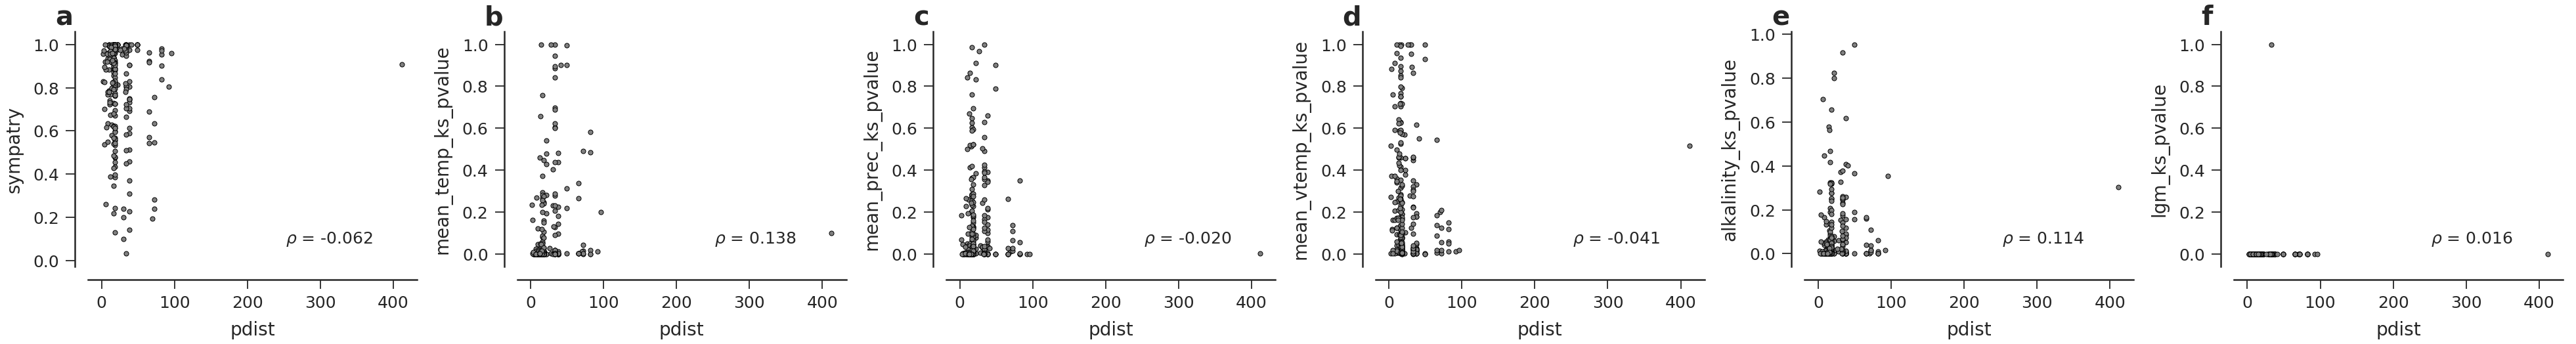

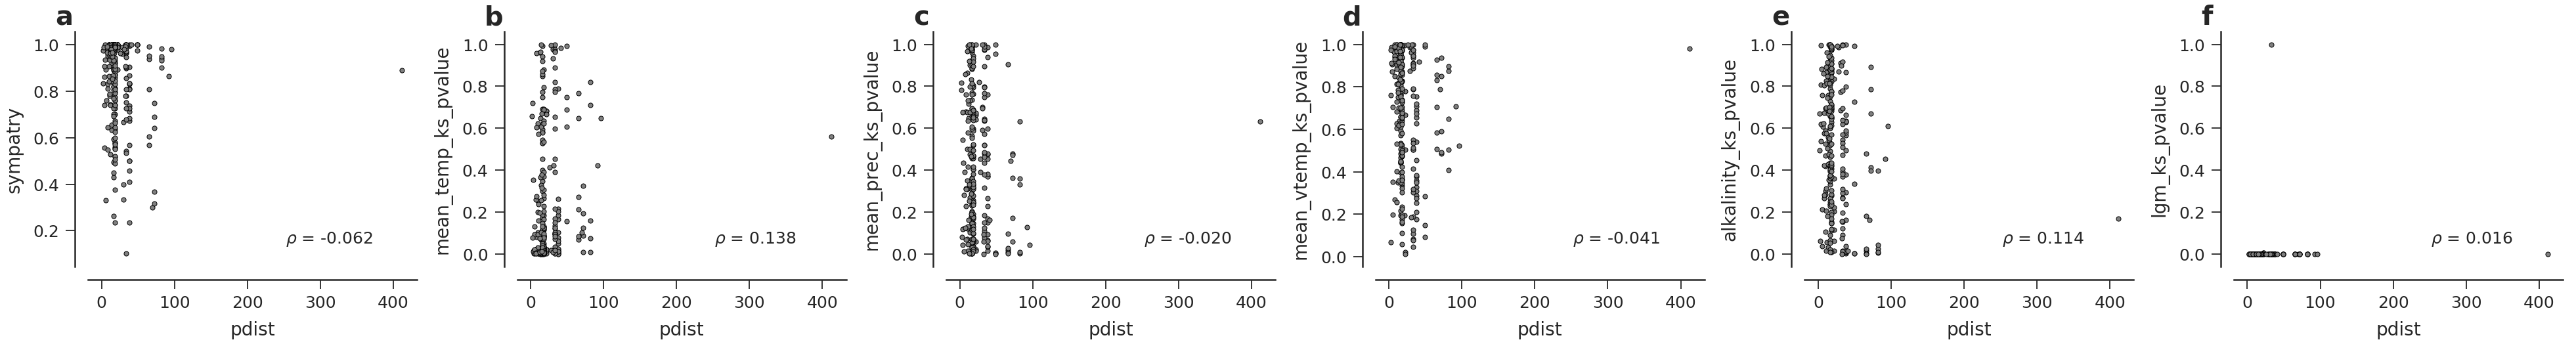

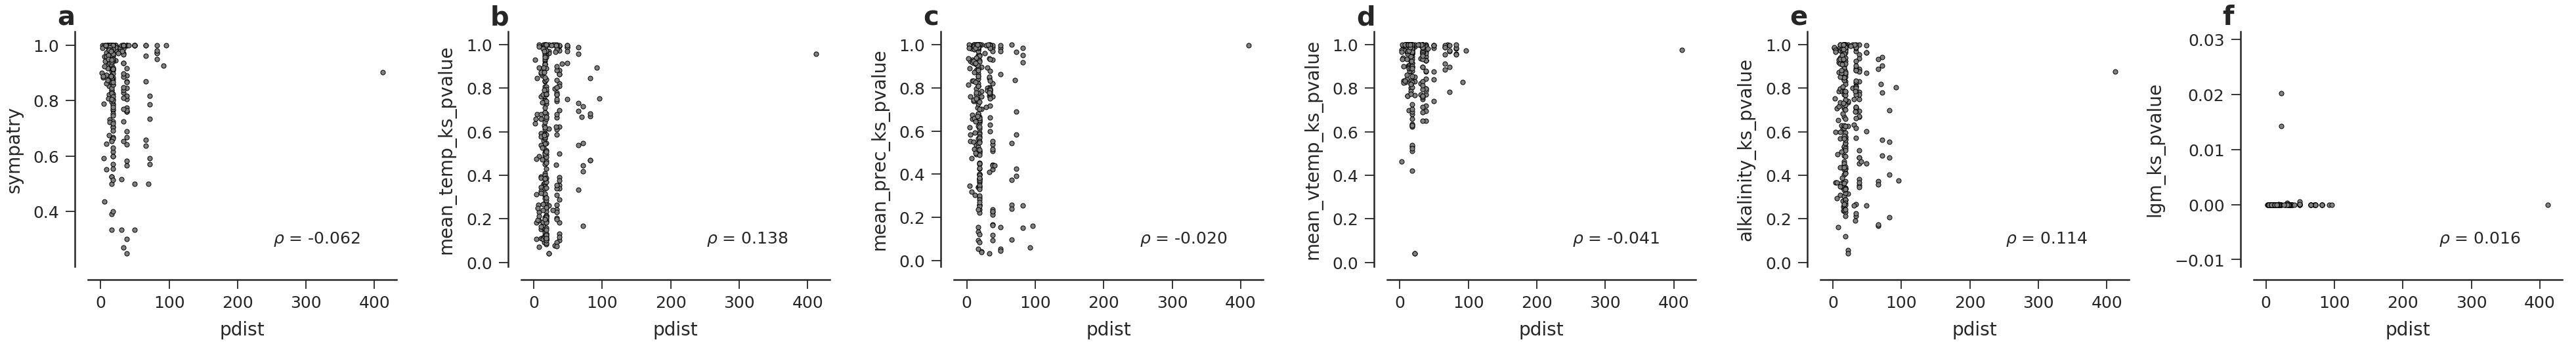

In [247]:
plot_correlations(env_phylo_europe_5050  , 1, 6)
plot_correlations(env_phylo_europe_100100, 1, 6)
plot_correlations(env_phylo_europe_200200, 1, 6)

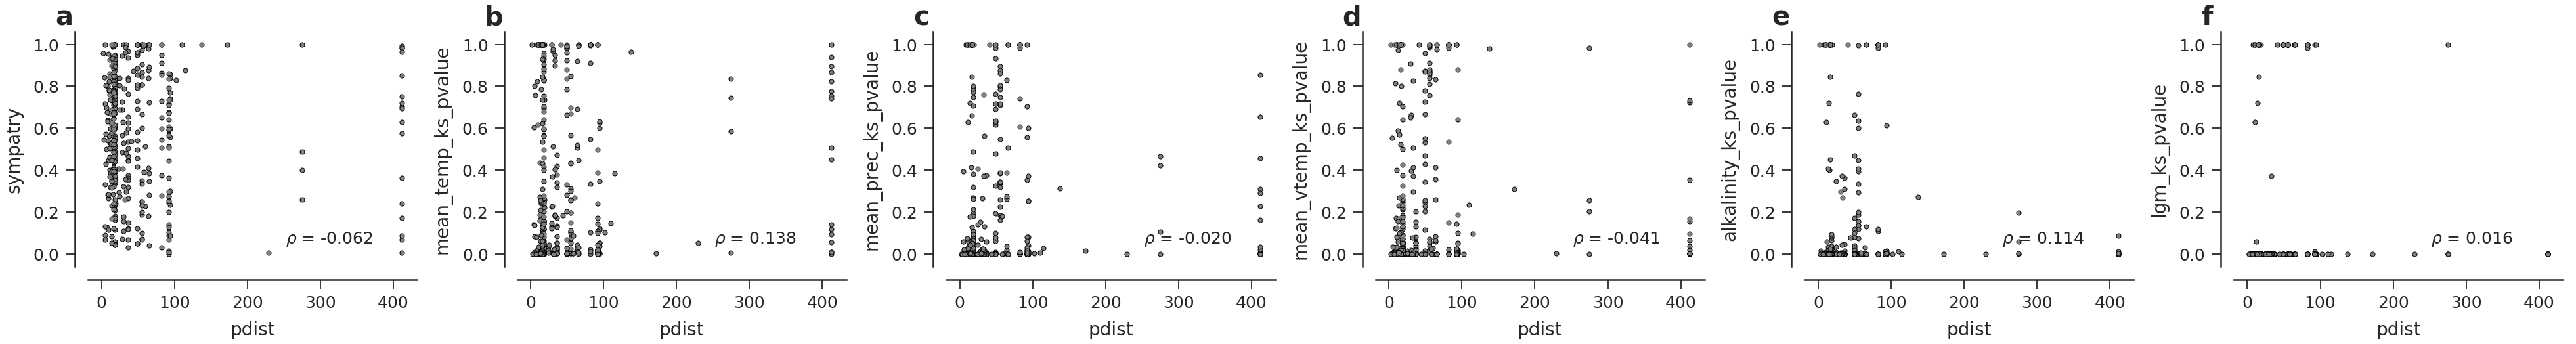

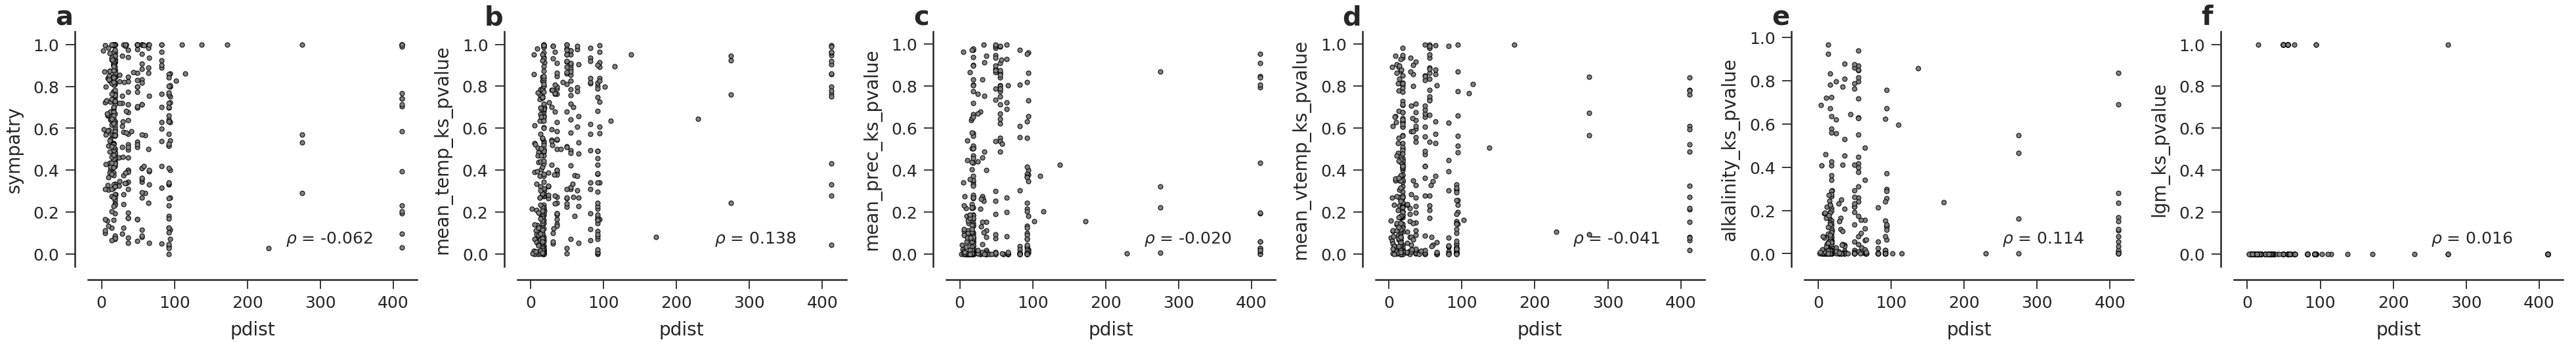

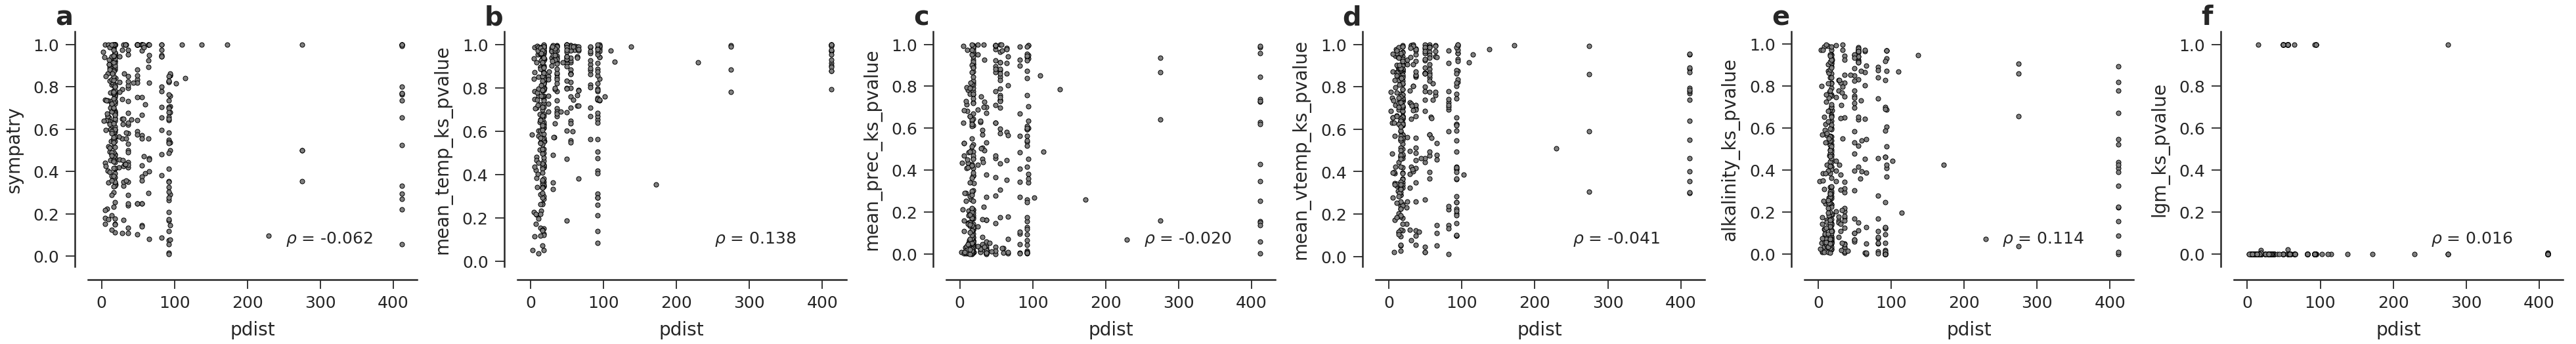

In [248]:
plot_correlations(env_phylo_north_america_5050  , 1, 6)
plot_correlations(env_phylo_north_america_100100, 1, 6)
plot_correlations(env_phylo_north_america_200200, 1, 6)